In [10]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import random
import joblib
from tqdm import tqdm
import mapply
mapply.init(n_workers=7, progressbar=True)

In [2]:
def prepare(df, remove_outliers=True, with_indicators=True):
    cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party', 'CLEAN', 'OUTLIER']

    orig_num_cols = ['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
            'max_age_participants', 'n_participants_child', 'n_participants_teen',
            'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
            'n_arrested', 'n_unharmed', 'n_participants', 'timestamp',
            'povertyPercentage', 'candidatevotes', 'totalvotes']

    if 'latitude' not in df.columns:
        orig_num_cols = [s for s in orig_num_cols if s != 'latitude']
    if 'longitude' not in df.columns:
        orig_num_cols = [s for s in orig_num_cols if s != 'longitude']

    if remove_outliers:
        df = df[df['OUTLIER'] == 0]

    df.loc[:, cat_cols] = df.loc[:, cat_cols].astype('object')#df[cat_cols] = df[cat_cols].astype('object')
    numerical_df = df.select_dtypes(include=['int64', 'float64'])

    if not with_indicators:
        numerical_df = numerical_df[orig_num_cols]

    scaler = MinMaxScaler()
    numerical_scaled = scaler.fit_transform(numerical_df.values)
    numerical_scaled = pd.DataFrame(numerical_scaled, columns=numerical_df.columns)

    return numerical_df, numerical_scaled, scaler


def features_reduction_corr(df, correlation_threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Identify highly correlated features
    highly_correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Remove highly correlated features
    df_filtered = df.drop(columns=highly_correlated_features)
    return df_filtered


def features_reduction_var(df, variance_threshold=2):
    # Compute the variance of each feature
    feature_variances = df.var()

    # Identify features below the variance threshold
    low_variance_features = feature_variances[feature_variances < variance_threshold].index

    # Prune (remove) features below the threshold
    df_pruned = df.drop(columns=low_variance_features)

    return df_pruned


def k_means(df, k_min, k_max, initial_centroids=None, max_iter=300):
    models = []
    for i in range(k_min):
        models.append(None)

    for k in tqdm(range(k_min, k_max+1)):
        if initial_centroids is None:
            model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter)
        else:
            model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter, init=initial_centroids)
        model.fit(df)
        models.append(model)

    return models


def scores(models, df, k_min, k_max, sample_size=-1, n_samples=1):
    SSEs = []
    separations = []
    silhouettess = []

    for i in range(0, k_min):
        SSEs.append(None)
        separations.append(None)
        silhouettess.append([])
    
    models = models[k_min:k_max+1]

    k = k_min

    for model in models:
        
        SSEs.append(model.inertia_)
        separations.append(metrics.davies_bouldin_score(df, model.labels_))

        silhouettes = []

        if n_samples > 0:
            print(f'k = {k}')
            for j in tqdm(range(0, n_samples)):
                if sample_size == -1:
                    sample_size = df.shape[0]   
                sampled_indeces = random.sample(range(df.shape[0]), sample_size)
                sampled_points = [df.iloc[i] for i in sampled_indeces]
                sampled_labels = [model.labels_[i] for i in sampled_indeces]
                silhouettes.append(silhouette_score(sampled_points, sampled_labels))

        silhouettess.append(silhouettes)
        k += 1
    
    scoress_dict = {
        'SSE': SSEs,
        'Separation': separations,
        'Silhouette': silhouettess
    }

    return scoress_dict


def perform_PCA(df, centroids=None, n_components=2):
    pca = PCA(n_components=n_components)

    points_pca = pca.fit_transform(df)
    if centroids is not None:
        centroids_pca = pca.transform(centroids)
        return points_pca, centroids_pca
    return points_pca


def find_features(df, columns, col_scores, threshold=0.1):
    prev_max_score = max(col_scores)
    actual_cols = [columns.pop(0)]
    
    for col in columns:
        actual_cols.append(col)
        scores, _, _ = k_means(df=df[actual_cols], n_samples=1, sample_size=10000, k_min=2, k_max=10)
        max_score = max(scores)
        if np.abs(prev_max_score - max_score) > 0.1:#prev_max_score > max_score:
            actual_cols.pop()
            print(col + ' discarded')
            print('actual score: ' + str(max_score))
        else:
            if prev_max_score < max_score:
                prev_max_score = max_score
            print(col + ' added')
            print('actual score: ' + str(max_score))
    return actual_cols, prev_max_score


def order_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    columns = numeric_df.columns.tolist()
    #random.shuffle(columns)

    max_scores = []
    for col in columns:
        scores, _, _ = k_means(df=df[[col]], n_samples=1, sample_size=10000, k_min=2, k_max=9)
        max_scores.append(max(scores))

    combined = list(zip(columns, max_scores))
    sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
    sorted_cols = [item for item, score in sorted_combined]
    sorted_scores = [score for item, score in sorted_combined]

    return sorted_cols, sorted_scores


def sample_columns(df, num_columns_to_sample=1):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    df_reduced = numeric_df.sample(n=num_columns_to_sample, axis=1).copy()
    return df_reduced


def show_scores(scores_dict, k_min, k_max):
    k_values = np.arange(k_min, k_max+1)
    fig, axes = plt.subplots(nrows=1, ncols=len(scores_dict), figsize=(15, 3))

    axes[0].plot(k_values, scores_dict['SSE'][k_min:k_max+1], marker='o')
    axes[0].set_title('SSE')
    axes[0].set_xticks(k_values[::2])
    axes[0].set_xticklabels(k_values[::2])
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('SSE')

    axes[1].plot(k_values, scores_dict['Separation'][k_min:k_max+1], marker='o')
    axes[1].set_title('Separation')
    axes[1].set_xticks(k_values[::2])
    axes[1].set_xticklabels(k_values[::2])
    axes[1].set_xlabel('Number of clusters')
    axes[1].set_ylabel('Separation')

    mean_scores = []
    silhouettess = scores_dict['Silhouette']
    for k in k_values:
        mean_scores.append(np.mean(np.array(silhouettess[k])))
        
    axes[2].plot(k_values, mean_scores, marker='o')
    axes[2].set_title('Silhouette')
    axes[2].set_xticks(k_values[::2])
    axes[2].set_xticklabels(k_values[::2])
    axes[2].set_xlabel('Number of clusters')
    axes[2].set_ylabel('Silhouette')

    plt.tight_layout()
    plt.show()

    return mean_scores

Dataset dimentions: (235219, 61)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (190977, 19)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (190977, 51)


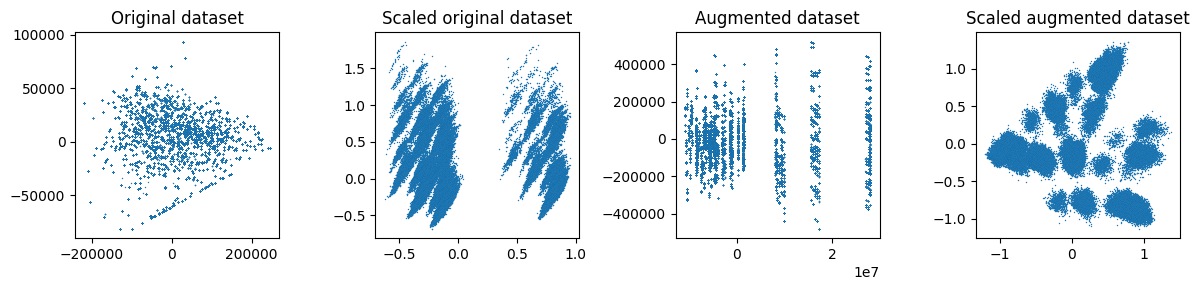

In [3]:
df_init = pd.read_csv('./dataset/data/final_clean2.csv')

df_orig, df_orig_s, scaler_orig = prepare(df_init, remove_outliers=True, with_indicators=False)
df, df_s, scaler = prepare(df_init, remove_outliers=True, with_indicators=True)

print(f'Dataset dimentions: {df_init.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df.shape}')

pca_orig = perform_PCA(df=df_orig, n_components=2)
pca_orig_s = perform_PCA(df=df_orig_s, n_components=2)

pca = perform_PCA(df=df, n_components=2)
pca_s = perform_PCA(df=df_s, n_components=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.scatter(pca_orig[:, 0], pca_orig[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 4, 2)
plt.scatter(pca_orig_s[:, 0], pca_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled original dataset')

plt.subplot(1, 4, 3)
plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 4, 4)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled augmented dataset')

plt.tight_layout()
plt.show()

Initial n_cols = 19

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 18
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 6
Index(['latitude', 'longitude', 'min_age_participants', 'n_participants_teen',
       'n_killed', 'timestamp'],
      dtype='object')


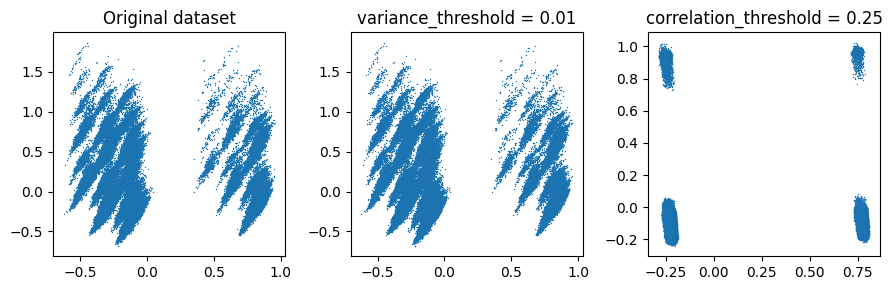

In [4]:
var_thr = 0.01
reduced_orig_var = features_reduction_var(df_orig_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_orig_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_orig_var.columns)}')
print(reduced_orig_var.columns)

corr_thr = 0.25
reduced_orig = features_reduction_corr(reduced_orig_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_orig.columns)}')
print(reduced_orig.columns)

pca_orig_v = perform_PCA(df=reduced_orig_var, n_components=2)
pca_orig_c = perform_PCA(df=reduced_orig, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_orig_s[:, 0], pca_orig_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Original dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_orig_v[:, 0], pca_orig_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_orig_c[:, 0], pca_orig_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

Initial n_cols = 51

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 48
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes', 'state_population', 'p_males',
       'p_females', 'p_participants_teen', 'p_participants_adult', 'p_killed',
       'p_injured', 'p_arrested', 'p_unharmed',
       'month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_

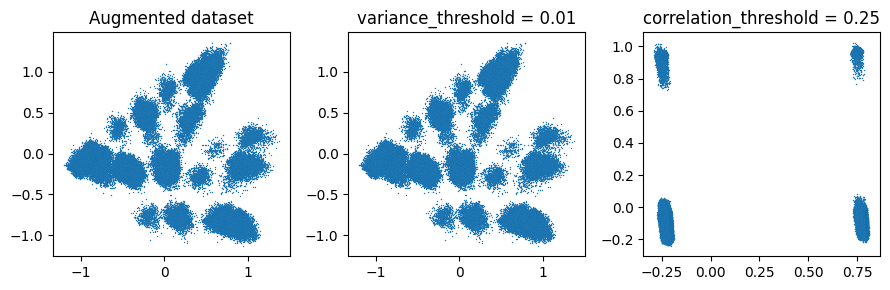

In [5]:
var_thr = 0.01
reduced_var = features_reduction_var(df_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_var.columns)}')
print(reduced_var.columns)

corr_thr = 0.25
reduced = features_reduction_corr(reduced_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced.columns)}')
print(reduced.columns)

pca_v = perform_PCA(df=reduced_var, n_components=2)
pca_c = perform_PCA(df=reduced, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_v[:, 0], pca_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_c[:, 0], pca_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

# K-means

### K-means experiments on the original dataset (without outliers)

#### K-means on the full original dataset

In [6]:
k_min = 2
k_max = 20

models = k_means(df_orig_s, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [01:19<00:00,  4.18s/it]


k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  4.85it/s]


k = 3


100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


k = 4


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


k = 5


100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


k = 6


100%|██████████| 5/5 [00:01<00:00,  4.78it/s]


k = 7


100%|██████████| 5/5 [00:01<00:00,  4.78it/s]


k = 8


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


k = 9


100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


k = 10


100%|██████████| 5/5 [00:01<00:00,  4.81it/s]


k = 11


100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


k = 12


100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


k = 13


100%|██████████| 5/5 [00:01<00:00,  4.87it/s]


k = 14


100%|██████████| 5/5 [00:01<00:00,  4.76it/s]


k = 15


100%|██████████| 5/5 [00:01<00:00,  4.79it/s]


k = 16


100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


k = 17


100%|██████████| 5/5 [00:01<00:00,  4.87it/s]


k = 18


100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


k = 19


100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


k = 20


100%|██████████| 5/5 [00:01<00:00,  4.74it/s]


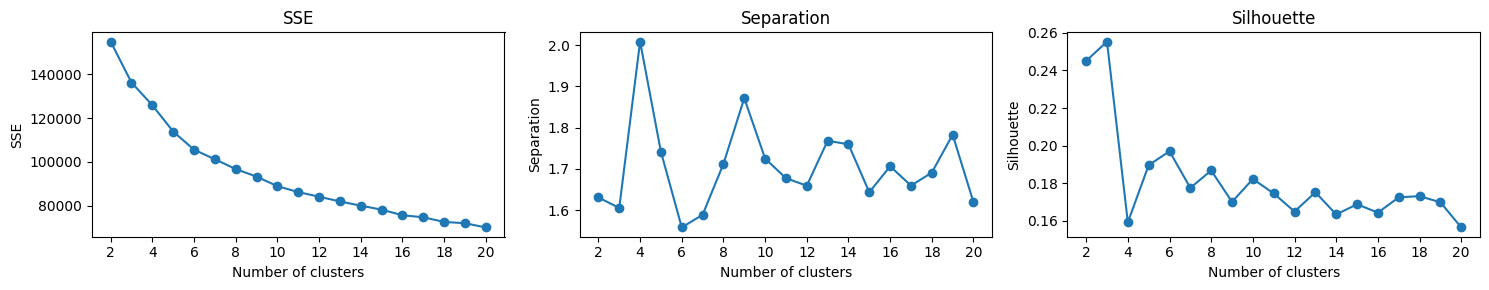

In [7]:
scores_dict = scores(models=models, df=df_orig_s, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=5)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


k = 3


100%|██████████| 3/3 [00:06<00:00,  2.05s/it]


k = 4


100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


k = 5


100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


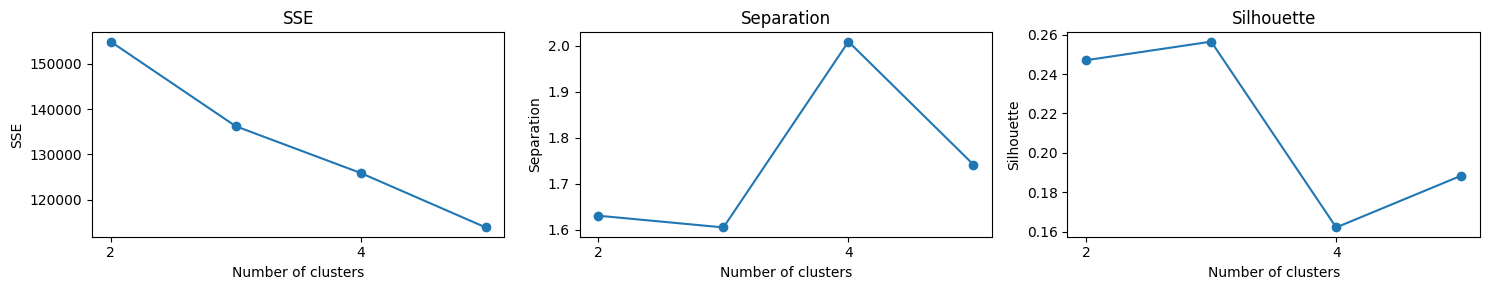


k = 2:
SSE = 154895.28685437012
Separation = 1.6304716570456599
Silhouette = 0.24706379064321835

k = 3:
SSE = 136206.37920588793
Separation = 1.6050108948413984
Silhouette = 0.25650804745041467

k = 4:
SSE = 125863.46500355854
Separation = 2.00874550183897
Silhouette = 0.16210924249987677

k = 5:
SSE = 113837.41864842274
Separation = 1.7414166616550695
Silhouette = 0.188408836447389


In [8]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=df_orig_s, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [11]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=df_orig_s, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

score_orig = {
    'SSE': scores_dict['SSE'][best_k],
    'Separation': scores_dict['Separation'][best_k],
    'Silhouette': np.mean(scores_dict['Silhouette'][best_k])
}
best_model_orig = models[best_k]
joblib.dump(best_model_orig, 'kmeans_orig_mms.pkl')

k = 3


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:21<00:00,  7.18s/it]


Best mean silhouette score for k = 3:
SSE = 136206.37920588793
Separation = 1.6050108948413984
Silhouette = 0.255300590534846


['kmeans_orig_mms.pkl']

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


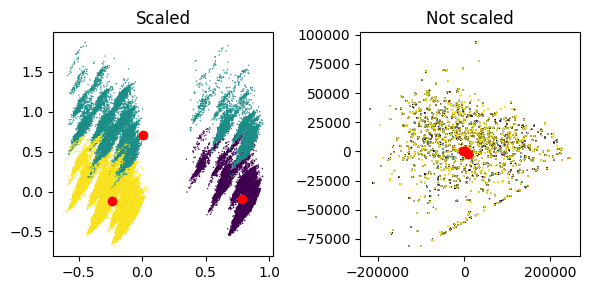

Cluster 0: 38523 points
Cluster 1: 26482 points
Cluster 2: 125972 points


In [12]:
labels = best_model_orig.labels_
centroids = best_model_orig.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=df_orig_s, centroids=centroids, n_components=2)

orig_points = df_orig
orig_centroids = scaler_orig.inverse_transform(centroids)

points_pca, centroids_pca = perform_PCA(df=orig_points, centroids=orig_centroids, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')#, s=200, alpha=0.2)
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='o')#, s=200, alpha=0.2)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### K-means on the reduced original dataset

In [13]:
k_min = 2
k_max = 20

models = k_means(df=reduced_orig, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [01:05<00:00,  3.46s/it]


k = 2


 20%|██        | 1/5 [00:00<00:00,  7.33it/s]

100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


k = 3


100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


k = 4


100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


k = 5


100%|██████████| 5/5 [00:01<00:00,  4.58it/s]


k = 6


100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


k = 7


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


k = 8


100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


k = 9


100%|██████████| 5/5 [00:01<00:00,  4.72it/s]


k = 10


100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


k = 11


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


k = 12


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


k = 13


100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


k = 14


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


k = 15


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


k = 16


100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


k = 17


100%|██████████| 5/5 [00:01<00:00,  4.76it/s]


k = 18


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


k = 19


100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


k = 20


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


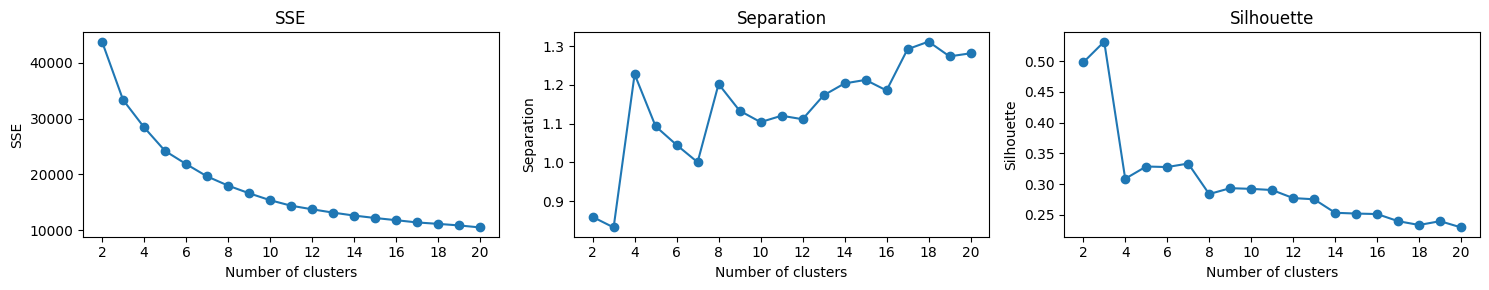

In [14]:
scores_dict = scores(models=models, df=reduced_orig, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=5)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


k = 3


100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


k = 4


100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


k = 5


100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


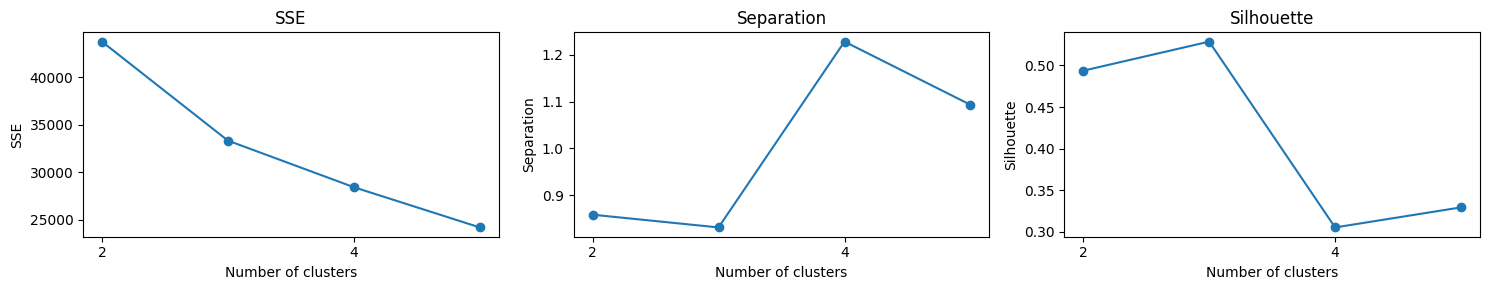


k = 2:
SSE = 43748.33131414113
Separation = 0.8589341949521003
Silhouette = 0.49360593856888274

k = 3:
SSE = 33337.49599621496
Separation = 0.8318175058975704
Silhouette = 0.5285492227187203

k = 4:
SSE = 28434.88306412453
Separation = 1.2275560612239902
Silhouette = 0.30536255152039904

k = 5:
SSE = 24203.440233526748
Separation = 1.0929537131549645
Silhouette = 0.32946667638888527


In [15]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=reduced_orig, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [16]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=reduced_orig, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

score_r_orig = {
    'SSE': scores_dict['SSE'][best_k],
    'Separation': scores_dict['Separation'][best_k],
    'Silhouette': np.mean(scores_dict['Silhouette'][best_k])
}
best_model_r_orig = models[best_k]
joblib.dump(best_model_r_orig, 'kmeans_r_orig_mms.pkl')

k = 3


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:19<00:00,  6.39s/it]


Best mean silhouette score for k = 3:
SSE = 33337.49599621496
Separation = 0.8318175058975704
Silhouette = 0.5290817065457744


['kmeans_r_orig_mms.pkl']

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


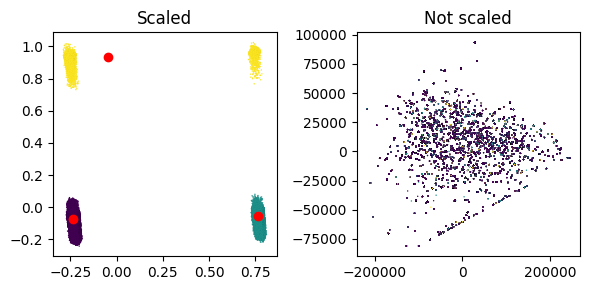

Cluster 0: 135320 points
Cluster 1: 42394 points
Cluster 2: 13263 points


In [17]:
labels = best_model_r_orig.labels_
centroids = best_model_r_orig.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=reduced_orig, centroids=centroids, n_components=2)

orig_points = df_orig

points_pca = perform_PCA(df=orig_points, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')#, s=200, alpha=0.2)
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

### K-means experiments on the augmented (i.e. with indicators) dataset (without outliers)

#### K-means on the full augmented dataset

In [18]:
k_min = 2
k_max = 20

models = k_means(df=df_s, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [02:27<00:00,  7.74s/it]


k = 2


100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


k = 3


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


k = 4


100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


k = 5


100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


k = 6


100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


k = 7


100%|██████████| 3/3 [00:00<00:00,  3.96it/s]


k = 8


100%|██████████| 3/3 [00:00<00:00,  4.15it/s]


k = 9


100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


k = 10


100%|██████████| 3/3 [00:00<00:00,  4.22it/s]


k = 11


100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


k = 12


100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


k = 13


100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


k = 14


100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


k = 15


100%|██████████| 3/3 [00:00<00:00,  3.92it/s]


k = 16


100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


k = 17


100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


k = 18


100%|██████████| 3/3 [00:00<00:00,  4.15it/s]


k = 19


100%|██████████| 3/3 [00:00<00:00,  4.18it/s]


k = 20


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


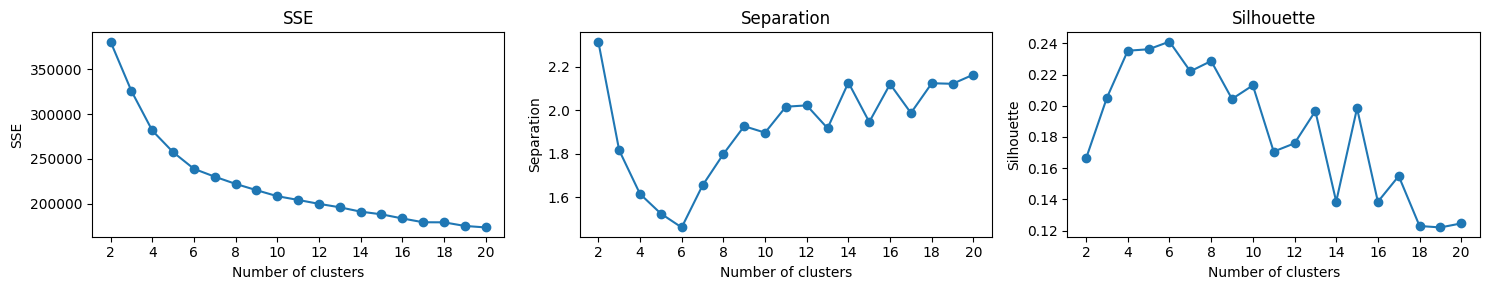

In [19]:
scores_dict = scores(models=models, df=df_s, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 4


100%|██████████| 3/3 [00:07<00:00,  2.40s/it]


k = 5


100%|██████████| 3/3 [00:08<00:00,  2.84s/it]


k = 6


100%|██████████| 3/3 [00:08<00:00,  2.73s/it]


k = 7


100%|██████████| 3/3 [00:08<00:00,  2.80s/it]


k = 8


100%|██████████| 3/3 [00:08<00:00,  2.83s/it]


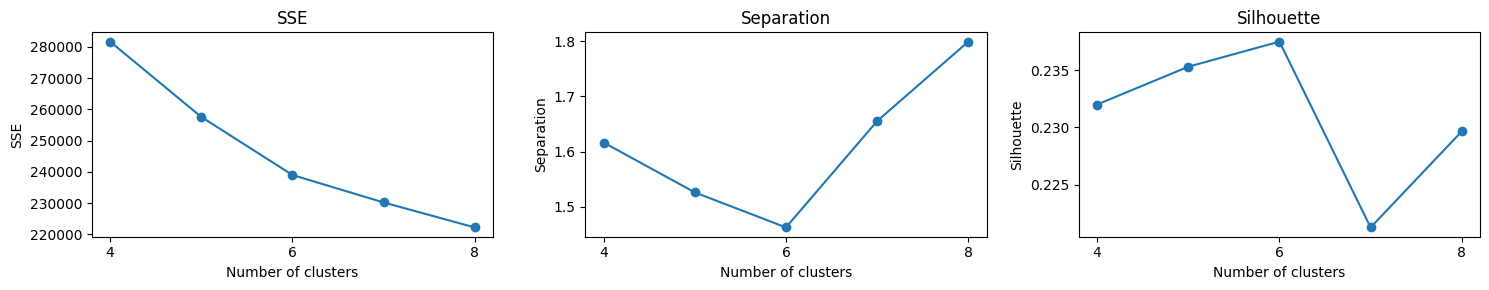


k = 4:
SSE = 281680.0810217594
Separation = 1.6162913597581066
Silhouette = 0.2320011213220636

k = 5:
SSE = 257573.47683811054
Separation = 1.5259768309441542
Silhouette = 0.2353023803562012

k = 6:
SSE = 239000.20582518316
Separation = 1.4625169859133083
Silhouette = 0.23749370630627084

k = 7:
SSE = 230206.9256236472
Separation = 1.655073761936544
Silhouette = 0.22126325850073467

k = 8:
SSE = 222215.49886390832
Separation = 1.7990481275460954
Silhouette = 0.22965353416936804


In [20]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=df_s, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [21]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=df_s, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

score = {
    'SSE': scores_dict['SSE'][best_k],
    'Separation': scores_dict['Separation'][best_k],
    'Silhouette': np.mean(scores_dict['Silhouette'][best_k])
}
best_model = models[best_k]
joblib.dump(best_model, 'kmeans_mms.pkl')

k = 6


100%|██████████| 3/3 [00:26<00:00,  8.84s/it]


Best mean silhouette score for k = 6:
SSE = 239000.20582518316
Separation = 1.4625169859133083
Silhouette = 0.23922525507806047


['kmeans_mms.pkl']

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


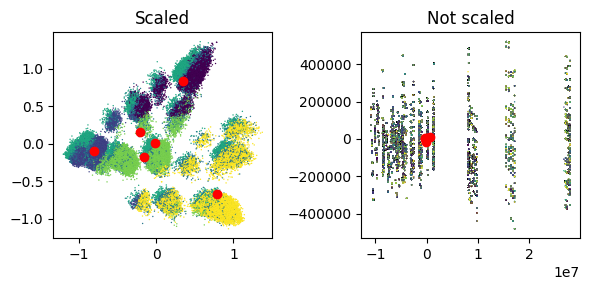

Cluster 0: 39248 points
Cluster 1: 41512 points
Cluster 2: 24094 points
Cluster 3: 12090 points
Cluster 4: 38194 points
Cluster 5: 35839 points


In [22]:
labels = best_model.labels_
centroids = best_model.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=df_s, centroids=centroids, n_components=2)

orig_points = df
orig_centroids = scaler.inverse_transform(centroids)

points_pca, centroids_pca = perform_PCA(df=orig_points, centroids=orig_centroids, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='o')
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### K-means on the reduced augmented dataset
(the same as with the reduced original dataset)

In [23]:
k_min = 2
k_max = 20

models = k_means(df=reduced, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [01:22<00:00,  4.33s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  4.52it/s]


k = 3


100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


k = 4


100%|██████████| 3/3 [00:00<00:00,  3.97it/s]


k = 5


100%|██████████| 3/3 [00:00<00:00,  4.11it/s]


k = 6


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


k = 7


100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


k = 8


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


k = 9


100%|██████████| 3/3 [00:00<00:00,  4.19it/s]


k = 10


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


k = 11


100%|██████████| 3/3 [00:00<00:00,  4.23it/s]


k = 12


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


k = 13


100%|██████████| 3/3 [00:00<00:00,  4.17it/s]


k = 14


100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


k = 15


100%|██████████| 3/3 [00:00<00:00,  4.15it/s]


k = 16


100%|██████████| 3/3 [00:00<00:00,  4.25it/s]


k = 17


100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


k = 18


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


k = 19


100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


k = 20


100%|██████████| 3/3 [00:00<00:00,  4.22it/s]


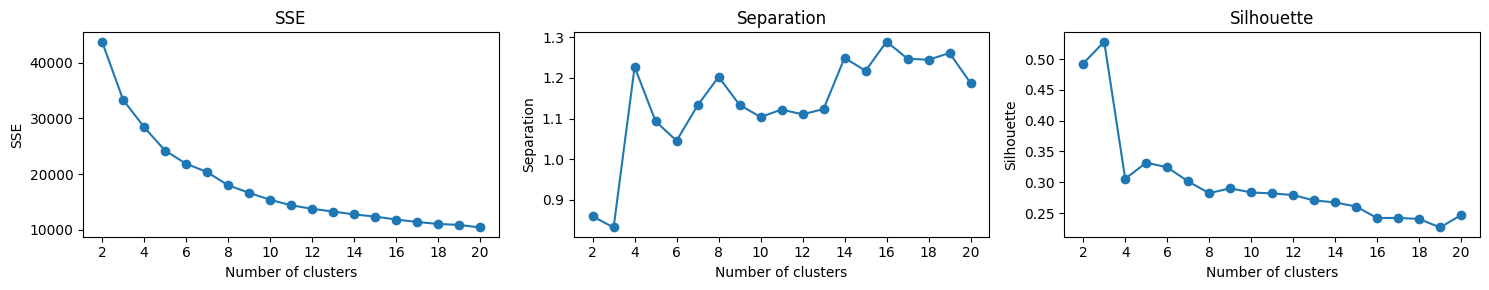

In [24]:
scores_dict = scores(models=models, df=reduced, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


k = 3


100%|██████████| 3/3 [00:08<00:00,  2.93s/it]


k = 4


100%|██████████| 3/3 [00:08<00:00,  2.74s/it]


k = 5


100%|██████████| 3/3 [00:08<00:00,  2.80s/it]


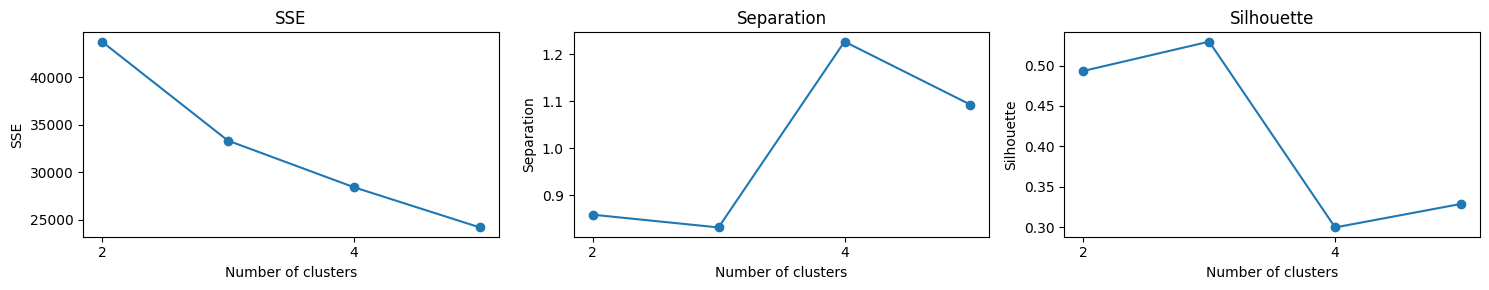


k = 2:
SSE = 43748.331314141134
Separation = 0.8589341949521003
Silhouette = 0.4932915180041511

k = 3:
SSE = 33337.495996214966
Separation = 0.8318175058975704
Silhouette = 0.5296117693241814

k = 4:
SSE = 28434.885089425148
Separation = 1.2271325103240553
Silhouette = 0.29982643612158144

k = 5:
SSE = 24203.617186832063
Separation = 1.0930054025757043
Silhouette = 0.3289283947714085


In [25]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=reduced, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [26]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=reduced, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

score_r = {
    'SSE': scores_dict['SSE'][best_k],
    'Separation': scores_dict['Separation'][best_k],
    'Silhouette': np.mean(scores_dict['Silhouette'][best_k])
}
best_model_r = models[best_k]
joblib.dump(best_model_r, 'kmeans_r_mms.pkl')

k = 3


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:27<00:00,  9.20s/it]


Best mean silhouette score for k = 3:
SSE = 33337.495996214966
Separation = 0.8318175058975704
Silhouette = 0.5275344098374074


['kmeans_r_mms.pkl']

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


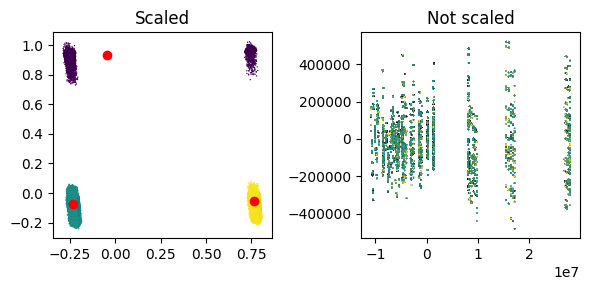

Cluster 0: 13263 points
Cluster 1: 135320 points
Cluster 2: 42394 points


In [27]:
labels = best_model_r.labels_
centroids = best_model_r.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=reduced, centroids=centroids, n_components=2)

orig_points = df

points_pca = perform_PCA(df=orig_points, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### + Trying with only indicators

Idicator dataset dimentions: (190977, 21)


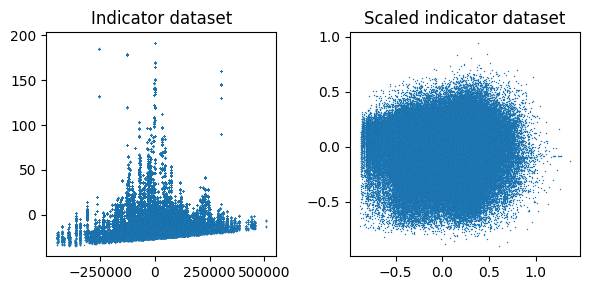

In [28]:
df_ind = df[['month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_ratio_unharmed', 'month_cd_incidents',
       'month_cd_votes_incidents', 'cd_population', 'percentage_republican',
       'percentage_democrat', 'cd_month_SHOT_INJURED', 'cd_month_SHOT_DEAD',
       'cd_month_NON_SHOOTING', 'cd_month_SHOTS_FIRED_UNHARMED',
       'cd_month_OTHER']]

scaler_ind = MinMaxScaler()
df_ind_s = scaler.fit_transform(df_ind)
df_ind_s = pd.DataFrame(df_ind_s, columns=df_ind.columns)

print(f'Idicator dataset dimentions: {df_ind.shape}')

pca = perform_PCA(df=df_ind, n_components=2)
pca_s = perform_PCA(df=df_ind_s, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca[:, 0], pca[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Indicator dataset')

plt.subplot(1, 2, 2)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled indicator dataset')

plt.tight_layout()
plt.show()

Initial n_cols = 21

Survived columns (variance_threshold = 0.01):----------------------------------------------
n_cols = 21
Index(['month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_ratio_unharmed', 'month_cd_incidents',
       'month_cd_votes_incidents', 'cd_population', 'percentage_republican',
       'percentage_democrat', 'cd_month_SHOT_INJURED', 'cd_month_SHOT_DEAD',
       'cd_month_NON_SHOOTING', 'cd_month_SHOTS_FIRED_UNHARMED',
       'cd_month_OTHER'],
      dtype='object')

Survived columns (correlation_threshold = 0.25):----------------------------------------------
n_cols = 6
Index(['month_cd_change_min_age_participants', 'month_cd_ratio_males',
       'mon

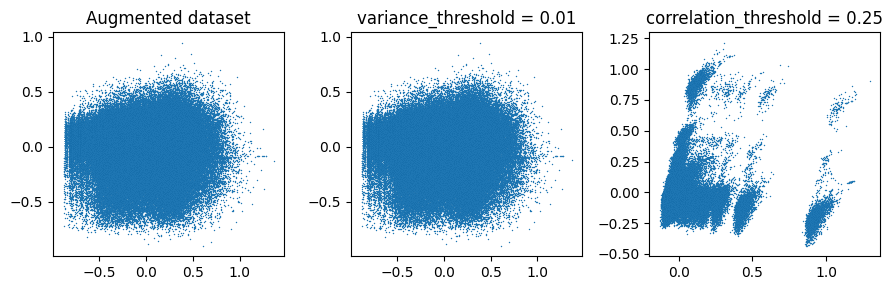

In [29]:
var_thr = 0.01
reduced_ind_var = features_reduction_var(df_ind_s, variance_threshold=var_thr)
print(f'Initial n_cols = {df_ind_s.shape[1]}')
print(f'\nSurvived columns (variance_threshold = {var_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_ind_var.columns)}')
print(reduced_ind_var.columns)

corr_thr = 0.25
reduced_ind = features_reduction_corr(reduced_ind_var, correlation_threshold=corr_thr)
print(f'\nSurvived columns (correlation_threshold = {corr_thr}):----------------------------------------------')
print(f'n_cols = {len(reduced_ind.columns)}')
print(reduced_ind.columns)

pca_v = perform_PCA(df=reduced_ind_var, n_components=2)
pca_c = perform_PCA(df=reduced_ind, n_components=2)

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.scatter(pca_s[:, 0], pca_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Augmented dataset')

plt.subplot(1, 3, 2)
plt.scatter(pca_v[:, 0], pca_v[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'variance_threshold = {var_thr}')

plt.subplot(1, 3, 3)
plt.scatter(pca_c[:, 0], pca_c[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title(f'correlation_threshold = {corr_thr}')

plt.tight_layout()
plt.show()

#### K-means on the full indicator dataset

In [30]:
k_min = 2
k_max = 20

models = k_means(df=df_ind_s, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [02:25<00:00,  7.65s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  4.33it/s]


k = 3


100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


k = 4


100%|██████████| 3/3 [00:00<00:00,  4.41it/s]


k = 5


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


k = 6


100%|██████████| 3/3 [00:00<00:00,  4.21it/s]


k = 7


100%|██████████| 3/3 [00:00<00:00,  4.22it/s]


k = 8


100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


k = 9


100%|██████████| 3/3 [00:00<00:00,  4.15it/s]


k = 10


100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


k = 11


100%|██████████| 3/3 [00:00<00:00,  4.18it/s]


k = 12


100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


k = 13


100%|██████████| 3/3 [00:00<00:00,  4.19it/s]


k = 14


100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


k = 15


100%|██████████| 3/3 [00:00<00:00,  4.18it/s]


k = 16


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


k = 17


100%|██████████| 3/3 [00:00<00:00,  4.20it/s]


k = 18


100%|██████████| 3/3 [00:00<00:00,  4.25it/s]


k = 19


100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


k = 20


100%|██████████| 3/3 [00:00<00:00,  4.21it/s]


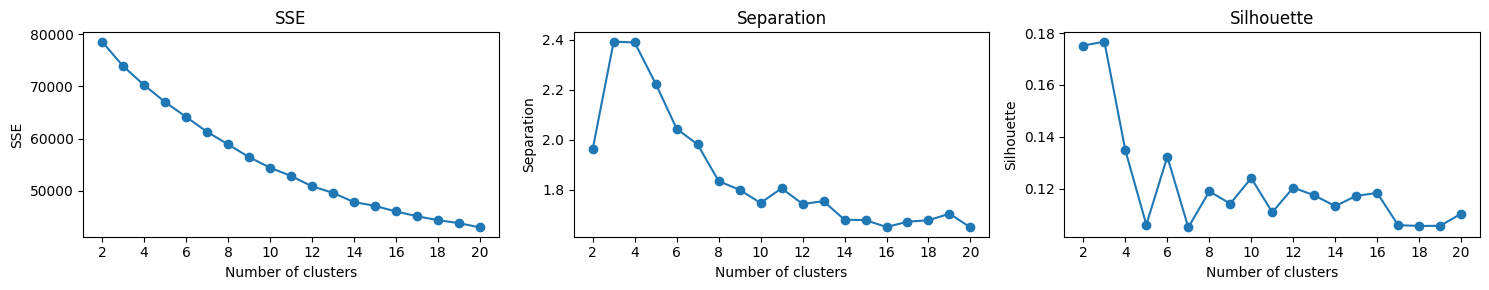

In [31]:
scores_dict = scores(models=models, df=df_ind_s, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:07<00:00,  2.56s/it]


k = 3


100%|██████████| 3/3 [00:08<00:00,  2.99s/it]


k = 4


100%|██████████| 3/3 [00:08<00:00,  2.87s/it]


k = 5


100%|██████████| 3/3 [00:08<00:00,  2.88s/it]


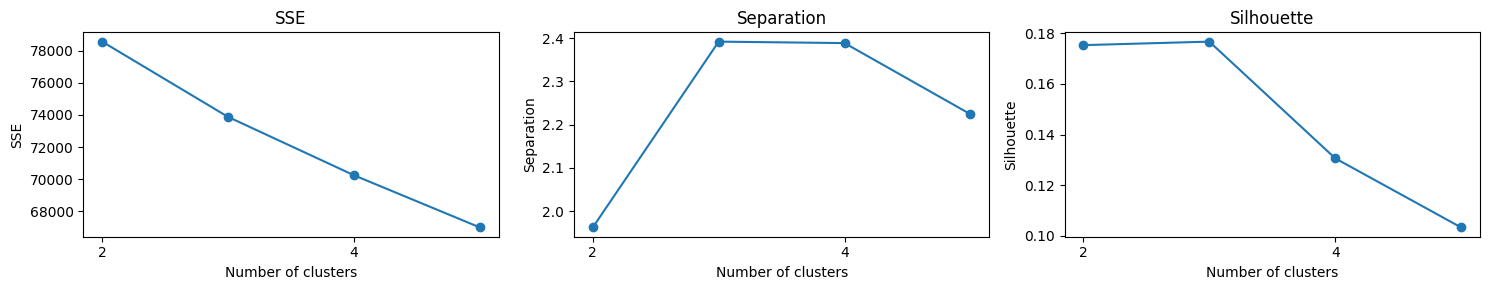


k = 2:
SSE = 78555.09135838666
Separation = 1.9620112180597051
Silhouette = 0.17537701329786123

k = 3:
SSE = 73874.43056744307
Separation = 2.391979671883118
Silhouette = 0.1767622383550341

k = 4:
SSE = 70246.33436272573
Separation = 2.3885711304681507
Silhouette = 0.13058883733885285

k = 5:
SSE = 67002.53402498407
Separation = 2.2239167803971998
Silhouette = 0.10323310060867814


In [32]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=df_ind_s, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [33]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=df_ind_s, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

score_ind = {
    'SSE': scores_dict['SSE'][best_k],
    'Separation': scores_dict['Separation'][best_k],
    'Silhouette': np.mean(scores_dict['Silhouette'][best_k])
}
best_model_ind = models[best_k]
joblib.dump(best_model_ind, 'kmeans_ind_mms.pkl')

k = 3


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:27<00:00,  9.00s/it]


Best mean silhouette score for k = 3:
SSE = 73874.43056744307
Separation = 2.391979671883118
Silhouette = 0.17637547181414892


['kmeans_ind_mms.pkl']

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


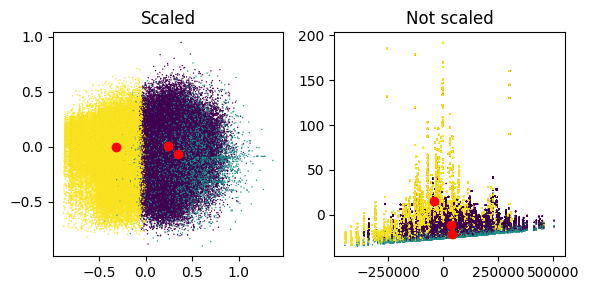

Cluster 0: 89350 points
Cluster 1: 15907 points
Cluster 2: 85720 points


In [34]:
labels = best_model_ind.labels_
centroids = best_model_ind.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=df_ind_s, centroids=centroids, n_components=2)

orig_points = df_ind
orig_centroids = scaler.inverse_transform(centroids)

points_pca, centroids_pca = perform_PCA(df=orig_points, centroids=orig_centroids, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='o')
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### K-means on the reduced indicator dataset

In [35]:
k_min = 2
k_max = 20

models = k_means(df=reduced_ind, k_min=k_min, k_max=k_max, max_iter=1000000)

100%|██████████| 19/19 [01:41<00:00,  5.35s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  4.39it/s]


k = 3


100%|██████████| 3/3 [00:00<00:00,  4.21it/s]


k = 4


100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


k = 5


100%|██████████| 3/3 [00:00<00:00,  4.12it/s]


k = 6


100%|██████████| 3/3 [00:00<00:00,  4.15it/s]


k = 7


100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


k = 8


100%|██████████| 3/3 [00:00<00:00,  4.15it/s]


k = 9


100%|██████████| 3/3 [00:00<00:00,  3.60it/s]


k = 10


100%|██████████| 3/3 [00:00<00:00,  3.91it/s]


k = 11


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


k = 12


100%|██████████| 3/3 [00:00<00:00,  4.17it/s]


k = 13


100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


k = 14


100%|██████████| 3/3 [00:00<00:00,  4.20it/s]


k = 15


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


k = 16


100%|██████████| 3/3 [00:00<00:00,  4.24it/s]


k = 17


100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


k = 18


100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


k = 19


100%|██████████| 3/3 [00:00<00:00,  4.22it/s]


k = 20


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


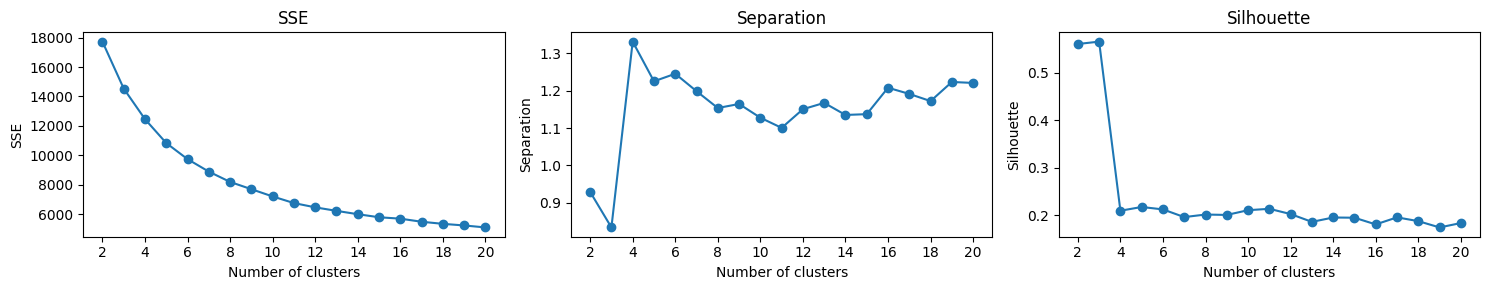

In [36]:
scores_dict = scores(models=models, df=reduced_ind, k_min=k_min, k_max=k_max, sample_size=1000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:07<00:00,  2.58s/it]


k = 3


100%|██████████| 3/3 [00:08<00:00,  2.99s/it]


k = 4


100%|██████████| 3/3 [00:09<00:00,  3.01s/it]


k = 5


100%|██████████| 3/3 [00:08<00:00,  2.98s/it]


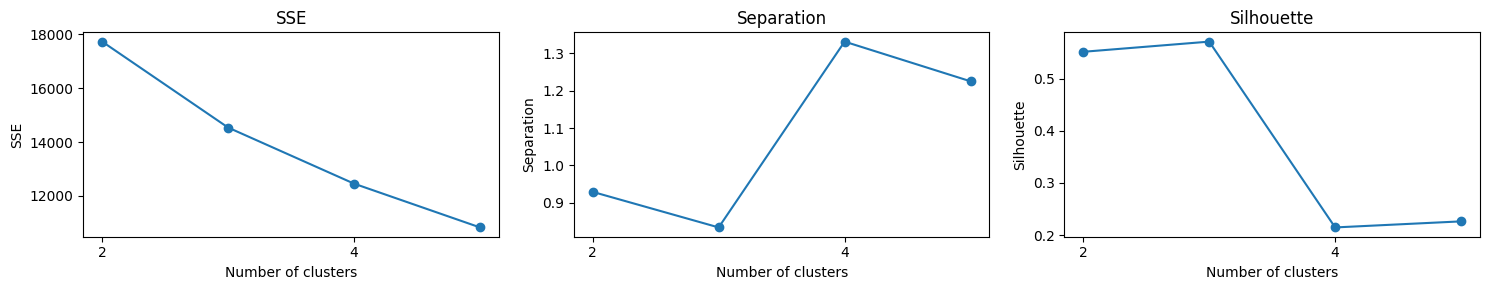


k = 2:
SSE = 17727.764698943585
Separation = 0.9293714274272848
Silhouette = 0.5512642680819905

k = 3:
SSE = 14536.677436608601
Separation = 0.8343748674959905
Silhouette = 0.5707464038799565

k = 4:
SSE = 12453.986297942196
Separation = 1.3308464756049685
Silhouette = 0.2147602496561831

k = 5:
SSE = 10828.823035082154
Separation = 1.2248225952670968
Silhouette = 0.22637604533091385


In [37]:
best_k = np.argmax(mean_scores)+k_min

k_min = np.max([best_k-2, 2])
k_max = np.min([best_k+2, k_max])

scores_dict = scores(models=models, df=reduced_ind, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)

for k in range(k_min, k_max+1):
    print(f'\nk = {k}:')

    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][k])}')

In [38]:
best_k = np.argmax(mean_scores)+k_min

scores_dict = scores(models=models, df=reduced_ind, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scores_dict:
    print(f'{key} = {np.mean(scores_dict[key][best_k])}')

score_r_ind = {
    'SSE': scores_dict['SSE'][best_k],
    'Separation': scores_dict['Separation'][best_k],
    'Silhouette': np.mean(scores_dict['Silhouette'][best_k])
}
best_model_r_ind = models[best_k]
joblib.dump(best_model_r_ind, 'kmeans_r_ind_mms.pkl')

k = 3


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:27<00:00,  9.24s/it]


Best mean silhouette score for k = 3:
SSE = 14536.677436608601
Separation = 0.8343748674959905
Silhouette = 0.5794924105321896


['kmeans_r_ind_mms.pkl']

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


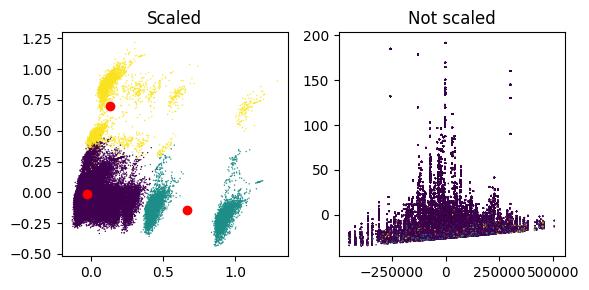

Cluster 0: 178842 points
Cluster 1: 6902 points
Cluster 2: 5233 points


In [39]:
labels = best_model_r_ind.labels_
centroids = best_model_r_ind.cluster_centers_

points_pca_s, centroids_pca_s = perform_PCA(df=reduced_ind, centroids=centroids, n_components=2)

orig_points = df_ind

points_pca = perform_PCA(df=orig_points, n_components=2)

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', marker='o')
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=labels, s=1, edgecolors='black', linewidths=0.001)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(labels, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

## Analysis

#### Original data clustering

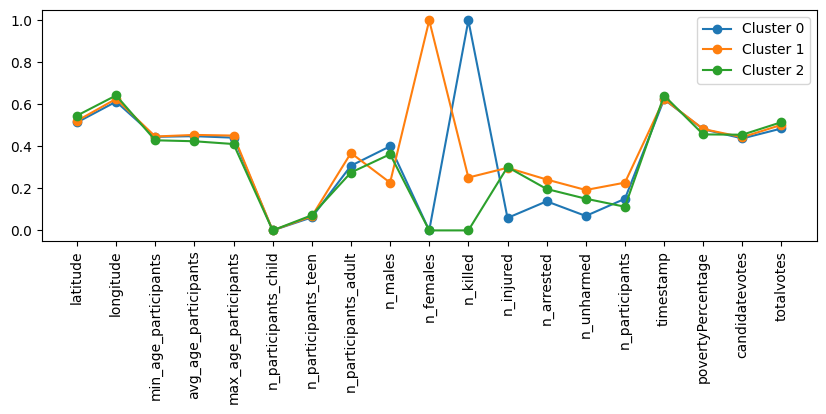

In [40]:
centers = best_model_orig.cluster_centers_
cols = df_orig.columns

plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

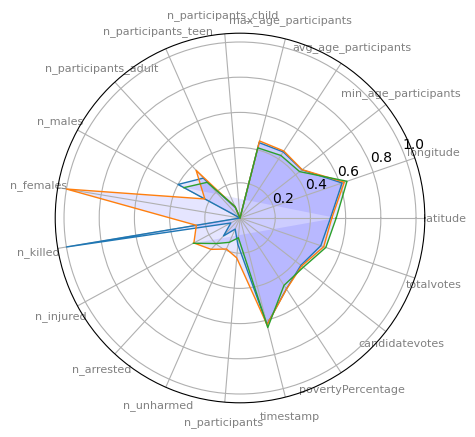

In [41]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=8) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [42]:
cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party']

df_c =  df_init[df_init['OUTLIER'] == 0]
df_c = df_c[cat_cols]

In [43]:
party_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0         23238       15285
1         14017       12465
2         72259       53713

In [44]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.603224    0.396776
1  0.529303    0.470697
2  0.573612    0.426388

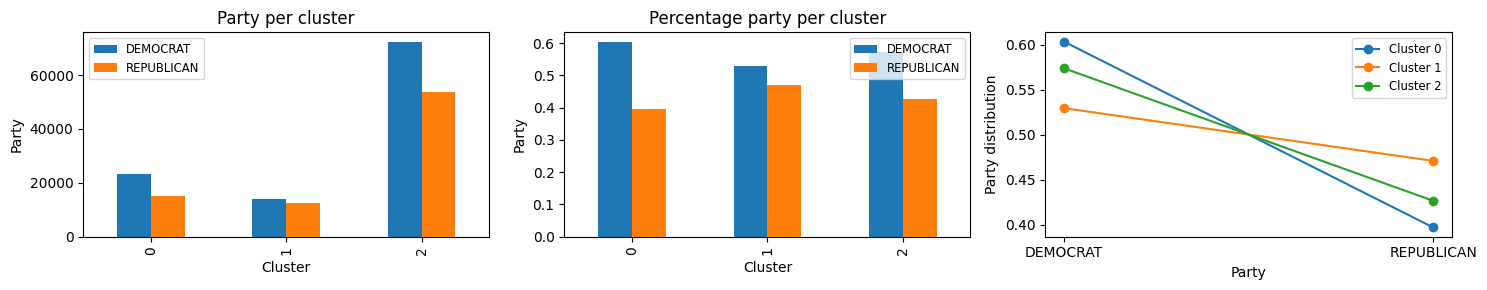

In [45]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [46]:
day_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         1336  1189  1193  1303  1280  1258  1237  1256  1202  1289  ...   
1          962   810   844   849   879   900   843   869   847   787  ...   
2         4662  4031  4096  4064  4192  4071  4091  4064  4018  3936  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0         1204  1330  1236  1264  1294  1308  1297  1186  1163   800  
1          872   851   876   930   896   892   872   805   842   520  
2         4005  4055  3944  4281  4163  4187  4154  3952  3801  2496  

[3 rows x 31 columns]

In [47]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.034681  0.030865  0.030969  0.033824  0.033227  0.032656  0.032111   
1  0.036327  0.030587  0.031871  0.032060  0.033192  0.033985  0.031833   
2  0.037008  0.031999  0.032515  0.032261  0.033277  0.032317  0.032475   

         8         9         10  ...        22        23        24        25  \
0  0.032604  0.031202  0.033461  ...  0.031254  0.034525  0.032085  0.032812   
1  0.032815  0.031984  0.029718  ...  0.032928  0.032135  0.033079  0.035118   
2  0.032261  0.031896  0.031245  ...  0.031793  0.032190  0.031309  0.033984   

         26        27        28        29        30        31  
0  0.033590  0.033954  0.033668  0.030787  0.030190  0.020767  
1  0.033834  0.033683  0.032928  0.030398  0.031795  0.019636  
2  0.033047  0.033238  0.032976  0.031372  0.030173  0.019814  

[3 rows x 31 columns]

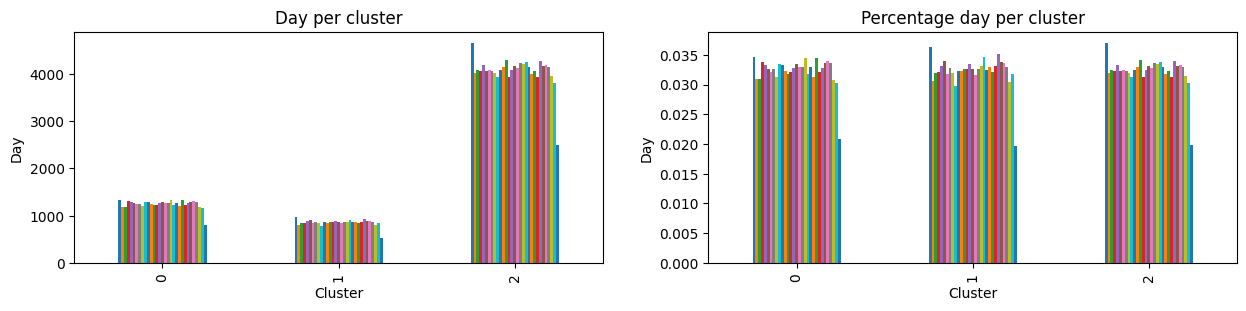

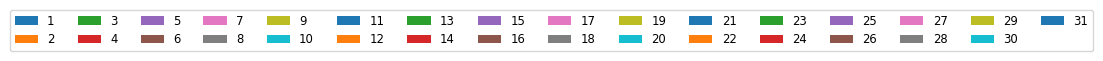

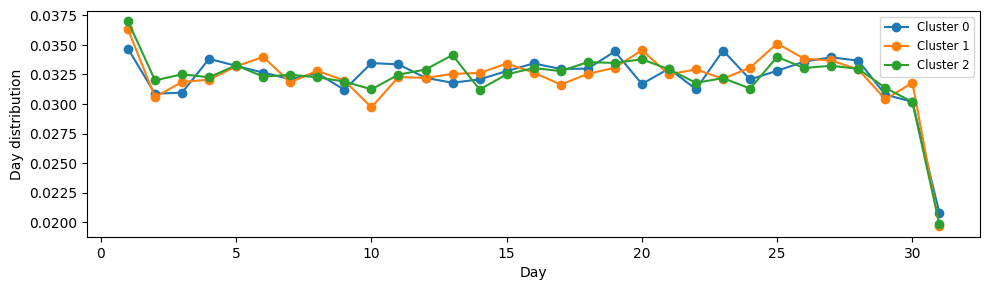

In [48]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [49]:
month_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['date_month'])
month_xt_pct

date_month     1      2      3     4      5     6      7      8      9   \
row_0                                                                     
0            3761   3019   3547  2805   3182  3024   3395   3354   3049   
1            2601   2145   2532  2057   2184  2031   2313   2275   2119   
2           12148  10079  12196  9678  10234  9509  10743  11050  10240   

date_month     10    11     12  
row_0                           
0            3072  3084   3231  
1            2182  1925   2118  
2           10564  9364  10167

In [50]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.097630  0.078369  0.092075  0.072814  0.082600  0.078499  0.088129   
1  0.098218  0.080998  0.095612  0.077675  0.082471  0.076694  0.087342   
2  0.096434  0.080010  0.096815  0.076827  0.081240  0.075485  0.085281   

         8         9         10        11        12  
0  0.087065  0.079148  0.079745  0.080056  0.083872  
1  0.085907  0.080017  0.082396  0.072691  0.079979  
2  0.087718  0.081288  0.083860  0.074334  0.080708

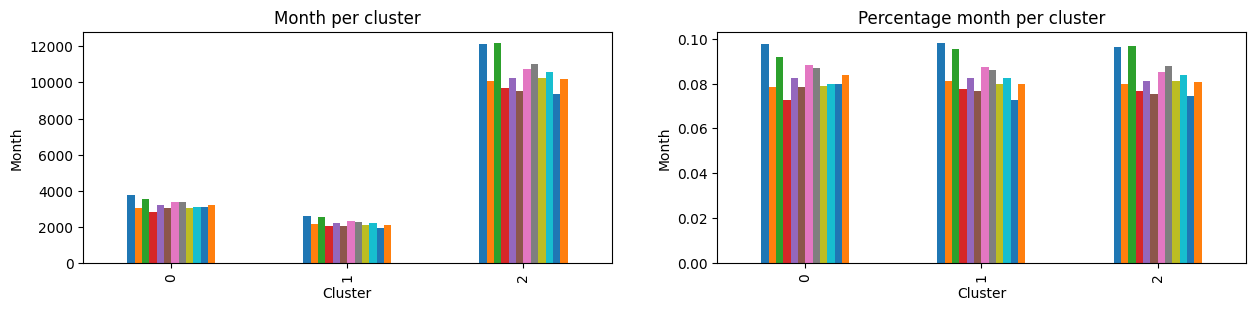

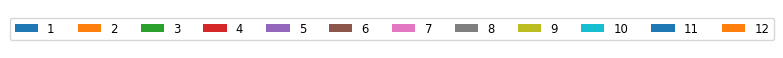

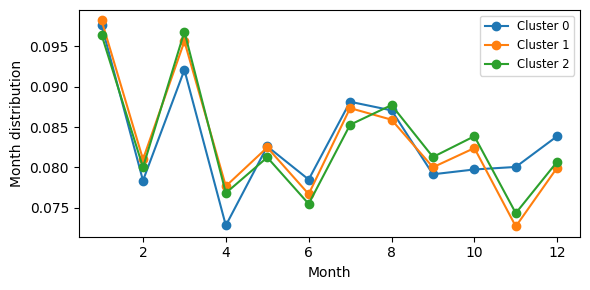

In [51]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [52]:
year_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0              15    7104    8365   10172   10522    2345
1               4    4773    5621    7247    7237    1600
2              22   19915   25436   35272   37173    8154

In [53]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000389  0.184409  0.217143  0.264050  0.273136  0.060873
1  0.000151  0.180236  0.212257  0.273658  0.273280  0.060418
2  0.000175  0.158091  0.201918  0.279999  0.295089  0.064729

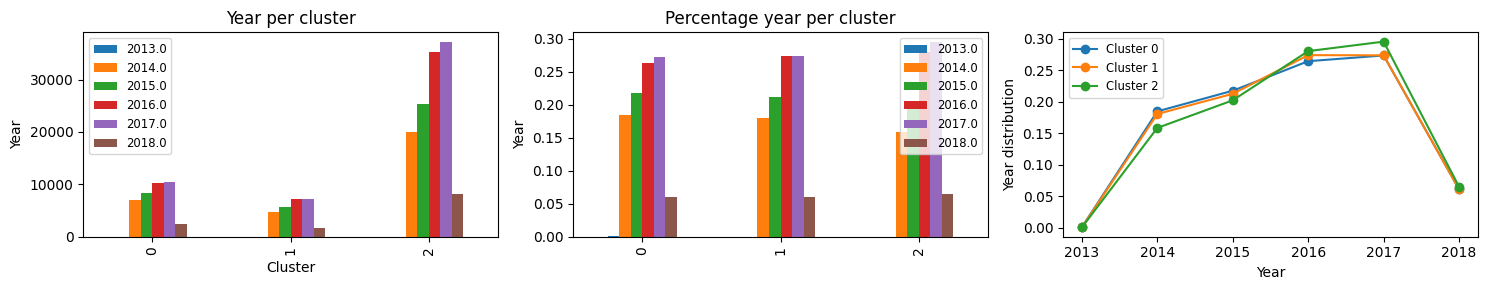

In [54]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [55]:
state_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0         1129      21      639       477        2507       603          318   
1          723      23      304       433        1130       425          297   
2         2485     113      967      1502        6653      1837         2160   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0           177     2396     1578  ...            74       1213   2638   169   
1           151     1643     1245  ...            61        938   1584   132   
2          1107     7190     4433  ...           355       3997   5308   551   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0           39       963         526            199        732       87  
1           71       653         452            211        616       77  
2          275      3234        1845            915       2845      287  

[3 rows x 50 columns]

In [56]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.029307  0.000545  0.016587  0.012382    0.065078  0.015653     0.008255   
1  0.027302  0.000869  0.011479  0.016351    0.042670  0.016049     0.011215   
2  0.019727  0.000897  0.007676  0.011923    0.052813  0.014583     0.017147   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.004595  0.062197  0.040963  ...      0.001921   0.031488  0.068479   
1  0.005702  0.062042  0.047013  ...      0.002303   0.035420  0.059814   
2  0.008788  0.057076  0.035190  ...      0.002818   0.031729  0.042136   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004387  0.001012  0.024998    0.013654       0.005166   0.019002   
1  0.004985  0.002681  0.024658    0.017068       0.007968   0.023261   
2  0.004374  0.002183  0.025672    0.014646       0.007264   0.022584   

    WYOMING  
0  0.002258  
1  0.002908  
2  0.002278  

[3 rows x 50 columns]

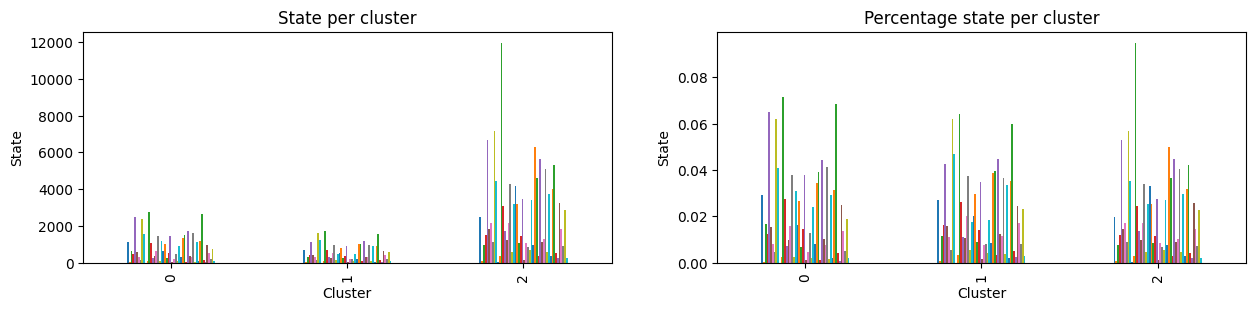

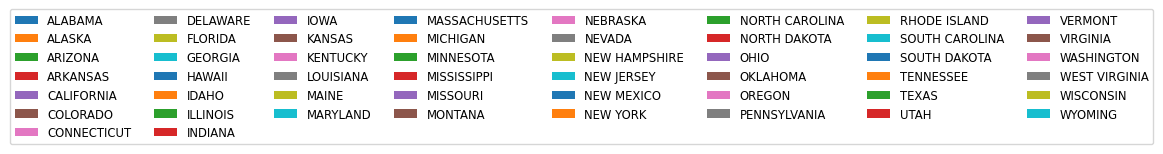

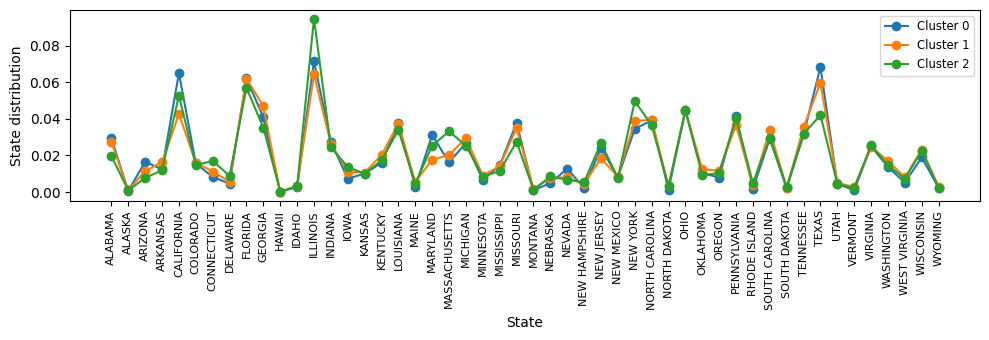

In [57]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [58]:
ic_xt_pct = pd.crosstab(best_model_orig.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                     80                    9   
1                                    691                   40   
2                                   5100                  290   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 0                  3   
1                                                 1                  2   
2                                                 3                 16   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                    9                             1   
1                                   72                             4   
2                                  177                            23   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                      5                  0         5   
1                                      5                127        11   
2                                     26                 65        46   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                        18  ...                  53   
1                                       120  ...                  45   
2                                       707  ...                 141   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     0               0          80       27   
1                                     0               1          94        1   
2                                     4               2         486        2   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                        5         443                0   
1                                       16         279                1   
2                                       50        1276                4   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                      31                       0  
1                                     109                       0  
2                                     995                       1  

[3 rows x 49 columns]

In [59]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.002077             0.000234                  0.000000   
1       0.026093             0.001510                  0.000038   
2       0.040485             0.002302                  0.000024   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000078     0.000234                      0.000026   
1           0.000076     0.002719                      0.000151   
2           0.000127     0.001405                      0.000183   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000130           0.000000  0.000130          0.000467  ...   
1       0.000189           0.004796  0.000415          0.004531  ...   
2       0.000206           0.000516  0.000365          0.005612  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001376      0.000000        0.000000    0.002077  0.000701   
1            0.001699      0.000000        0.000038    0.003550  0.000038   
2            0.001119      0.000032        0.000016    0.003858  0.000016   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000130    0.011500         0.000000        0.000805   
1         0.000604    0.010535         0.000038        0.004116   
2         0.000397    0.010129         0.000032        0.007899   

   UNLAWFUL_PURCHASE_SALE  
0                0.000000  
1                0.000000  
2                0.000008  

[3 rows x 49 columns]

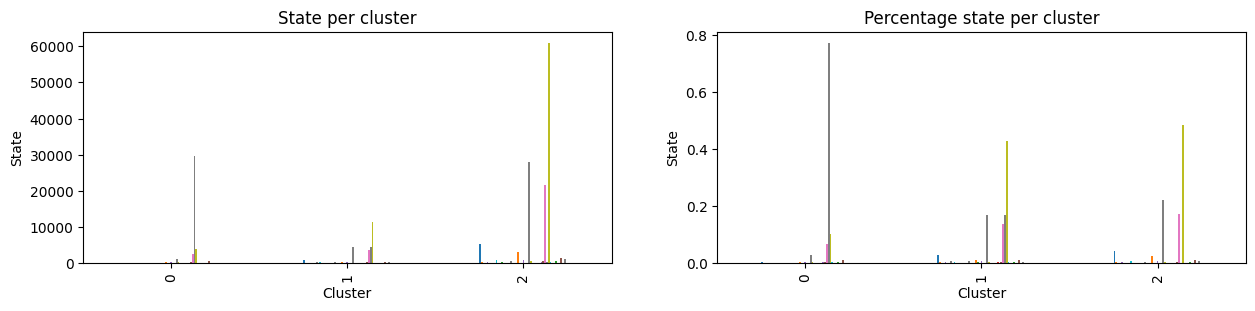

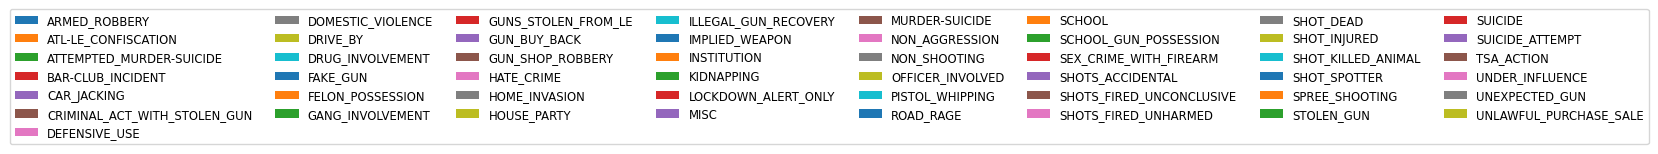

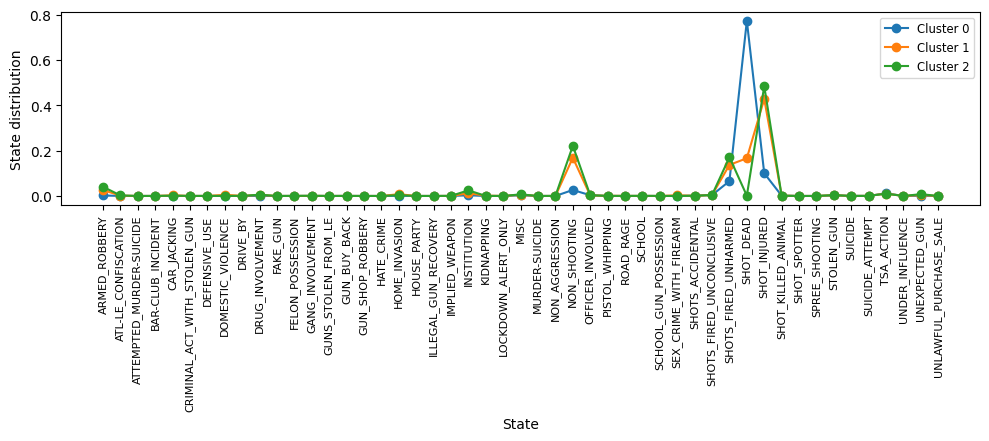

In [60]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Reduced original data clustring

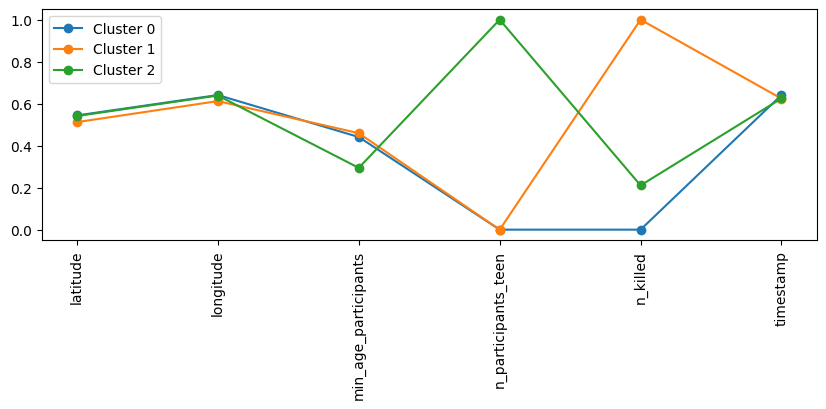

In [61]:
centers = best_model_r_orig.cluster_centers_
cols = reduced_orig.columns

plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

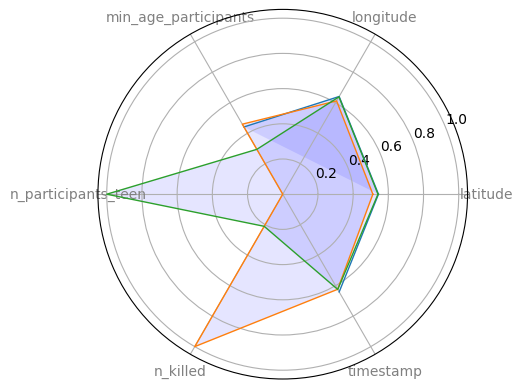

In [62]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=10) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [63]:
party_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0         76489       58831
1         25096       17298
2          7929        5334

In [64]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.565245    0.434755
1  0.591971    0.408029
2  0.597829    0.402171

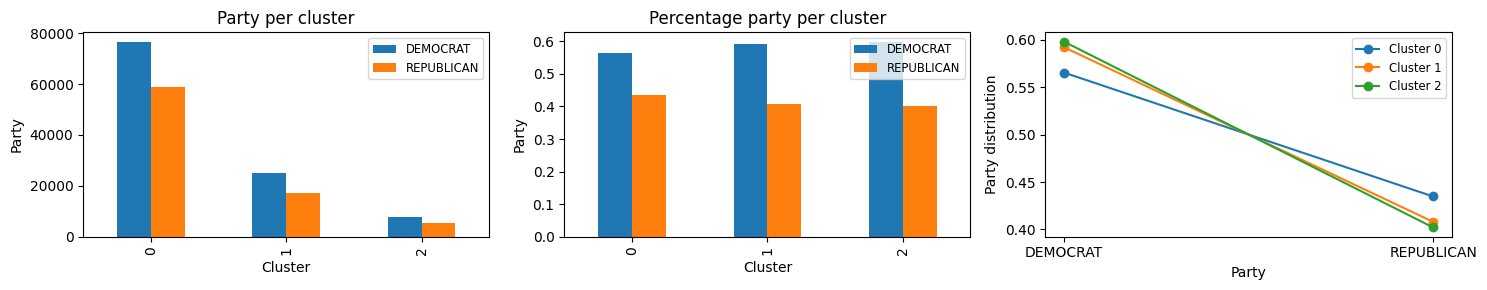

In [65]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [66]:
day_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         4990  4292  4384  4381  4495  4361  4376  4385  4277  4212  ...   
1         1482  1313  1346  1426  1399  1416  1374  1376  1339  1394  ...   
2          488   425   403   409   457   452   421   428   451   406  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0         4354  4346  4264  4633  4493  4514  4474  4227  4097  2699  
1         1329  1457  1368  1408  1435  1447  1415  1300  1309   878  
2          398   433   424   434   425   426   434   416   400   239  

[3 rows x 31 columns]

In [67]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.036876  0.031717  0.032397  0.032375  0.033218  0.032227  0.032338   
1  0.034958  0.030971  0.031750  0.033637  0.033000  0.033401  0.032410   
2  0.036794  0.032044  0.030385  0.030838  0.034457  0.034080  0.031742   

         8         9         10  ...        22        23        24        25  \
0  0.032405  0.031607  0.031126  ...  0.032176  0.032116  0.031510  0.034237   
1  0.032457  0.031585  0.032882  ...  0.031349  0.034368  0.032269  0.033212   
2  0.032270  0.034004  0.030611  ...  0.030008  0.032647  0.031969  0.032723   

         26        27        28        29        30        31  
0  0.033203  0.033358  0.033062  0.031237  0.030276  0.019945  
1  0.033849  0.034132  0.033377  0.030665  0.030877  0.020710  
2  0.032044  0.032119  0.032723  0.031365  0.030159  0.018020  

[3 rows x 31 columns]

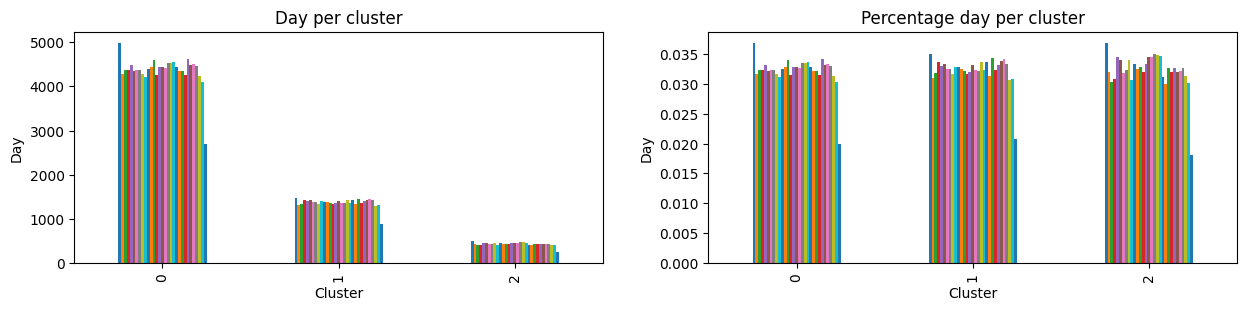

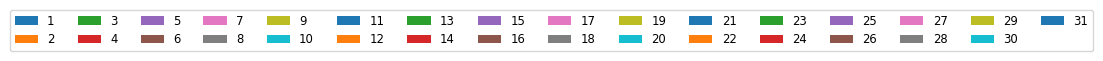

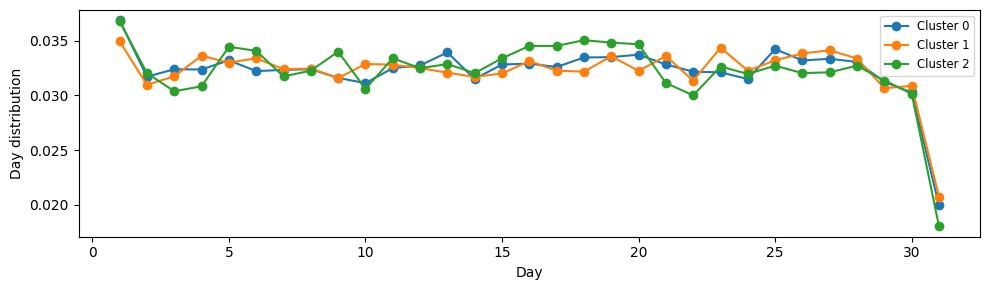

In [68]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [69]:
month_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['date_month'])
month_xt_pct

date_month     1      2      3      4      5      6      7      8      9   \
row_0                                                                       
0           13097  10781  13107  10415  10974  10231  11607  11904  11012   
1            4126   3361   3919   3099   3513   3333   3717   3641   3338   
2            1287   1101   1249   1026   1113   1000   1127   1134   1058   

date_month     10    11     12  
row_0                           
0           11306  9980  10906  
1            3420  3354   3573  
2            1092  1039   1037

In [70]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.096785  0.079670  0.096859  0.076966  0.081097  0.075606  0.085774   
1  0.097325  0.079280  0.092442  0.073100  0.082865  0.078620  0.087678   
2  0.097037  0.083013  0.094172  0.077358  0.083918  0.075398  0.084973   

         8         9         10        11        12  
0  0.087969  0.081377  0.083550  0.073751  0.080594  
1  0.085885  0.078738  0.080672  0.079115  0.084281  
2  0.085501  0.079771  0.082334  0.078338  0.078187

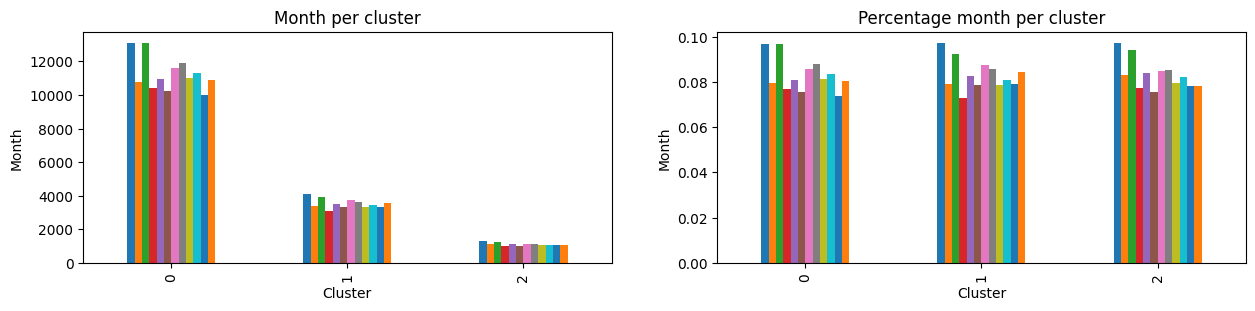

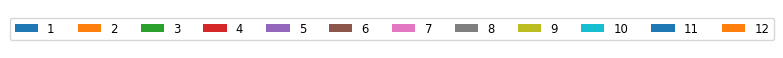

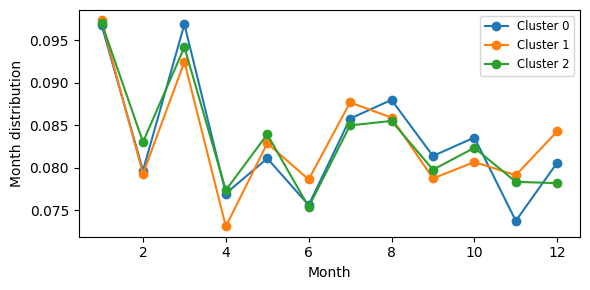

In [71]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [72]:
year_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0              23   21525   27366   38030   39705    8671
1              16    7817    9187   11253   11530    2591
2               2    2450    2869    3408    3697     837

In [73]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000170  0.159067  0.202232  0.281038  0.293416  0.064078
1  0.000377  0.184389  0.216705  0.265439  0.271972  0.061117
2  0.000151  0.184724  0.216316  0.256955  0.278745  0.063108

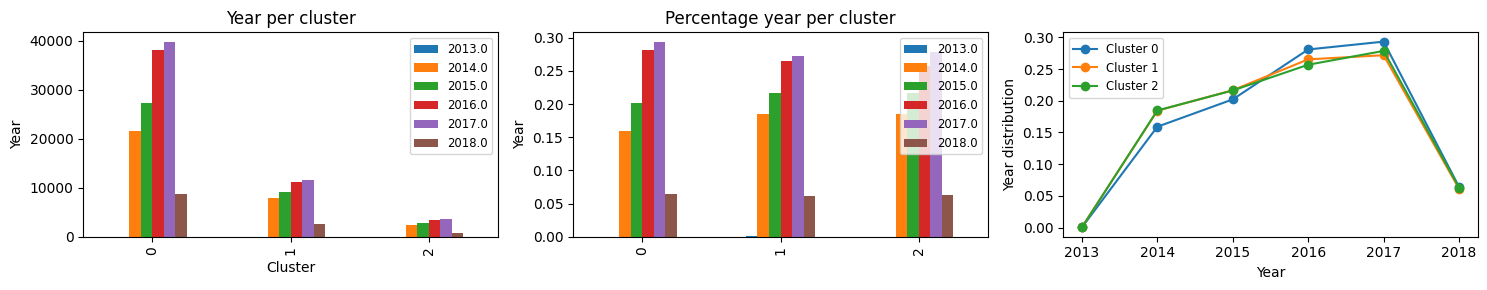

In [74]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [75]:
state_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0         2773     129     1055      1712        6975      2038         2290   
1         1308      23      741       527        2674       654          339   
2          256       5      114       173         641       173          146   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0          1114     7761     4970  ...           375       4305   5895   603   
1           188     2648     1772  ...            82       1346   3014   186   
2           133      820      514  ...            33        497    621    63   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0          320      3385        2043           1028       3063      330  
1           54      1051         586            244        823      101  
2           11       414         194             53        307       20  

[3 rows x 50 columns]

In [76]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.020492  0.000953  0.007796  0.012651    0.051544  0.015061     0.016923   
1  0.030853  0.000543  0.017479  0.012431    0.063075  0.015427     0.007996   
2  0.019302  0.000377  0.008595  0.013044    0.048330  0.013044     0.011008   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.008232  0.057353  0.036728  ...      0.002771   0.031813  0.043563   
1  0.004435  0.062462  0.041798  ...      0.001934   0.031750  0.071095   
2  0.010028  0.061826  0.038754  ...      0.002488   0.037473  0.046822   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004456  0.002365  0.025015    0.015098       0.007597   0.022635   
1  0.004387  0.001274  0.024791    0.013823       0.005756   0.019413   
2  0.004750  0.000829  0.031215    0.014627       0.003996   0.023147   

    WYOMING  
0  0.002439  
1  0.002382  
2  0.001508  

[3 rows x 50 columns]

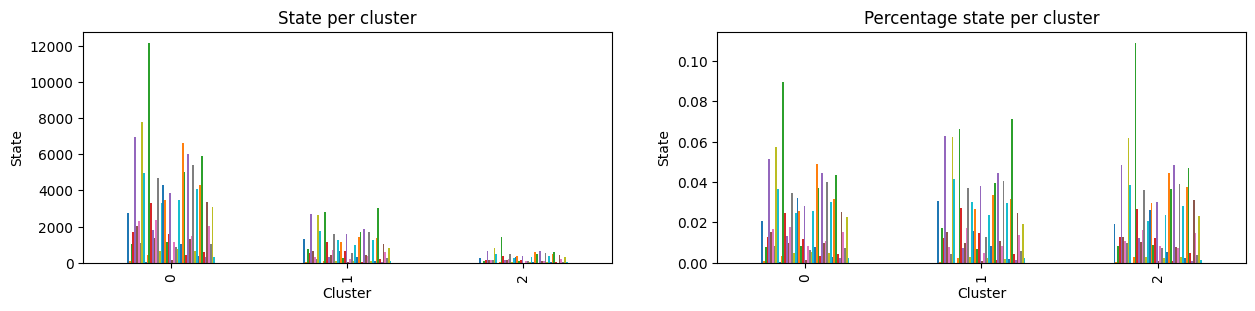

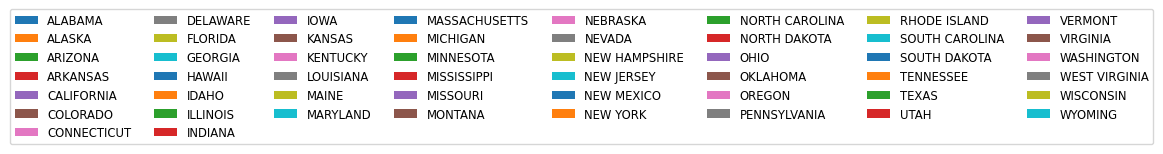

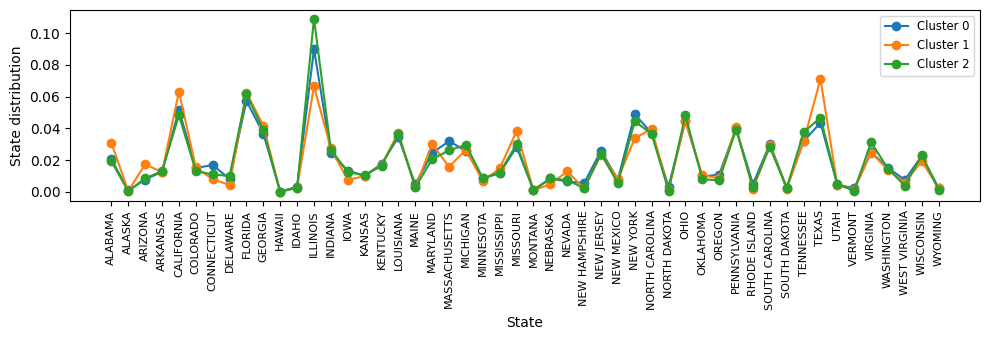

In [77]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [78]:
ic_xt_pct = pd.crosstab(best_model_r_orig.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                   5605                  307   
1                                     92                   12   
2                                    174                   20   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 4                 16   
1                                                 0                  3   
2                                                 0                  2   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                  232                            27   
1                                    8                             1   
2                                   18                             0   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                     29                181        53   
1                                      5                  3         4   
2                                      2                  8         5   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       800  ...                 162   
1                                        20  ...                  68   
2                                        25  ...                   9   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     4               3         527        2   
1                                     0               0          84       27   
2                                     0               0          49        1   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                       62        1376                5   
1                                        6         490                0   
2                                        3         132                0   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                    1035                       1  
1                                      32                       0  
2                                      68                       0  

[3 rows x 49 columns]

In [79]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.041420             0.002269                   0.00003   
1       0.002170             0.000283                   0.00000   
2       0.013119             0.001508                   0.00000   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000118     0.001714                      0.000200   
1           0.000071     0.000189                      0.000024   
2           0.000151     0.001357                      0.000000   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000214           0.001338  0.000392          0.005912  ...   
1       0.000118           0.000071  0.000094          0.000472  ...   
2       0.000151           0.000603  0.000377          0.001885  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001197       0.00003        0.000022    0.003894  0.000015   
1            0.001604       0.00000        0.000000    0.001981  0.000637   
2            0.000679       0.00000        0.000000    0.003694  0.000075   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000458    0.010168         0.000037        0.007649   
1         0.000142    0.011558         0.000000        0.000755   
2         0.000226    0.009952         0.000000        0.005127   

   UNLAWFUL_PURCHASE_SALE  
0                0.000007  
1                0.000000  
2                0.000000  

[3 rows x 49 columns]

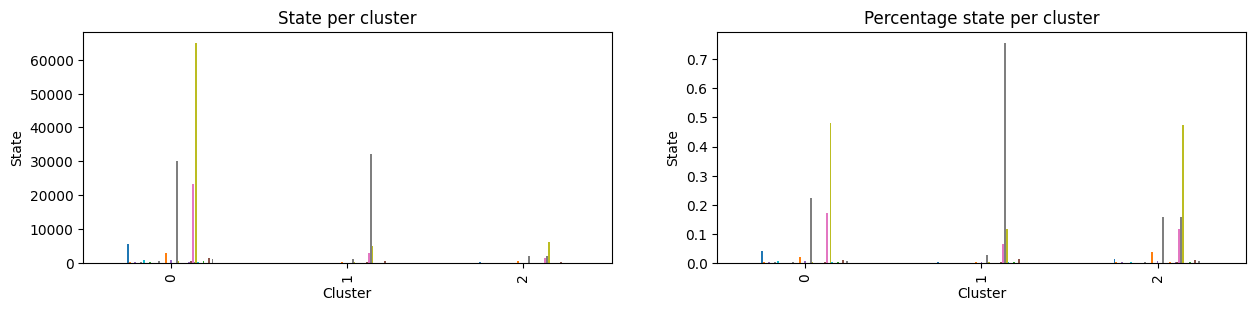

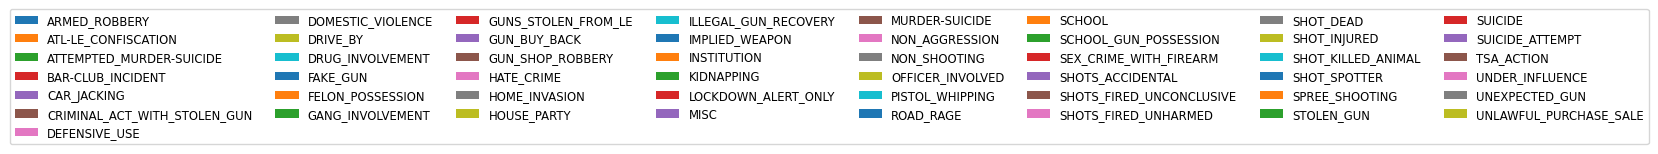

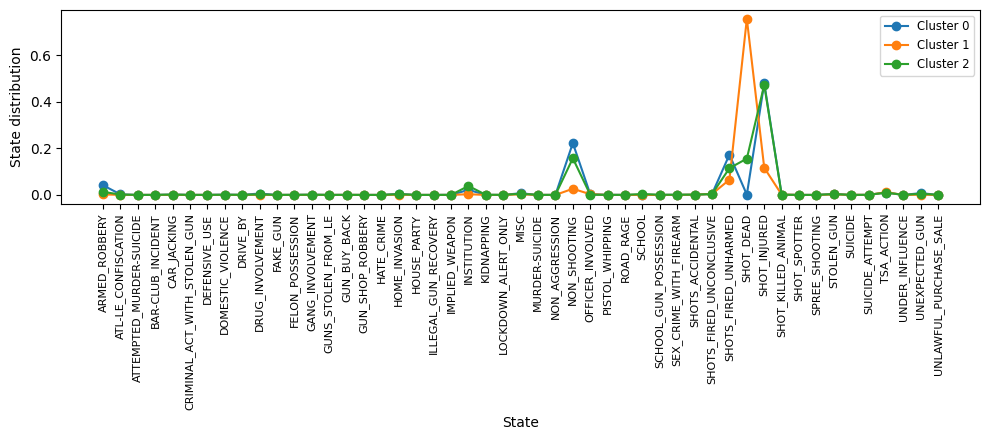

In [80]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Augmented data clustering

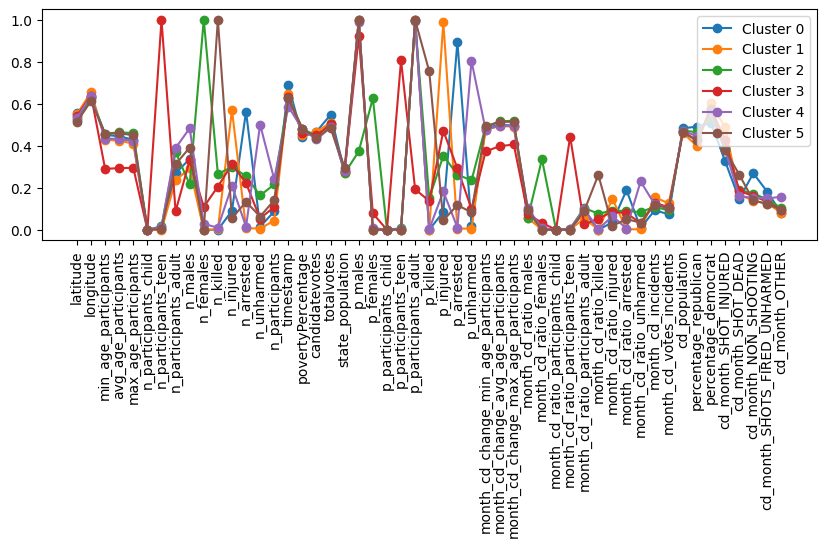

In [81]:
centers = best_model.cluster_centers_
cols = df.columns

plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

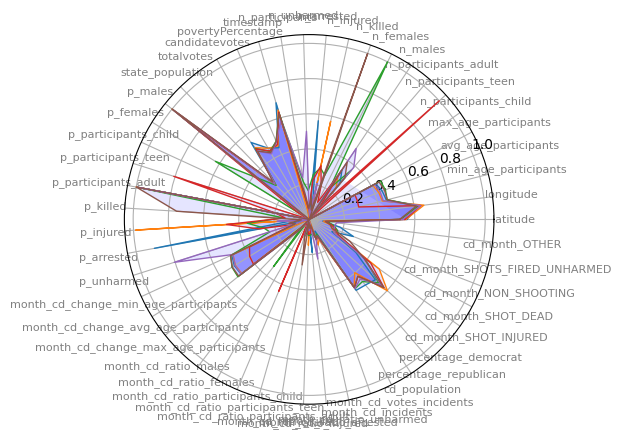

In [82]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=8) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [83]:
party_xt_pct = pd.crosstab(best_model.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0         18861       20387
1         27609       13903
2         12654       11440
3          7261        4829
4         21506       16688
5         21623       14216

In [84]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.480560    0.519440
1  0.665085    0.334915
2  0.525193    0.474807
3  0.600579    0.399421
4  0.563073    0.436927
5  0.603337    0.396663

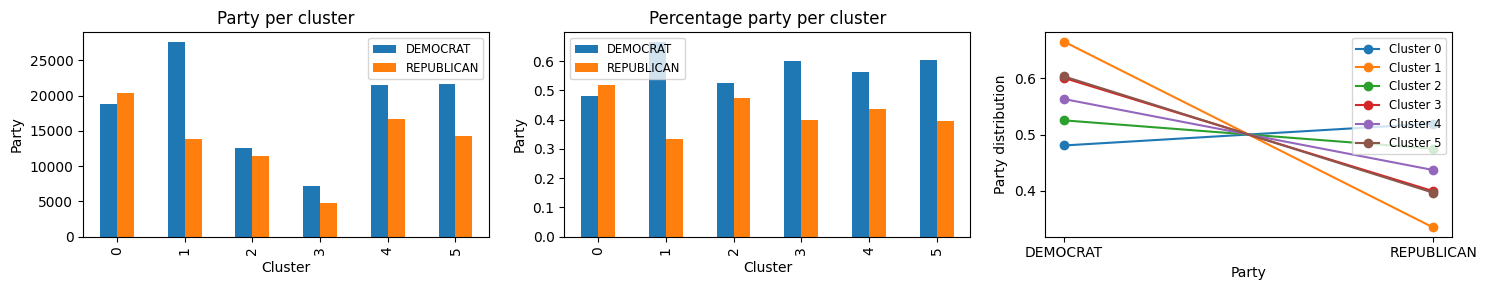

In [85]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [86]:
day_xt_pct = pd.crosstab(best_model.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         1522  1267  1271  1263  1307  1288  1252  1313  1300  1220  ...   
1         1525  1381  1368  1335  1362  1338  1369  1244  1296  1284  ...   
2          883   731   778   785   789   812   769   784   767   710  ...   
3          432   390   369   370   420   404   370   399   412   364  ...   
4         1345  1156  1225  1242  1284  1204  1257  1290  1171  1238  ...   
5         1253  1105  1122  1221  1189  1183  1154  1159  1121  1196  ...   

date_day    22    23    24    25    26    27    28    29    30   31  
row_0                                                                
0         1298  1258  1153  1217  1303  1307  1332  1182  1168  801  
1         1306  1349  1377  1485  1389  1378  1352  1310  1266  850  
2          794   788   789   852   819   828   802   722   766  479  
3          357   398   379   402   392   392   409   370   362  208  
4         1201  1203  1214  1344  1257  1247  1229  1263  1159  731  
5         1125  1240  1144  1175  1193  1235  1199  1096  1085  747  

[6 rows x 31 columns]

In [87]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.038779  0.032282  0.032384  0.032180  0.033301  0.032817  0.031900   
1  0.036736  0.033267  0.032954  0.032159  0.032810  0.032232  0.032978   
2  0.036648  0.030340  0.032290  0.032581  0.032747  0.033701  0.031917   
3  0.035732  0.032258  0.030521  0.030604  0.034739  0.033416  0.030604   
4  0.035215  0.030267  0.032073  0.032518  0.033618  0.031523  0.032911   
5  0.034962  0.030832  0.031307  0.034069  0.033176  0.033009  0.032200   

         8         9         10  ...        22        23        24        25  \
0  0.033454  0.033123  0.031084  ...  0.033072  0.032053  0.029377  0.031008   
1  0.029967  0.031220  0.030931  ...  0.031461  0.032497  0.033171  0.035773   
2  0.032539  0.031834  0.029468  ...  0.032954  0.032705  0.032747  0.035362   
3  0.033002  0.034078  0.030108  ...  0.029529  0.032920  0.031348  0.033251   
4  0.033775  0.030659  0.032413  ...  0.031445  0.031497  0.031785  0.035189   
5  0.032339  0.031279  0.033371  ...  0.031390  0.034599  0.031921  0.032786   

         26        27        28        29        30        31  
0  0.033199  0.033301  0.033938  0.030116  0.029759  0.020409  
1  0.033460  0.033195  0.032569  0.031557  0.030497  0.020476  
2  0.033992  0.034365  0.033286  0.029966  0.031792  0.019880  
3  0.032423  0.032423  0.033830  0.030604  0.029942  0.017204  
4  0.032911  0.032649  0.032178  0.033068  0.030345  0.019139  
5  0.033288  0.034460  0.033455  0.030581  0.030274  0.020843  

[6 rows x 31 columns]

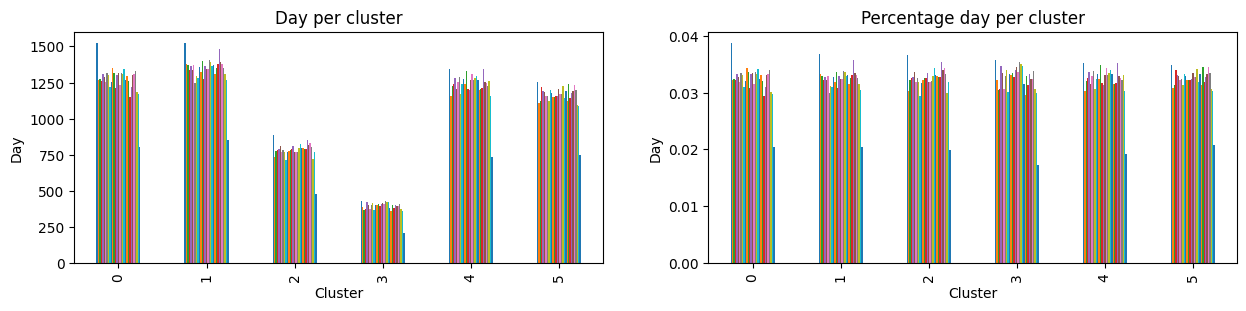

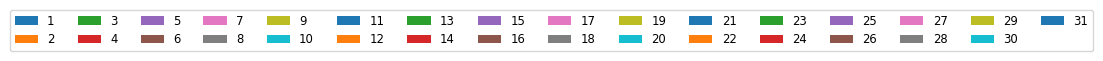

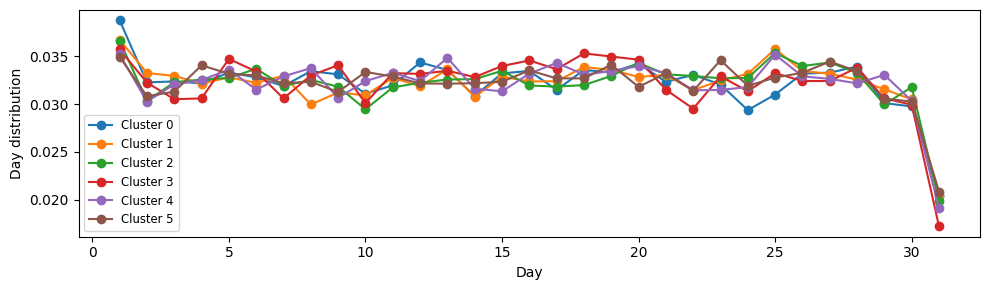

In [88]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [89]:
month_xt_pct = pd.crosstab(best_model.labels_, df_c['date_month'])
month_xt_pct

date_month    1     2     3     4     5     6     7     8     9     10    11  \
row_0                                                                          
0           3976  3462  4244  3086  3084  2879  3040  3198  3038  2982  2848   
1           3859  2982  3800  3189  3509  3259  3742  3791  3414  3576  3075   
2           2356  1979  2309  1874  1959  1840  2103  2056  1930  1977  1764   
3           1157  1024  1128   943  1027   891  1010  1042   965   996   940   
4           3683  2998  3502  2852  3034  2874  3380  3473  3222  3419  2901   
5           3479  2798  3292  2596  2987  2821  3176  3119  2839  2868  2845   

date_month    12  
row_0             
0           3411  
1           3316  
2           1947  
3            967  
4           2856  
5           3019

In [90]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.101305  0.088208  0.108133  0.078628  0.078577  0.073354  0.077456   
1  0.092961  0.071835  0.091540  0.076821  0.084530  0.078507  0.090143   
2  0.097784  0.082137  0.095833  0.077779  0.081307  0.076368  0.087283   
3  0.095699  0.084698  0.093300  0.077998  0.084946  0.073697  0.083540   
4  0.096429  0.078494  0.091690  0.074671  0.079437  0.075247  0.088496   
5  0.097073  0.078071  0.091855  0.072435  0.083345  0.078713  0.088619   

         8         9         10        11        12  
0  0.081482  0.077405  0.075978  0.072564  0.086909  
1  0.091323  0.082241  0.086144  0.074075  0.079881  
2  0.085332  0.080103  0.082054  0.073213  0.080809  
3  0.086187  0.079818  0.082382  0.077750  0.079983  
4  0.090931  0.084359  0.089517  0.075954  0.074776  
5  0.087028  0.079215  0.080025  0.079383  0.084238

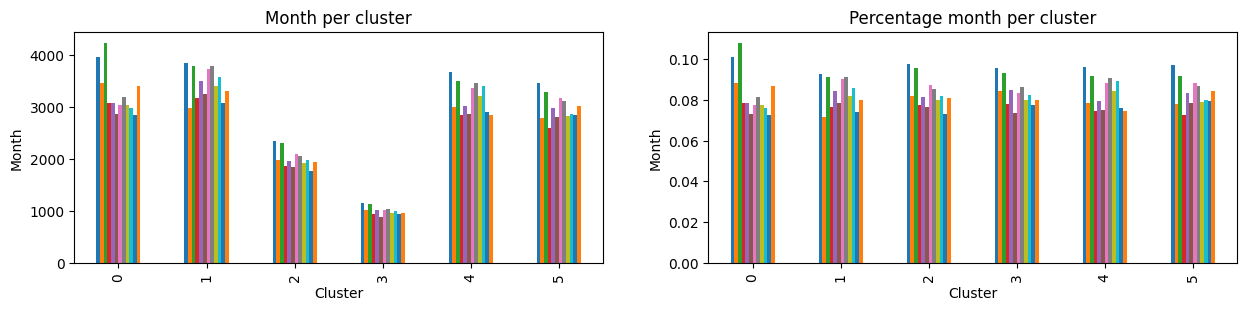

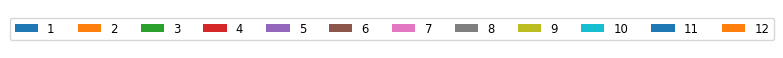

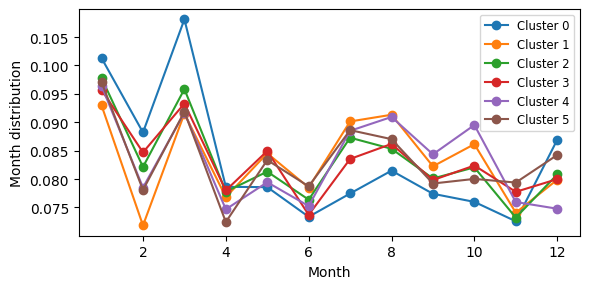

In [91]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [92]:
year_xt_pct = pd.crosstab(best_model.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0               4    2164    8882   11853   13253    3092
1              10    6194    8325   12139   12322    2522
2               4    4134    5161    6631    6698    1466
3               2    2024    2664    3136    3479     785
4               7   10754    6584    9429    9382    2038
5              14    6522    7806    9503    9798    2196

In [93]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000102  0.055137  0.226305  0.302003  0.337673  0.078781
1  0.000241  0.149210  0.200544  0.292421  0.296830  0.060754
2  0.000166  0.171578  0.214203  0.275214  0.277995  0.060845
3  0.000165  0.167411  0.220347  0.259388  0.287758  0.064930
4  0.000183  0.281563  0.172383  0.246871  0.245641  0.053359
5  0.000391  0.181981  0.217807  0.265158  0.273389  0.061274

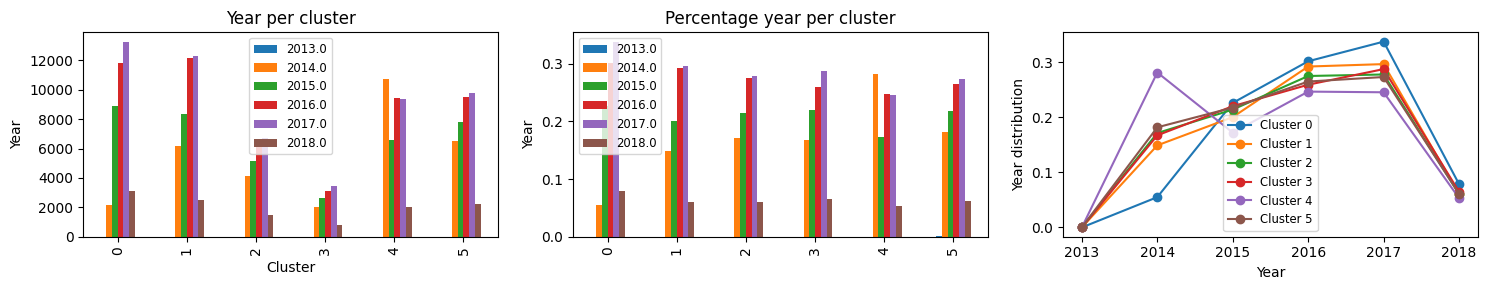

In [94]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [95]:
state_xt_pct = pd.crosstab(best_model.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0          621      24      274       465        2519       688          926   
1         1082      24      335       478        1885       477          604   
2          663      20      280       395        1032       393          270   
3          237       3      103       164         592       157          127   
4          669      65      309       468        1929       593          548   
5         1065      21      609       442        2333       557          300   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0           302     2531     1121  ...           160       1035   1674   209   
1           414     2026     1420  ...            75       1532   1334   128   
2           128     1497     1123  ...            57        850   1461   120   
3           126      725      456  ...            28        459    564    57   
4           294     2214     1687  ...           102       1157   2061   181   
5           171     2236     1449  ...            68       1115   2436   157   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0          134       765         790            418        725      136  
1           35      1373         440            210       1103       64  
2           68       584         412            199        543       74  
3            9       403         171             47        277       18  
4          100       849         514            262        859       77  
5           39       876         496            189        686       82  

[6 rows x 50 columns]

In [96]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.015822  0.000611  0.006981  0.011848    0.064182  0.017530     0.023594   
1  0.026065  0.000578  0.008070  0.011515    0.045409  0.011491     0.014550   
2  0.027517  0.000830  0.011621  0.016394    0.042832  0.016311     0.011206   
3  0.019603  0.000248  0.008519  0.013565    0.048966  0.012986     0.010505   
4  0.017516  0.001702  0.008090  0.012253    0.050505  0.015526     0.014348   
5  0.029716  0.000586  0.016993  0.012333    0.065097  0.015542     0.008371   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.007695  0.064487  0.028562  ...      0.004077   0.026371  0.042652   
1  0.009973  0.048805  0.034207  ...      0.001807   0.036905  0.032135   
2  0.005313  0.062132  0.046609  ...      0.002366   0.035278  0.060638   
3  0.010422  0.059967  0.037717  ...      0.002316   0.037965  0.046650   
4  0.007698  0.057967  0.044169  ...      0.002671   0.030293  0.053961   
5  0.004771  0.062390  0.040431  ...      0.001897   0.031111  0.067971   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.005325  0.003414  0.019491    0.020128       0.010650   0.018472   
1  0.003083  0.000843  0.033075    0.010599       0.005059   0.026571   
2  0.004980  0.002822  0.024238    0.017100       0.008259   0.022537   
3  0.004715  0.000744  0.033333    0.014144       0.003888   0.022911   
4  0.004739  0.002618  0.022229    0.013458       0.006860   0.022490   
5  0.004381  0.001088  0.024443    0.013840       0.005274   0.019141   

    WYOMING  
0  0.003465  
1  0.001542  
2  0.003071  
3  0.001489  
4  0.002016  
5  0.002288  

[6 rows x 50 columns]

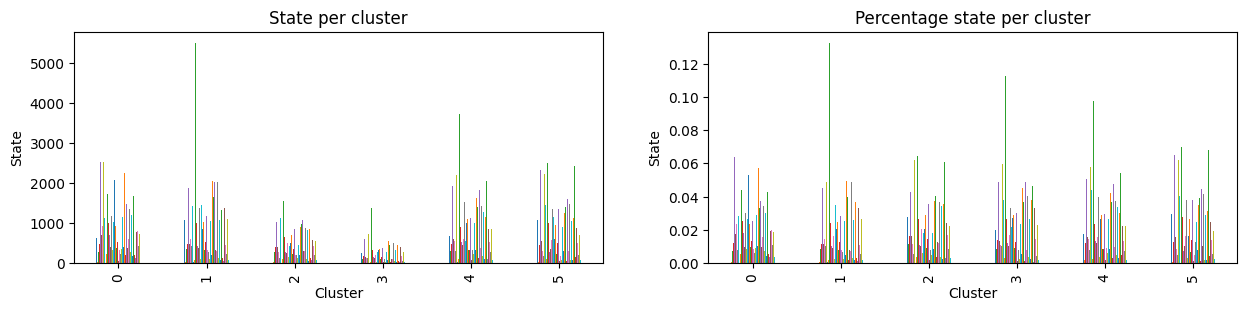

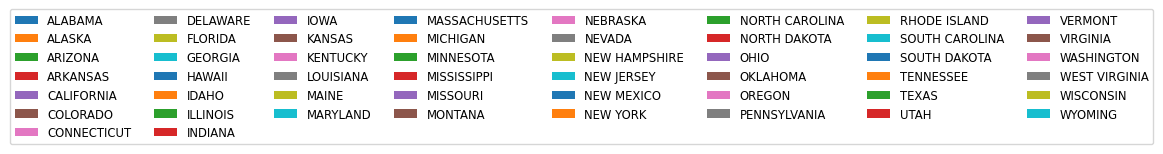

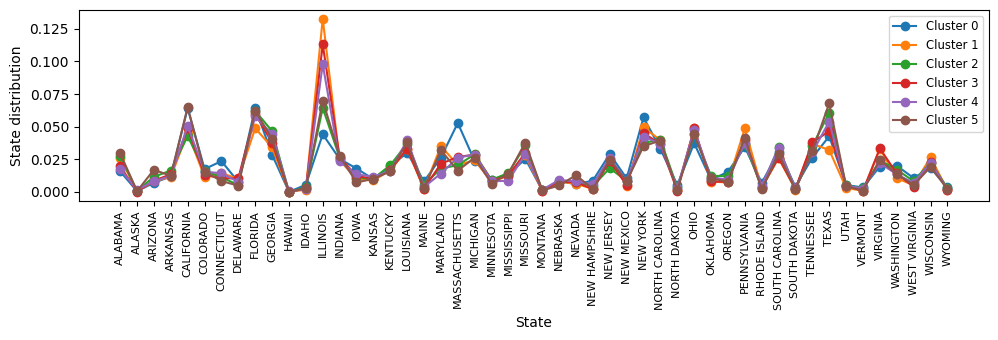

In [97]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [98]:
ic_xt_pct = pd.crosstab(best_model.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                     92                   40   
1                                    121                   13   
2                                    505                   37   
3                                     90                   15   
4                                   4984                  225   
5                                     79                    9   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 2                  2   
1                                                 0                  3   
2                                                 1                  1   
3                                                 0                  1   
4                                                 1                 12   
5                                                 0                  2   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                   17                             2   
1                                    6                             2   
2                                   53                             4   
3                                    9                             0   
4                                  165                            19   
5                                    8                             1   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                      4                  8         8   
1                                      0                  3        12   
2                                      5                120        10   
3                                      1                  2         4   
4                                     21                 59        25   
5                                      5                  0         3   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       113  ...                  43   
1                                        30  ...                  31   
2                                        96  ...                  42   
3                                        16  ...                   8   
4                                       573  ...                  64   
5                                        17  ...                  51   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     1               1          95        1   
1                                     1               0          75        0   
2                                     0               1          75        1   
3                                     0               0          44        1   
4                                     2               1         303        1   
5                                     0               0          68       26   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                       16         396                4   
1                                        8         394                0   
2                                       16         253                0   
3                                        1         123                0   
4                                       25         421  

In [99]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.002344             0.001019                  0.000051   
1       0.002915             0.000313                  0.000000   
2       0.020960             0.001536                  0.000042   
3       0.007444             0.001241                  0.000000   
4       0.130492             0.005891                  0.000026   
5       0.002204             0.000251                  0.000000   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000051     0.000433                      0.000051   
1           0.000072     0.000145                      0.000048   
2           0.000042     0.002200                      0.000166   
3           0.000083     0.000744                      0.000000   
4           0.000314     0.004320                      0.000497   
5           0.000056     0.000223                      0.000028   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000102           0.000204  0.000204          0.002879  ...   
1       0.000000           0.000072  0.000289          0.000723  ...   
2       0.000208           0.004980  0.000415          0.003984  ...   
3       0.000083           0.000165  0.000331          0.001323  ...   
4       0.000550           0.001545  0.000655          0.015002  ...   
5       0.000140           0.000000  0.000084          0.000474  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001096      0.000025        0.000025    0.002421  0.000025   
1            0.000747      0.000024        0.000000    0.001807  0.000000   
2            0.001743      0.000000        0.000042    0.003113  0.000042   
3            0.000662      0.000000        0.000000    0.003639  0.000083   
4            0.001676      0.000052        0.000026    0.007933  0.000026   
5            0.001423      0.000000        0.000000    0.001897  0.000725   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000408    0.010090         0.000102        0.001707   
1         0.000193    0.009491         0.000000        0.000771   
2         0.000664    0.010501         0.000000        0.004067   
3         0.000083    0.010174         0.000000        0.004880   
4         0.000655    0.011023         0.000026        0.022255   
5         0.000140    0.011468         0.000000        0.000809   

   UNLAWFUL_PURCHASE_SALE  
0                0.000025  
1                0.000000  
2                0.000000  
3                0.000000  
4                0.000000  
5                0.000000  

[6 rows x 49 columns]

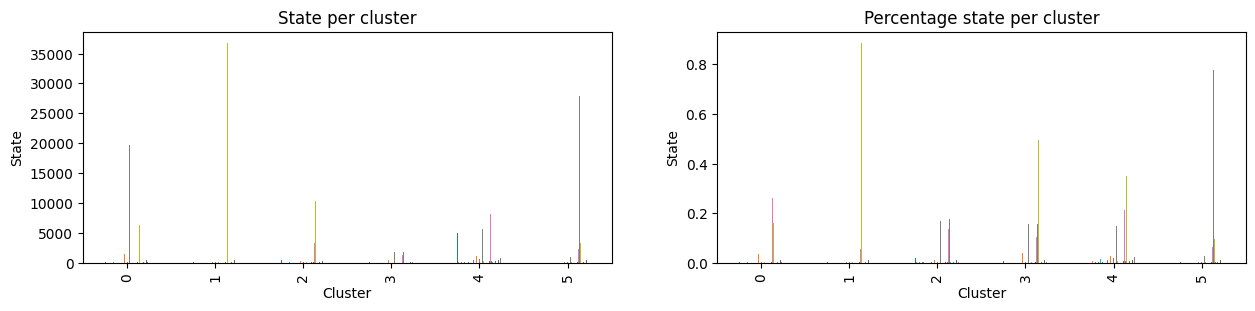

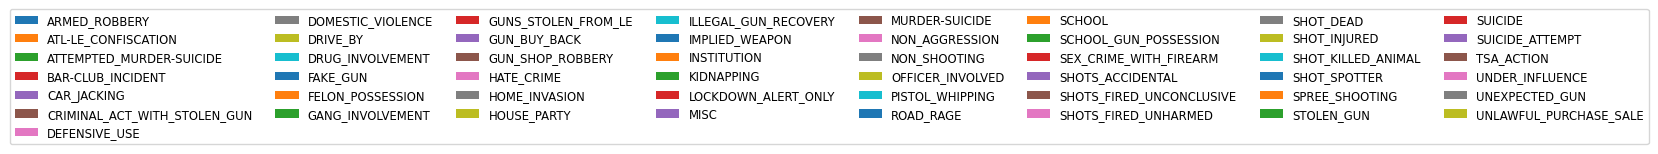

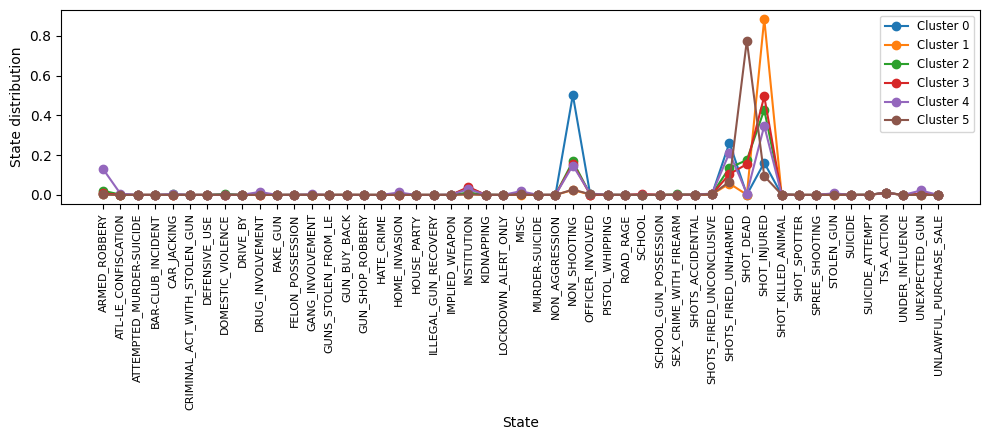

In [100]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Reduced augmented data clustering

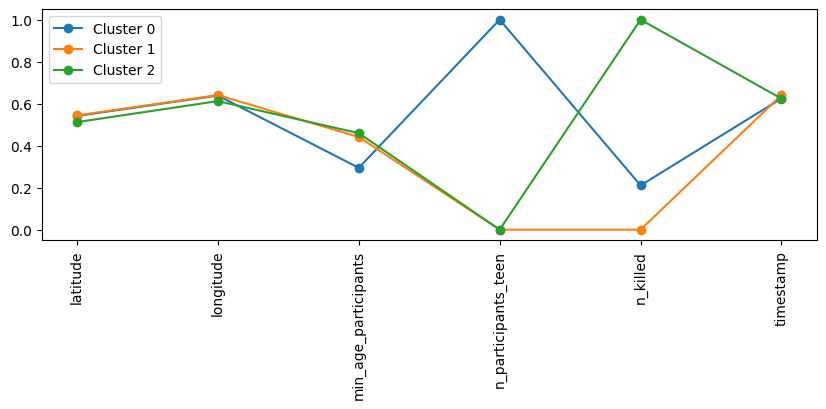

In [101]:
centers = best_model_r.cluster_centers_
cols = reduced.columns

plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

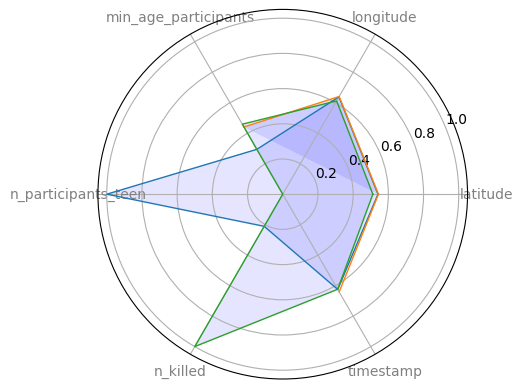

In [102]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=10) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [103]:
party_xt_pct = pd.crosstab(best_model_r.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0          7929        5334
1         76489       58831
2         25096       17298

In [104]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.597829    0.402171
1  0.565245    0.434755
2  0.591971    0.408029

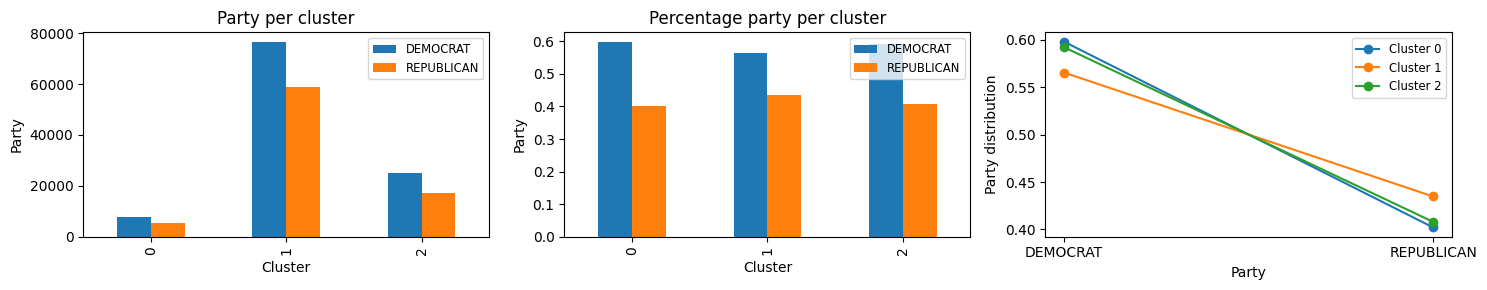

In [105]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [106]:
day_xt_pct = pd.crosstab(best_model_r.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0          488   425   403   409   457   452   421   428   451   406  ...   
1         4990  4292  4384  4381  4495  4361  4376  4385  4277  4212  ...   
2         1482  1313  1346  1426  1399  1416  1374  1376  1339  1394  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0          398   433   424   434   425   426   434   416   400   239  
1         4354  4346  4264  4633  4493  4514  4474  4227  4097  2699  
2         1329  1457  1368  1408  1435  1447  1415  1300  1309   878  

[3 rows x 31 columns]

In [107]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.036794  0.032044  0.030385  0.030838  0.034457  0.034080  0.031742   
1  0.036876  0.031717  0.032397  0.032375  0.033218  0.032227  0.032338   
2  0.034958  0.030971  0.031750  0.033637  0.033000  0.033401  0.032410   

         8         9         10  ...        22        23        24        25  \
0  0.032270  0.034004  0.030611  ...  0.030008  0.032647  0.031969  0.032723   
1  0.032405  0.031607  0.031126  ...  0.032176  0.032116  0.031510  0.034237   
2  0.032457  0.031585  0.032882  ...  0.031349  0.034368  0.032269  0.033212   

         26        27        28        29        30        31  
0  0.032044  0.032119  0.032723  0.031365  0.030159  0.018020  
1  0.033203  0.033358  0.033062  0.031237  0.030276  0.019945  
2  0.033849  0.034132  0.033377  0.030665  0.030877  0.020710  

[3 rows x 31 columns]

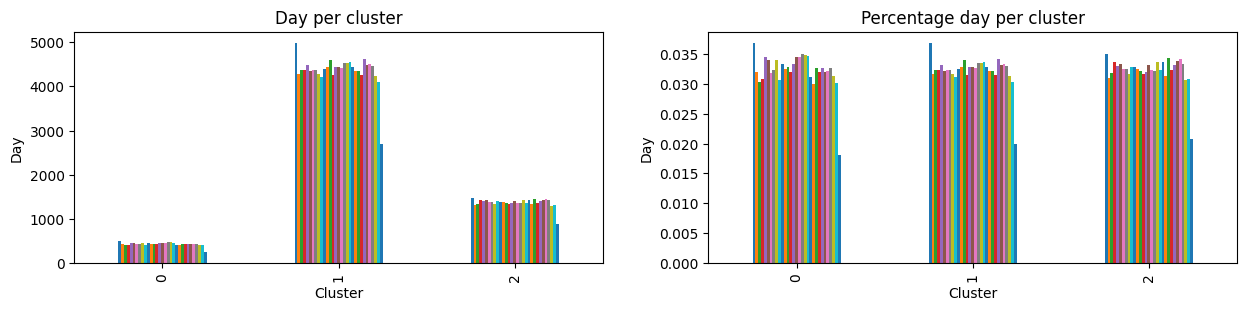

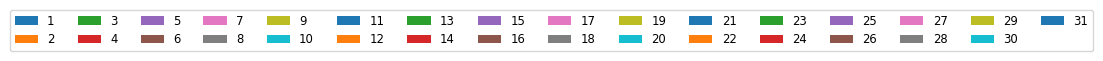

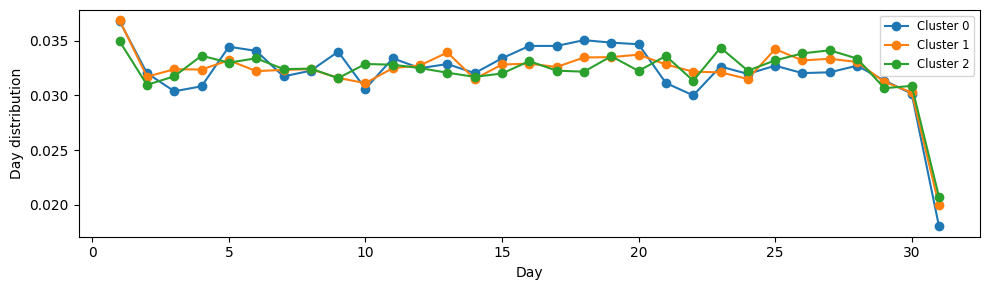

In [108]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [109]:
month_xt_pct = pd.crosstab(best_model_r.labels_, df_c['date_month'])
month_xt_pct

date_month     1      2      3      4      5      6      7      8      9   \
row_0                                                                       
0            1287   1101   1249   1026   1113   1000   1127   1134   1058   
1           13097  10781  13107  10415  10974  10231  11607  11904  11012   
2            4126   3361   3919   3099   3513   3333   3717   3641   3338   

date_month     10    11     12  
row_0                           
0            1092  1039   1037  
1           11306  9980  10906  
2            3420  3354   3573

In [110]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.097037  0.083013  0.094172  0.077358  0.083918  0.075398  0.084973   
1  0.096785  0.079670  0.096859  0.076966  0.081097  0.075606  0.085774   
2  0.097325  0.079280  0.092442  0.073100  0.082865  0.078620  0.087678   

         8         9         10        11        12  
0  0.085501  0.079771  0.082334  0.078338  0.078187  
1  0.087969  0.081377  0.083550  0.073751  0.080594  
2  0.085885  0.078738  0.080672  0.079115  0.084281

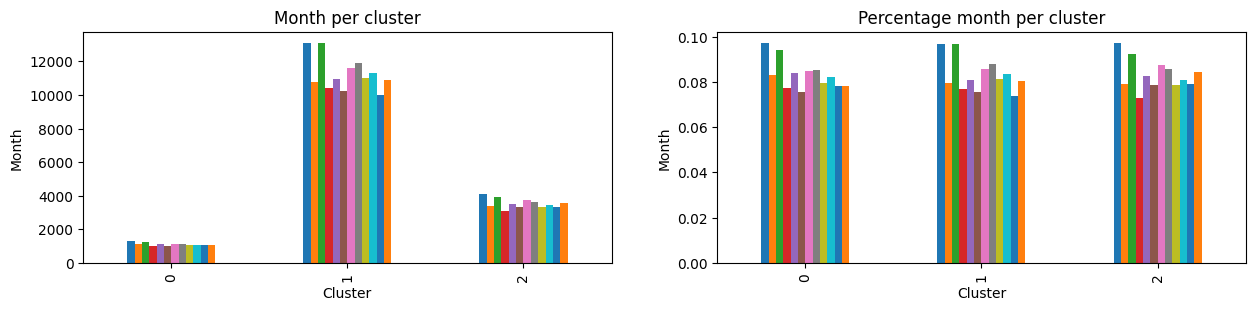

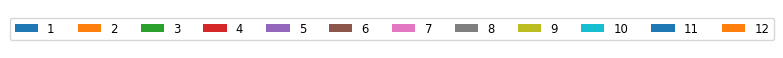

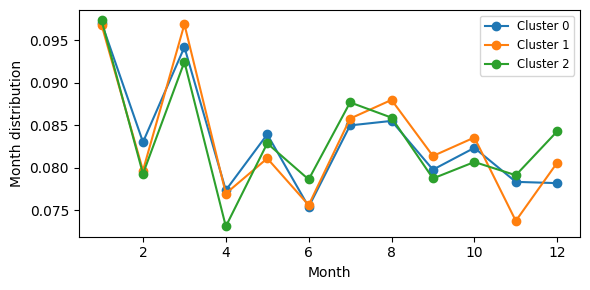

In [111]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [112]:
year_xt_pct = pd.crosstab(best_model_r.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0               2    2450    2869    3408    3697     837
1              23   21525   27366   38030   39705    8671
2              16    7817    9187   11253   11530    2591

In [113]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000151  0.184724  0.216316  0.256955  0.278745  0.063108
1  0.000170  0.159067  0.202232  0.281038  0.293416  0.064078
2  0.000377  0.184389  0.216705  0.265439  0.271972  0.061117

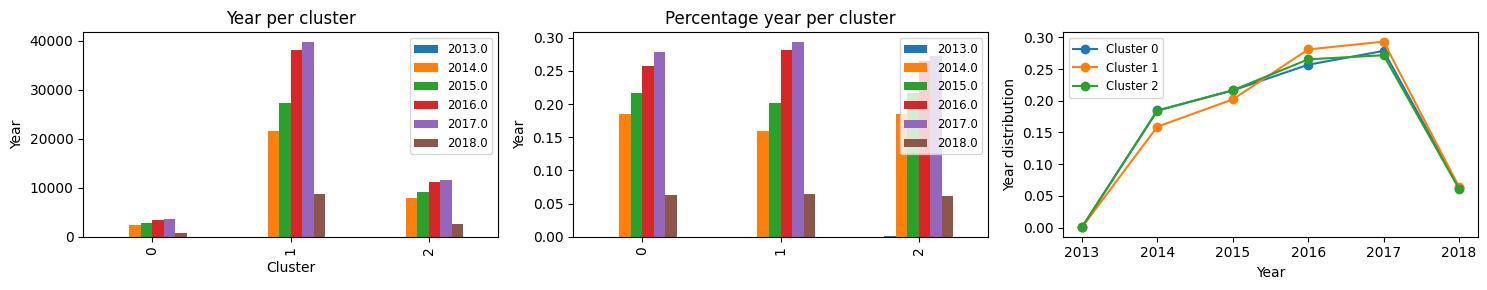

In [114]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [115]:
state_xt_pct = pd.crosstab(best_model_r.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0          256       5      114       173         641       173          146   
1         2773     129     1055      1712        6975      2038         2290   
2         1308      23      741       527        2674       654          339   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0           133      820      514  ...            33        497    621    63   
1          1114     7761     4970  ...           375       4305   5895   603   
2           188     2648     1772  ...            82       1346   3014   186   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0           11       414         194             53        307       20  
1          320      3385        2043           1028       3063      330  
2           54      1051         586            244        823      101  

[3 rows x 50 columns]

In [116]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.019302  0.000377  0.008595  0.013044    0.048330  0.013044     0.011008   
1  0.020492  0.000953  0.007796  0.012651    0.051544  0.015061     0.016923   
2  0.030853  0.000543  0.017479  0.012431    0.063075  0.015427     0.007996   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.010028  0.061826  0.038754  ...      0.002488   0.037473  0.046822   
1  0.008232  0.057353  0.036728  ...      0.002771   0.031813  0.043563   
2  0.004435  0.062462  0.041798  ...      0.001934   0.031750  0.071095   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004750  0.000829  0.031215    0.014627       0.003996   0.023147   
1  0.004456  0.002365  0.025015    0.015098       0.007597   0.022635   
2  0.004387  0.001274  0.024791    0.013823       0.005756   0.019413   

    WYOMING  
0  0.001508  
1  0.002439  
2  0.002382  

[3 rows x 50 columns]

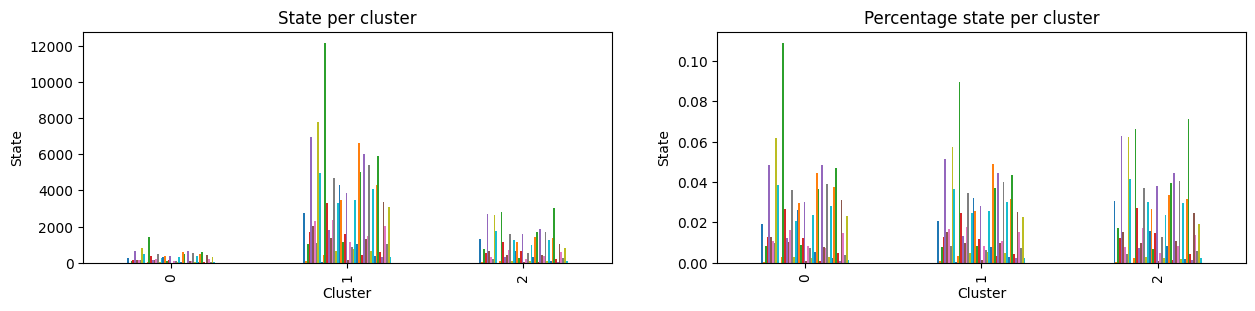

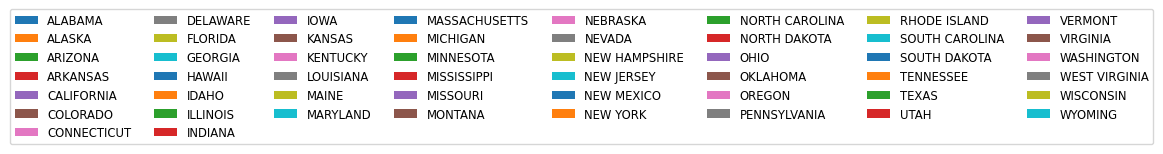

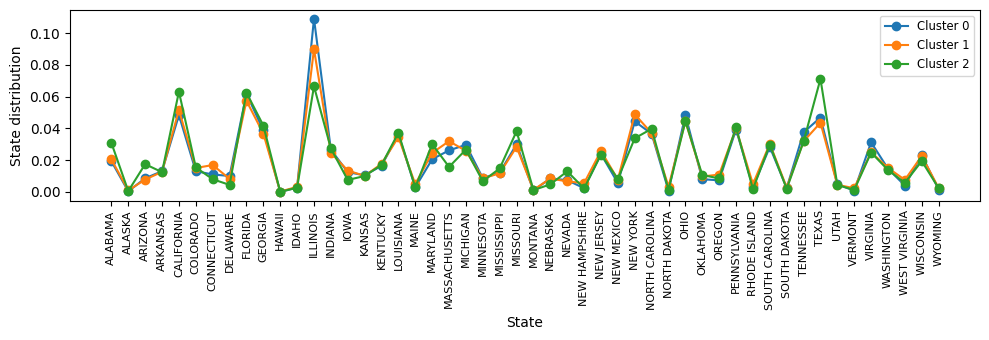

In [117]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [118]:
ic_xt_pct = pd.crosstab(best_model_r.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                    174                   20   
1                                   5605                  307   
2                                     92                   12   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 0                  2   
1                                                 4                 16   
2                                                 0                  3   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                   18                             0   
1                                  232                            27   
2                                    8                             1   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                      2                  8         5   
1                                     29                181        53   
2                                      5                  3         4   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                        25  ...                   9   
1                                       800  ...                 162   
2                                        20  ...                  68   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     0               0          49        1   
1                                     4               3         527        2   
2                                     0               0          84       27   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                        3         132                0   
1                                       62        1376                5   
2                                        6         490                0   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                      68                       0  
1                                    1035                       1  
2                                      32                       0  

[3 rows x 49 columns]

In [119]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.013119             0.001508                   0.00000   
1       0.041420             0.002269                   0.00003   
2       0.002170             0.000283                   0.00000   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000151     0.001357                      0.000000   
1           0.000118     0.001714                      0.000200   
2           0.000071     0.000189                      0.000024   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000151           0.000603  0.000377          0.001885  ...   
1       0.000214           0.001338  0.000392          0.005912  ...   
2       0.000118           0.000071  0.000094          0.000472  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.000679       0.00000        0.000000    0.003694  0.000075   
1            0.001197       0.00003        0.000022    0.003894  0.000015   
2            0.001604       0.00000        0.000000    0.001981  0.000637   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000226    0.009952         0.000000        0.005127   
1         0.000458    0.010168         0.000037        0.007649   
2         0.000142    0.011558         0.000000        0.000755   

   UNLAWFUL_PURCHASE_SALE  
0                0.000000  
1                0.000007  
2                0.000000  

[3 rows x 49 columns]

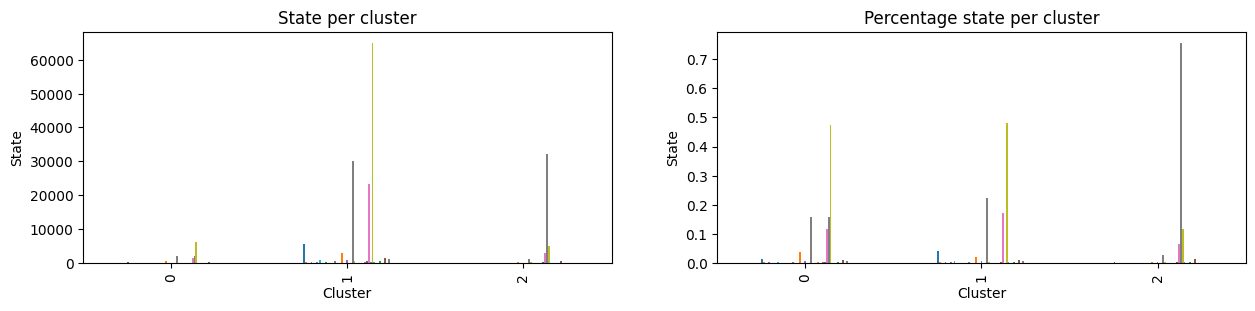

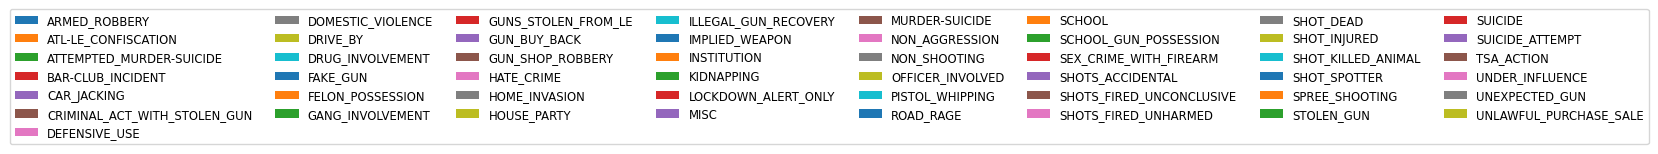

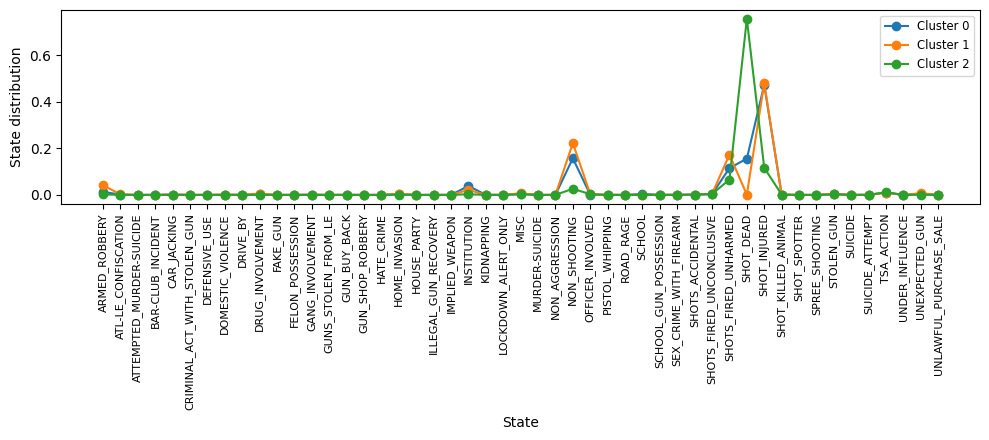

In [120]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Only indicators clustering

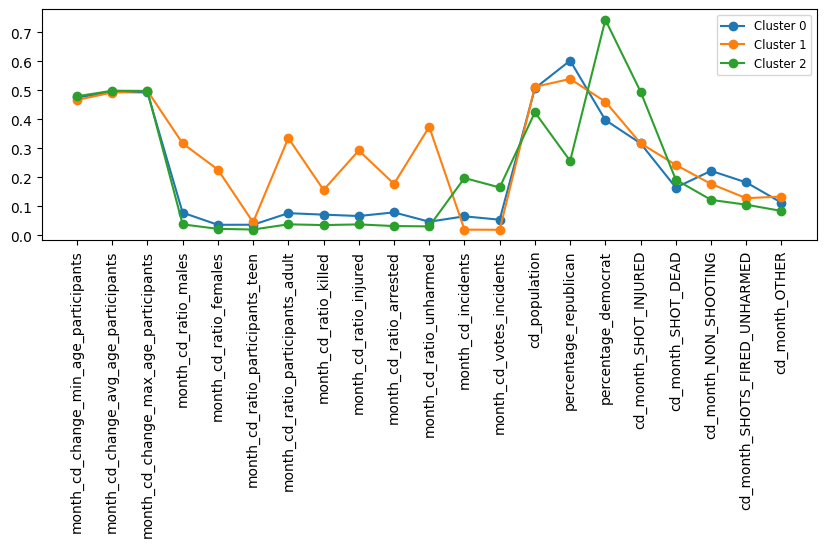

In [161]:
centers = best_model_ind.cluster_centers_
cols = df_ind.columns

plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend(fontsize='small', ncol=1)
plt.show()

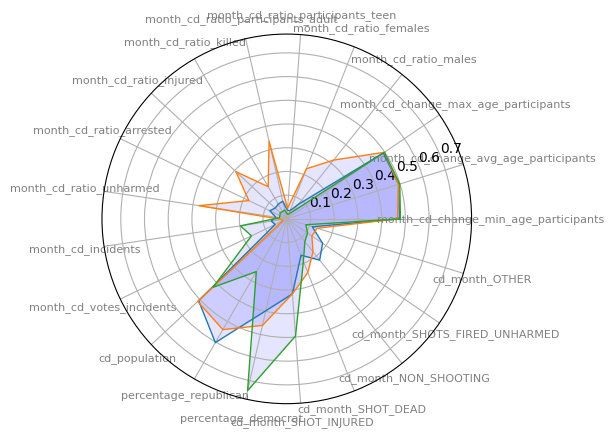

In [122]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=8) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [123]:
party_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0         19106       70244
1          5996        9911
2         84412        1308

In [124]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.213833    0.786167
1  0.376941    0.623059
2  0.984741    0.015259

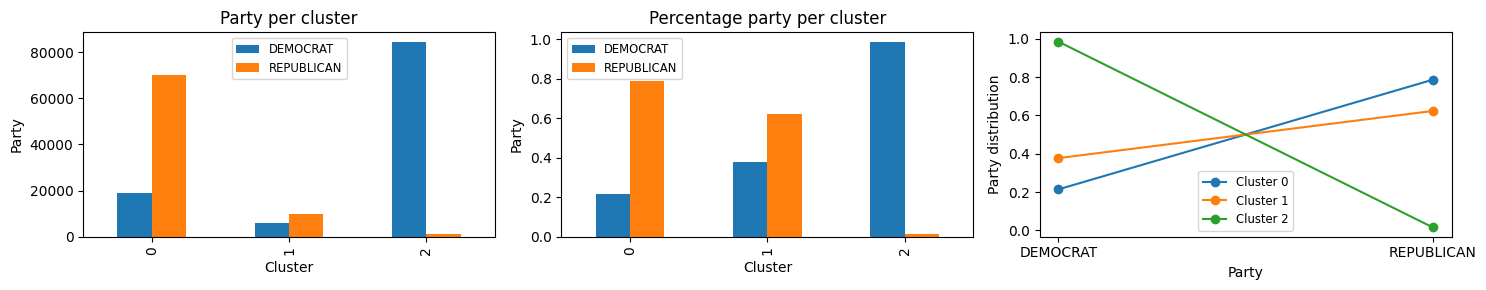

In [125]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [126]:
day_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         3307  2827  2865  2825  2970  2905  2843  2937  2831  2849  ...   
1          572   502   532   529   501   513   530   511   541   481  ...   
2         3081  2701  2736  2862  2880  2811  2798  2741  2695  2682  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0         2820  2890  2778  3004  3019  3062  2985  2740  2675  1744  
1          551   526   485   544   548   490   524   486   484   327  
2         2710  2820  2793  2927  2786  2835  2814  2717  2647  1745  

[3 rows x 31 columns]

In [127]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.037012  0.031640  0.032065  0.031617  0.033240  0.032513  0.031819   
1  0.035959  0.031558  0.033444  0.033256  0.031496  0.032250  0.033319   
2  0.035943  0.031510  0.031918  0.033388  0.033598  0.032793  0.032641   

         8         9         10  ...        22        23        24        25  \
0  0.032871  0.031684  0.031886  ...  0.031561  0.032345  0.031091  0.033621   
1  0.032124  0.034010  0.030238  ...  0.034639  0.033067  0.030490  0.034199   
2  0.031976  0.031440  0.031288  ...  0.031615  0.032898  0.032583  0.034146   

         26        27        28        29        30        31  
0  0.033788  0.034270  0.033408  0.030666  0.029938  0.019519  
1  0.034450  0.030804  0.032941  0.030553  0.030427  0.020557  
2  0.032501  0.033073  0.032828  0.031696  0.030880  0.020357  

[3 rows x 31 columns]

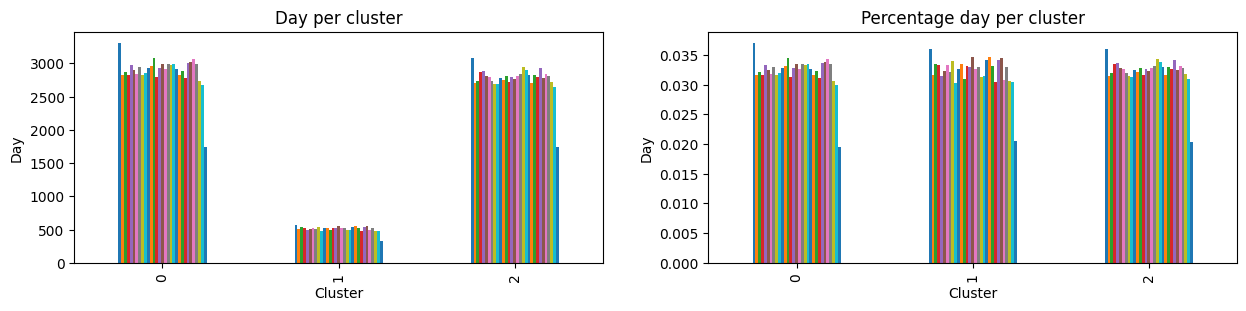

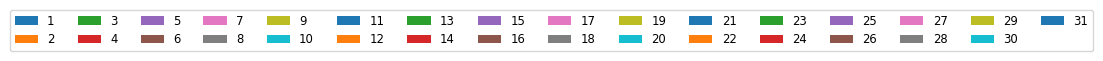

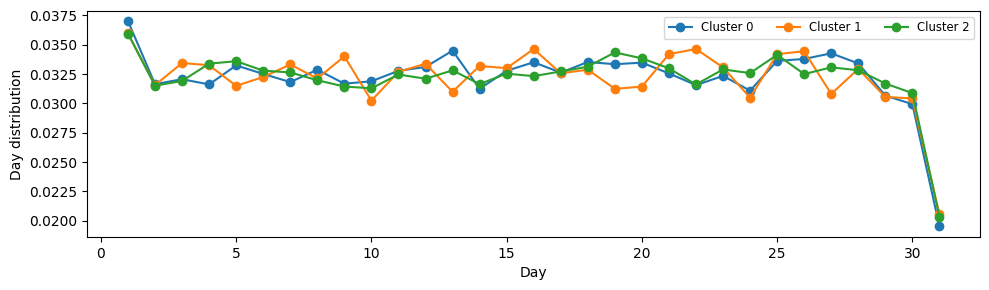

In [128]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small', ncols=5)
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [129]:
month_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['date_month'])
month_xt_pct

date_month    1     2     3     4     5     6     7     8     9     10    11  \
row_0                                                                          
0           9207  7486  8891  6714  6865  6694  7455  7451  6948  7389  6773   
1           1592  1709  1536  1226  1251  1224  1193  1164  1241  1253  1315   
2           7711  6048  7848  6600  7484  6646  7803  8064  7219  7176  6285   

date_month    12  
row_0             
0           7477  
1           1203  
2           6836

In [130]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.103044  0.083783  0.099508  0.075143  0.076833  0.074919  0.083436   
1  0.100082  0.107437  0.096561  0.077073  0.078645  0.076947  0.074998   
2  0.089956  0.070555  0.091554  0.076995  0.087308  0.077531  0.091029   

         8         9         10        11        12  
0  0.083391  0.077762  0.082697  0.075803  0.083682  
1  0.073175  0.078016  0.078770  0.082668  0.075627  
2  0.094074  0.084216  0.083714  0.073320  0.079748

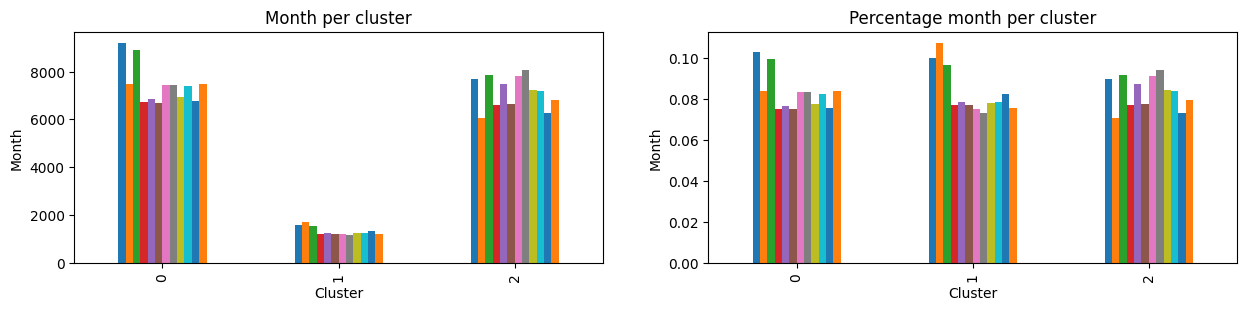

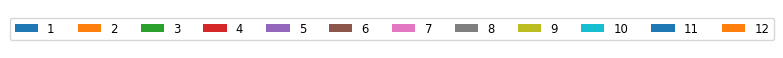

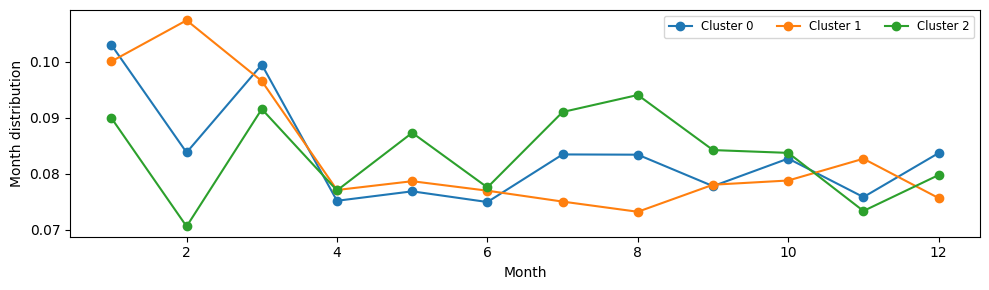

In [131]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small', ncols=5)
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [132]:
year_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0               4   13823   19244   24154   26201    5924
1              26    4148    3871    3417    3535     910
2              11   13821   16307   25120   25196    5265

In [133]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000045  0.154706  0.215378  0.270330  0.293240  0.066301
1  0.001635  0.260766  0.243352  0.214811  0.222229  0.057208
2  0.000128  0.161234  0.190236  0.293047  0.293934  0.061421

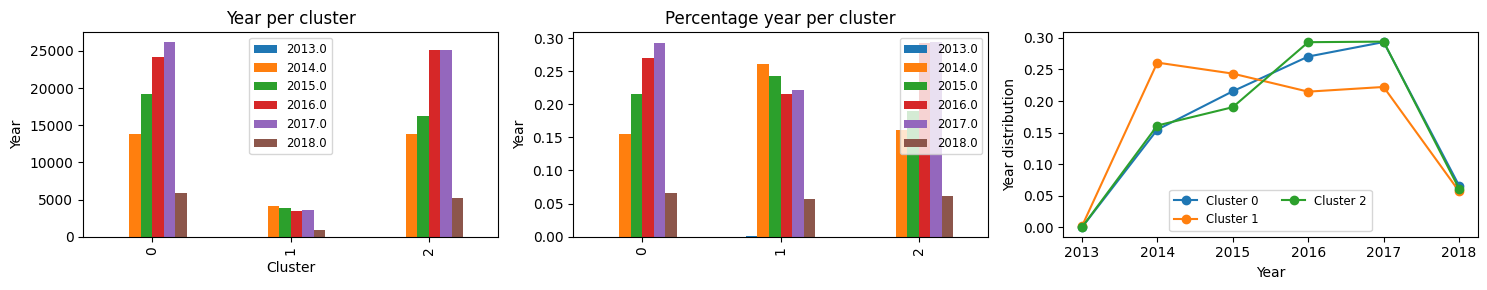

In [134]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small', ncols=2)
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [135]:
state_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0         2476     156      437      2286        4017      2053         1779   
1          219       1      510       126        1603       321          192   
2         1642       0      963         0        4670       491          804   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0           697     6844     3798  ...           464       2753   4736   662   
1             2     1055      411  ...            26        270   1438   190   
2           736     3330     3047  ...             0       3125   3356     0   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0          132      1898        1549           1188       1101      416  
1           49       503         503            122        329       35  
2          204      2449         771             15       2763        0  

[3 rows x 50 columns]

In [136]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.027711  0.001746  0.004891  0.025585    0.044958  0.022977     0.019910   
1  0.013768  0.000063  0.032061  0.007921    0.100773  0.020180     0.012070   
2  0.019155  0.000000  0.011234  0.000000    0.054480  0.005728     0.009379   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.007801  0.076598  0.042507  ...      0.005193   0.030811  0.053005   
1  0.000126  0.066323  0.025838  ...      0.001635   0.016974  0.090400   
2  0.008586  0.038847  0.035546  ...      0.000000   0.036456  0.039151   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.007409  0.001477  0.021242    0.017336       0.013296   0.012322   
1  0.011944  0.003080  0.031621    0.031621       0.007670   0.020683   
2  0.000000  0.002380  0.028570    0.008994       0.000175   0.032233   

    WYOMING  
0  0.004656  
1  0.002200  
2  0.000000  

[3 rows x 50 columns]

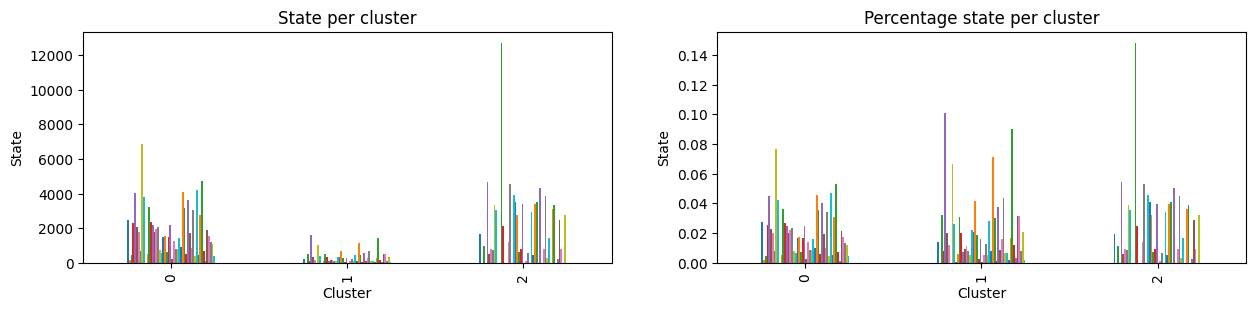

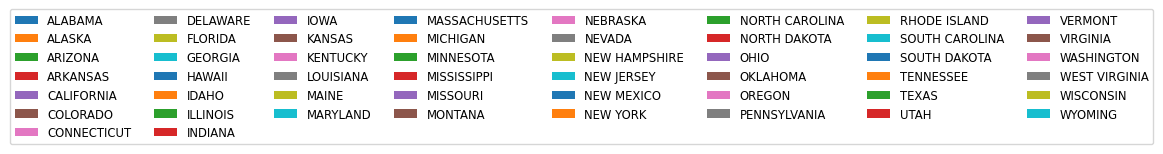

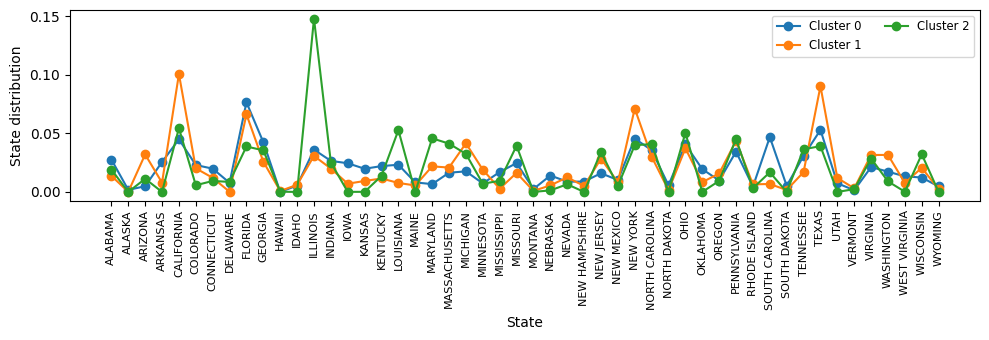

In [137]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small', ncols=2)
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [138]:
ic_xt_pct = pd.crosstab(best_model_ind.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                   2921                  196   
1                                    734                   37   
2                                   2216                  106   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 1                 12   
1                                                 0                  2   
2                                                 3                  7   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                   66                            20   
1                                   43                             2   
2                                  149                             6   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                     15                 99        33   
1                                      7                 34         4   
2                                     14                 59        25   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       497  ...                 146   
1                                        91  ...                  42   
2                                       257  ...                  51   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     2               1         459       21   
1                                     0               1          84        1   
2                                     2               1         117        8   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                       38         820                4   
1                                       17         231                0   
2                                       16         947                1   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                     528                       0  
1                                     115                       0  
2                                     492                       1  

[3 rows x 49 columns]

In [139]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.032692             0.002194                  0.000011   
1       0.046143             0.002326                  0.000000   
2       0.025852             0.001237                  0.000035   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000134     0.000739                      0.000224   
1           0.000126     0.002703                      0.000126   
2           0.000082     0.001738                      0.000070   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000168           0.001108  0.000369          0.005562  ...   
1       0.000440           0.002137  0.000251          0.005721  ...   
2       0.000163           0.000688  0.000292          0.002998  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001634      0.000022        0.000011    0.005137  0.000235   
1            0.002640      0.000000        0.000063    0.005281  0.000063   
2            0.000595      0.000023        0.000012    0.001365  0.000093   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000425    0.009177         0.000045        0.005909   
1         0.001069    0.014522         0.000000        0.007230   
2         0.000187    0.011048         0.000012        0.005740   

   UNLAWFUL_PURCHASE_SALE  
0                0.000000  
1                0.000000  
2                0.000012  

[3 rows x 49 columns]

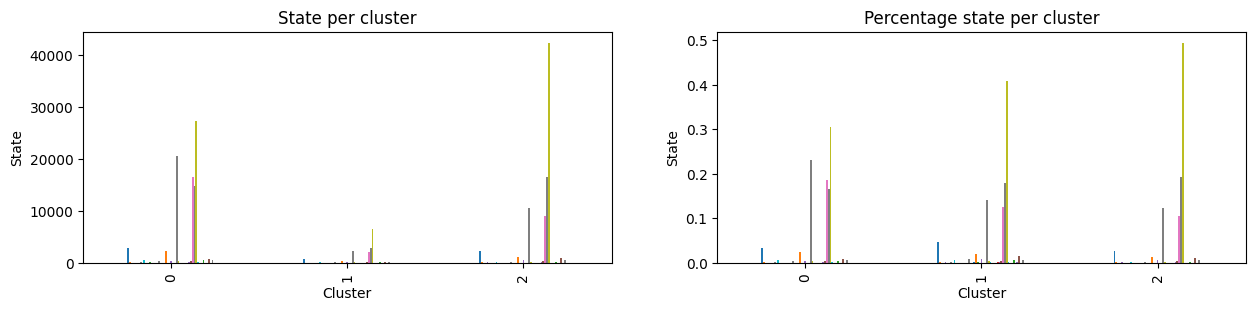

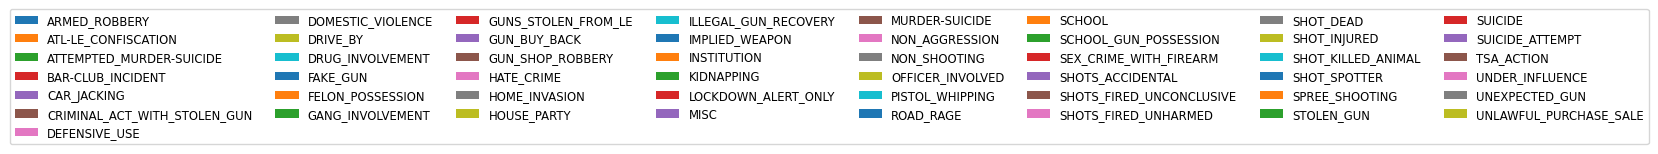

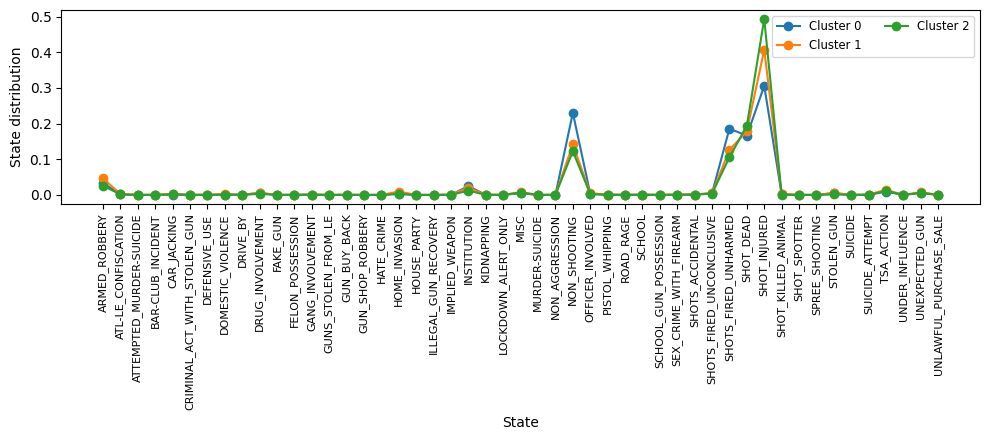

In [140]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small', ncols=2)
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

#### Only indicators reduced clustering

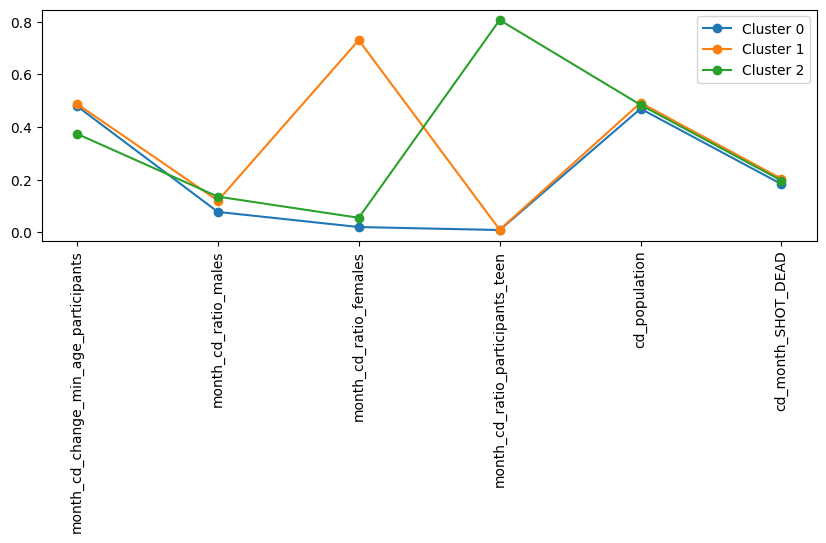

In [141]:
centers = best_model_r_ind.cluster_centers_
cols = reduced_ind.columns

plt.figure(figsize=(10, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

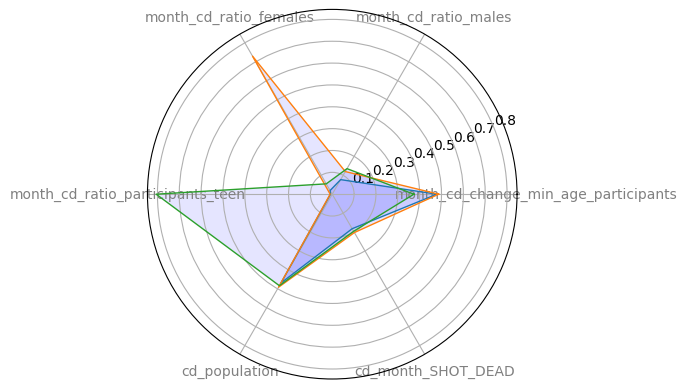

In [142]:
N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=10) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [143]:
party_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['party'])
party_xt_pct

party  DEMOCRAT  REPUBLICAN
row_0                      
0        104598       74244
1          2677        4225
2          2239        2994

In [144]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

DEMOCRAT  REPUBLICAN
0  0.584863    0.415137
1  0.387859    0.612141
2  0.427862    0.572138

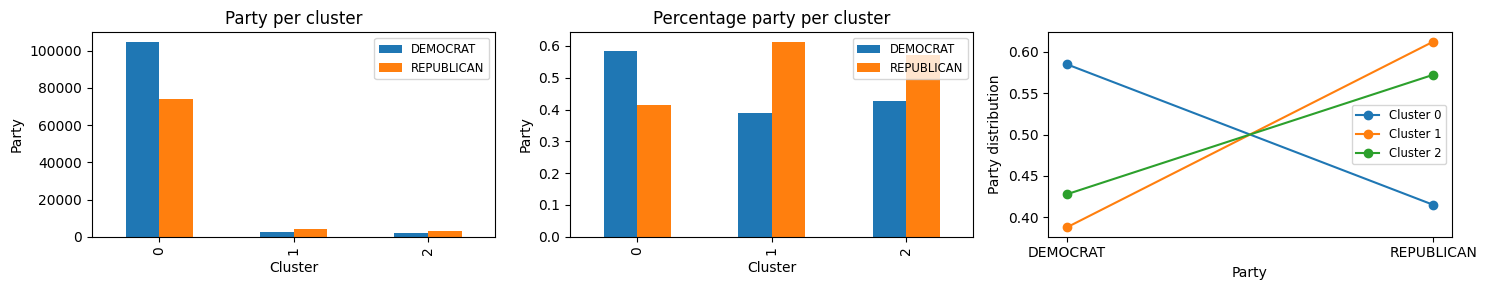

In [145]:
distrs = party_xt_pct_p.values
cols = party_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Party')
axes[2].set_ylabel('Party distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [146]:
day_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['date_day'])
day_xt_pct

date_day    1     2     3     4     5     6     7     8     9     10  ...  \
row_0                                                                 ...   
0         6509  5616  5758  5832  5948  5817  5786  5818  5675  5675  ...   
1          272   220   212   231   220   232   229   194   218   190  ...   
2          179   194   163   153   183   180   156   177   174   147  ...   

date_day    22    23    24    25    26    27    28    29    30    31  
row_0                                                                 
0         5689  5814  5708  6039  5932  5989  5897  5577  5430  3589  
1          224   256   201   256   236   222   233   213   242   141  
2          168   166   147   180   185   176   193   153   134    86  

[3 rows x 31 columns]

In [147]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

1         2         3         4         5         6         7   \
0  0.036395  0.031402  0.032196  0.032610  0.033258  0.032526  0.032353   
1  0.039409  0.031875  0.030716  0.033469  0.031875  0.033613  0.033179   
2  0.034206  0.037072  0.031148  0.029238  0.034970  0.034397  0.029811   

         8         9         10  ...        22        23        24        25  \
0  0.032532  0.031732  0.031732  ...  0.031810  0.032509  0.031916  0.033767   
1  0.028108  0.031585  0.027528  ...  0.032454  0.037091  0.029122  0.037091   
2  0.033824  0.033251  0.028091  ...  0.032104  0.031722  0.028091  0.034397   

         26        27        28        29        30        31  
0  0.033169  0.033488  0.032973  0.031184  0.030362  0.020068  
1  0.034193  0.032165  0.033758  0.030861  0.035062  0.020429  
2  0.035353  0.033633  0.036881  0.029238  0.025607  0.016434  

[3 rows x 31 columns]

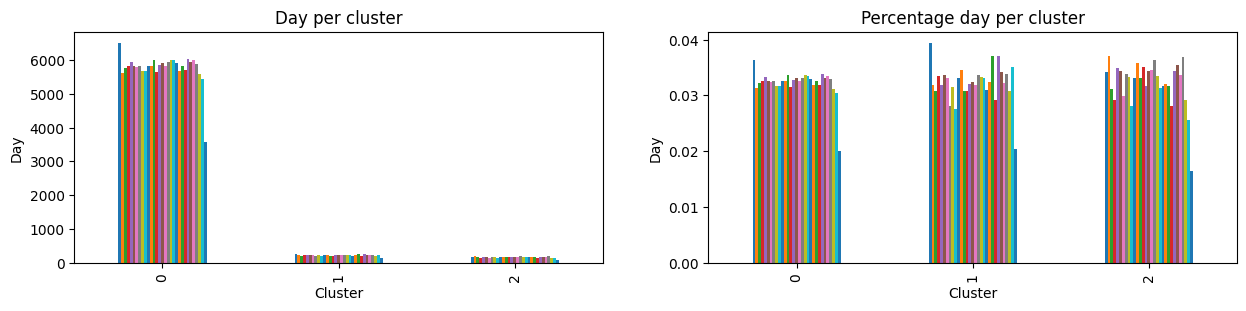

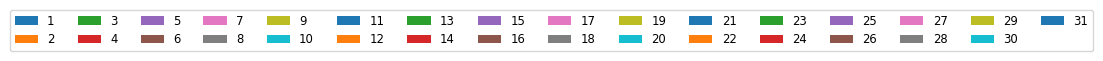

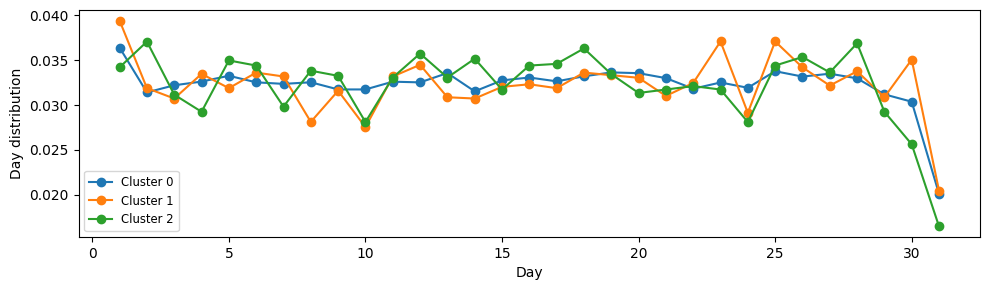

In [148]:
distrs = day_xt_pct_p.values
cols = day_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Day')
ax.set_ylabel('Day distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [149]:
month_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['date_month'])
month_xt_pct

date_month     1      2      3      4      5      6      7      8      9   \
row_0                                                                       
0           17278  14031  17076  13608  14650  13685  15534  15717  14466   
1             710    698    708    519    511    518    522    559    525   
2             522    514    491    413    439    361    395    403    417   

date_month     10     11     12  
row_0                            
0           14832  13387  14578  
1             561    542    529  
2             425    444    409

In [150]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

1         2         3         4         5         6         7   \
0  0.096610  0.078455  0.095481  0.076090  0.081916  0.076520  0.086859   
1  0.102869  0.101130  0.102579  0.075196  0.074037  0.075051  0.075630   
2  0.099752  0.098223  0.093828  0.078922  0.083891  0.068985  0.075483   

         8         9         10        11        12  
0  0.087882  0.080887  0.082934  0.074854  0.081513  
1  0.080991  0.076065  0.081281  0.078528  0.076644  
2  0.077011  0.079687  0.081215  0.084846  0.078158

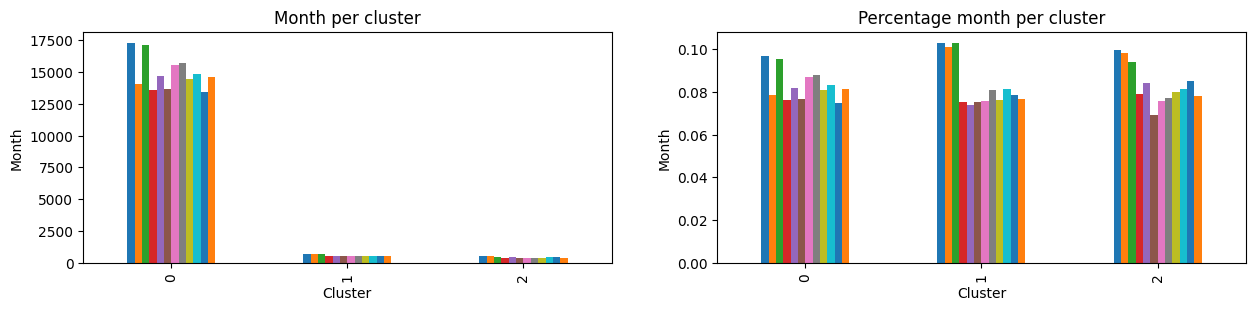

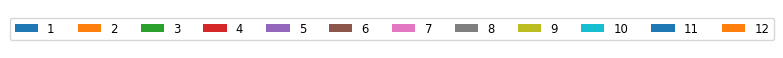

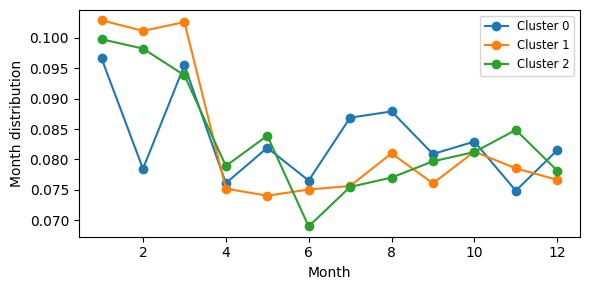

In [151]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 0.5))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=12)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(6, 3))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('Month')
ax.set_ylabel('Month distribution')
ax.set_title(f'')

plt.tight_layout()
plt.show()

In [152]:
year_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['date_year'])
year_xt_pct

date_year  2013.0  2014.0  2015.0  2016.0  2017.0  2018.0
row_0                                                    
0              35   29283   36608   49723   51827   11366
1               4    1447    1641    1676    1716     418
2               2    1062    1173    1292    1389     315

In [153]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

2013.0    2014.0    2015.0    2016.0    2017.0    2018.0
0  0.000196  0.163737  0.204695  0.278028  0.289792  0.063553
1  0.000580  0.209649  0.237757  0.242828  0.248624  0.060562
2  0.000382  0.202943  0.224154  0.246895  0.265431  0.060195

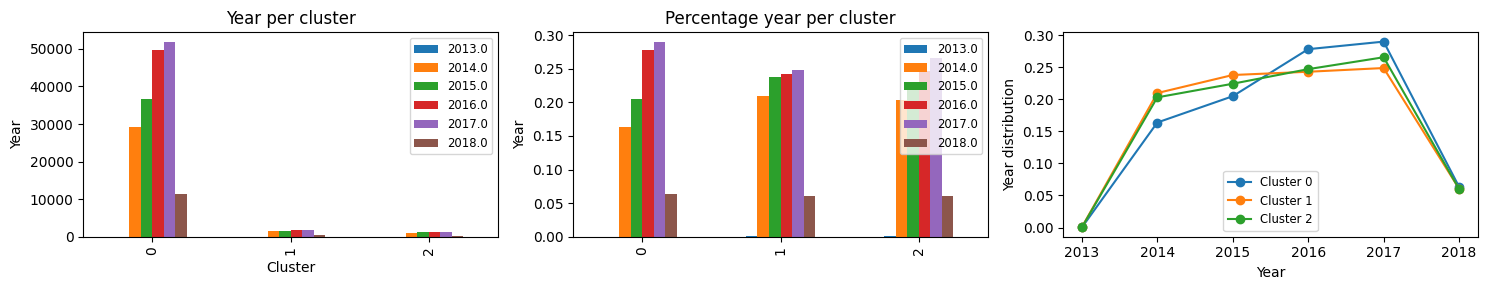

In [154]:
distrs = year_xt_pct_p.values
cols = year_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small')
axes[1].set_ylabel('Year')

for i in range(len(centers)):
    line, = axes[2].plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

axes[2].legend(fontsize='small')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Year distribution')
axes[2].set_title(f'')

plt.tight_layout()
plt.show()

In [155]:
state_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['state'])
state_xt_pct

state  ALABAMA  ALASKA  ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
row_0                                                                          
0         4105     157     1678      2263        9360      2631         2618   
1          107       0      148        79         543       142           93   
2          125       0       84        70         387        92           64   

state  DELAWARE  FLORIDA  GEORGIA  ...  SOUTH DAKOTA  TENNESSEE  TEXAS  UTAH  \
row_0                              ...                                         
0          1407    10482     6847  ...           450       5859   8595   751   
1            10      416      213  ...            22        151    558    64   
2            18      331      196  ...            18        138    377    37   

state  VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  WYOMING  
row_0                                                                    
0          347      4533        2513           1195       3979      413  
1           28       187         197             78        125       25  
2           10       130         113             52         89       13  

[3 rows x 50 columns]

In [156]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

ALABAMA    ALASKA   ARIZONA  ARKANSAS  CALIFORNIA  COLORADO  CONNECTICUT  \
0  0.022953  0.000878  0.009383  0.012654    0.052337  0.014711     0.014639   
1  0.015503  0.000000  0.021443  0.011446    0.078673  0.020574     0.013474   
2  0.023887  0.000000  0.016052  0.013377    0.073954  0.017581     0.012230   

   DELAWARE   FLORIDA   GEORGIA  ...  SOUTH DAKOTA  TENNESSEE     TEXAS  \
0  0.007867  0.058610  0.038285  ...      0.002516   0.032761  0.048059   
1  0.001449  0.060272  0.030861  ...      0.003187   0.021878  0.080846   
2  0.003440  0.063252  0.037455  ...      0.003440   0.026371  0.072043   

       UTAH   VERMONT  VIRGINIA  WASHINGTON  WEST VIRGINIA  WISCONSIN  \
0  0.004199  0.001940  0.025346    0.014052       0.006682   0.022249   
1  0.009273  0.004057  0.027094    0.028542       0.011301   0.018111   
2  0.007071  0.001911  0.024842    0.021594       0.009937   0.017007   

    WYOMING  
0  0.002309  
1  0.003622  
2  0.002484  

[3 rows x 50 columns]

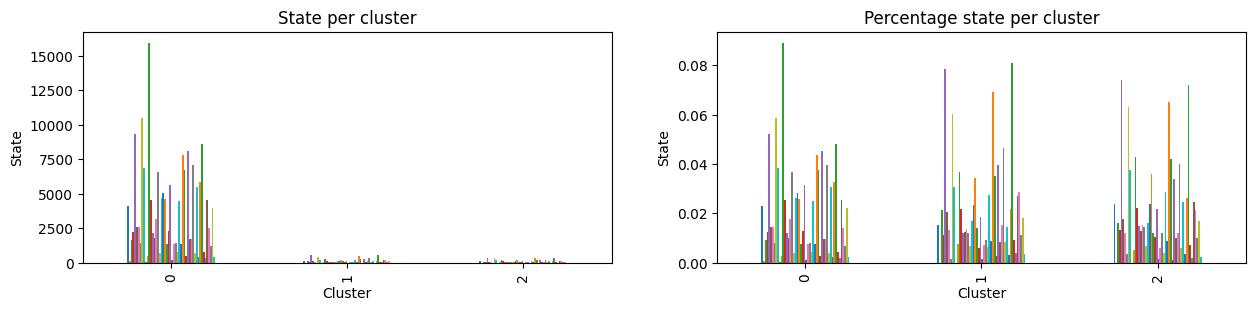

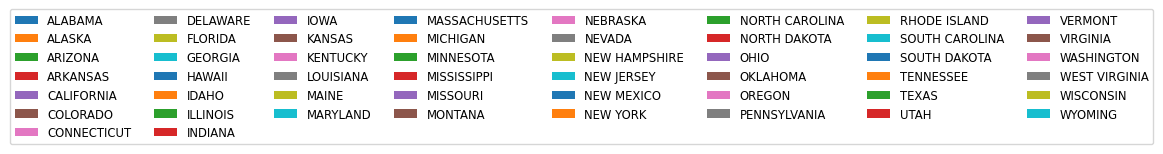

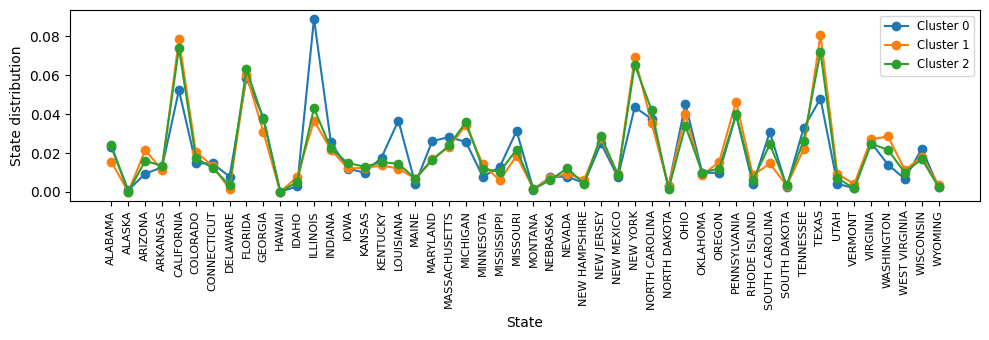

In [157]:
distrs = state_xt_pct_p.values
cols = state_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 3.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

In [158]:
ic_xt_pct = pd.crosstab(best_model_r_ind.labels_, df_c['incident_characteristics1'])
ic_xt_pct

incident_characteristics1  ARMED_ROBBERY  ATL-LE_CONFISCATION  \
row_0                                                           
0                                   5625                  318   
1                                    158                   12   
2                                     88                    9   

incident_characteristics1  ATTEMPTED_MURDER-SUICIDE  BAR-CLUB_INCIDENT  \
row_0                                                                    
0                                                 4                 20   
1                                                 0                  0   
2                                                 0                  1   

incident_characteristics1  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
row_0                                                                  
0                                  228                            27   
1                                   21                             1   
2                                    9                             0   

incident_characteristics1  DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  \
row_0                                                                   
0                                     34                146        57   
1                                      1                 41         3   
2                                      1                  5         2   

incident_characteristics1  DRUG_INVOLVEMENT  ...  SHOT_KILLED_ANIMAL  \
row_0                                        ...                       
0                                       793  ...                 211   
1                                        38  ...                  23   
2                                        14  ...                   5   

incident_characteristics1  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN  SUICIDE  \
row_0                                                                          
0                                     4               2         610       30   
1                                     0               1          26        0   
2                                     0               0          24        0   

incident_characteristics1  SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  \
row_0                                                                     
0                                       61        1857                4   
1                                        7          79                1   
2                                        3          62                0   

incident_characteristics1  UNEXPECTED_GUN  UNLAWFUL_PURCHASE_SALE  
row_0                                                              
0                                    1073                       1  
1                                      39                       0  
2                                      23                       0  

[3 rows x 49 columns]

In [159]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

ARMED_ROBBERY  ATL-LE_CONFISCATION  ATTEMPTED_MURDER-SUICIDE  \
0       0.031452             0.001778                  0.000022   
1       0.022892             0.001739                  0.000000   
2       0.016816             0.001720                  0.000000   

   BAR-CLUB_INCIDENT  CAR_JACKING  CRIMINAL_ACT_WITH_STOLEN_GUN  \
0           0.000112     0.001275                      0.000151   
1           0.000000     0.003043                      0.000145   
2           0.000191     0.001720                      0.000000   

   DEFENSIVE_USE  DOMESTIC_VIOLENCE  DRIVE_BY  DRUG_INVOLVEMENT  ...  \
0       0.000190           0.000816  0.000319          0.004434  ...   
1       0.000145           0.005940  0.000435          0.005506  ...   
2       0.000191           0.000955  0.000382          0.002675  ...   

   SHOT_KILLED_ANIMAL  SHOT_SPOTTER  SPREE_SHOOTING  STOLEN_GUN   SUICIDE  \
0            0.001180      0.000022        0.000011    0.003411  0.000168   
1            0.003332      0.000000        0.000145    0.003767  0.000000   
2            0.000955      0.000000        0.000000    0.004586  0.000000   

   SUICIDE_ATTEMPT  TSA_ACTION  UNDER_INFLUENCE  UNEXPECTED_GUN  \
0         0.000341    0.010383         0.000022        0.006000   
1         0.001014    0.011446         0.000145        0.005651   
2         0.000573    0.011848         0.000000        0.004395   

   UNLAWFUL_PURCHASE_SALE  
0                0.000006  
1                0.000000  
2                0.000000  

[3 rows x 49 columns]

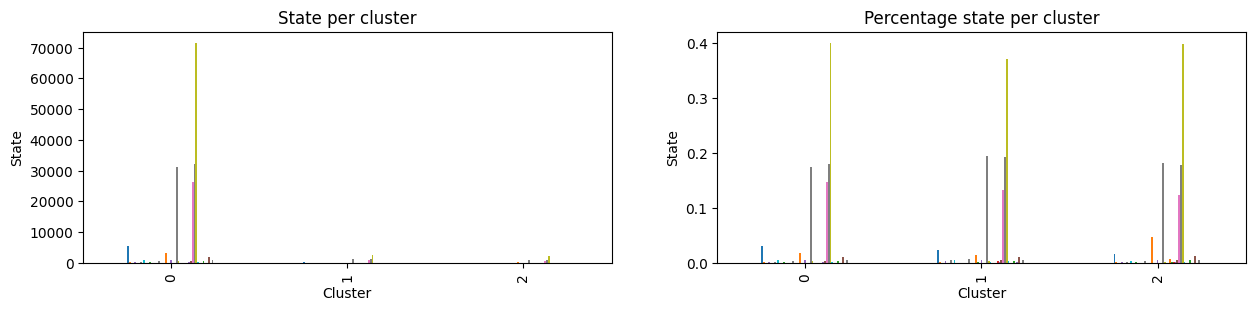

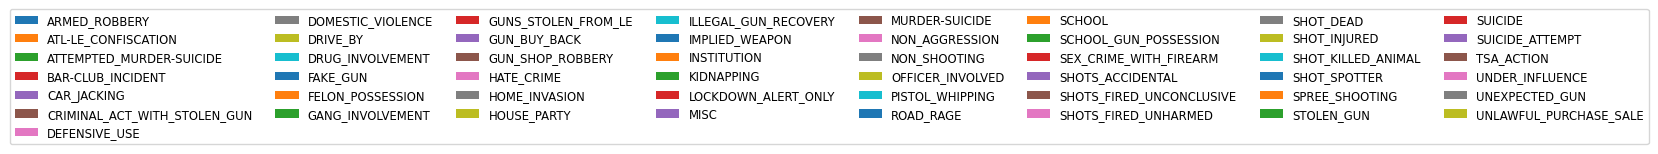

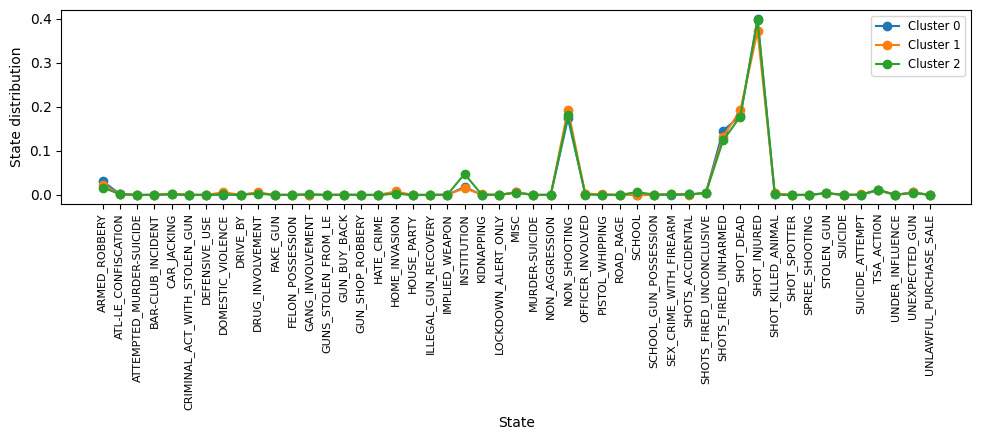

In [160]:
distrs = ic_xt_pct_p.values
cols = ic_xt_pct_p.columns
avg_distr = np.mean(distrs, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(15, 3))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 1))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

fig, ax = plt.subplots(figsize=(10, 4.5))

for i in range(len(centers)):
    line, = ax.plot(cols, distrs[i], marker='o', linestyle='-', label=f'Cluster {i}')

ax.legend(fontsize='small')
ax.set_xlabel('State')
ax.set_ylabel('State distribution')
ax.set_title(f'')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()

### Looking at the centroids

In [163]:
print(scores_dict)

{'SSE': [None, None, None, 14536.677436608601], 'Separation': [None, None, None, 0.8343748674959905], 'Silhouette': [[], [], [], [0.5792873840758809, 0.5799236156468716, 0.5792662318738164]]}


In [242]:
sse = []
separation = []
silhouette = []
for i in range(len(best_model_orig.cluster_centers_)):
    sse.append(None)
    separation.append(None)
    silhouette.append([])
sse.append(136206.37920588793)
separation.append(1.6050108948413984)
silhouette.append([0.255300590534846])
score_orig = {
    'SSE': sse,
    'Separation': separation,
    'Silhouette': silhouette
}

sse = []
separation = []
silhouette = []
for i in range(len(best_model_r_orig.cluster_centers_)):
    sse.append(None)
    separation.append(None)
    silhouette.append([])
sse.append(33337.49599621496)
separation.append(0.8318175058975704)
silhouette.append([0.5290817065457744])
score_r_orig = {
    'SSE': sse,
    'Separation': separation,
    'Silhouette': silhouette
}

sse = []
separation = []
silhouette = []
for i in range(len(best_model.cluster_centers_)):
    sse.append(None)
    separation.append(None)
    silhouette.append([])
sse.append(239000.20582518316)
separation.append(1.4625169859133083)
silhouette.append([0.23922525507806047])
score = {
    'SSE': sse,
    'Separation': separation,
    'Silhouette': silhouette
} 

sse = []
separation = []
silhouette = []
for i in range(len(best_model_r.cluster_centers_)):
    sse.append(None)
    separation.append(None)
    silhouette.append([])
sse.append(33337.495996214966)
separation.append(0.8318175058975704)
silhouette.append([0.5275344098374074])
score_r = {
    'SSE': sse,
    'Separation': separation,
    'Silhouette': silhouette
}

sse = []
separation = []
silhouette = []
for i in range(len(best_model_ind.cluster_centers_)):
    sse.append(None)
    separation.append(None)
    silhouette.append([])
sse.append(73874.43056744307)
separation.append(2.391979671883118)
silhouette.append([0.17637547181414892])
score_ind = {
    'SSE': sse,
    'Separation': separation,
    'Silhouette': silhouette
}

sse = []
separation = []
silhouette = []
for i in range(len(best_model_r_ind.cluster_centers_)):
    sse.append(None)
    separation.append(None)
    silhouette.append([])
sse.append(14536.677436608601)
separation.append(0.8343748674959905)
silhouette.append([0.5794924105321896])
score_r_ind = {
    'SSE': sse,
    'Separation': separation,
    'Silhouette': silhouette
}

best_scores = [score_orig, score_r_orig, score, score_r, score_ind, score_r_ind]

In [243]:
scores2 = []
for m, s in zip(models, best_scores):
    s = {
        'SSE': s['SSE'][len(m.cluster_centers_)],
        'Separation': s['Separation'][len(m.cluster_centers_)],
        'Silhouette': np.mean(s['Silhouette'][len(m.cluster_centers_)])
    }
    scores2.append(s)
best_scores = scores2
best_scores

[{'SSE': 136206.37920588793,
  'Separation': 1.6050108948413984,
  'Silhouette': 0.255300590534846},
 {'SSE': 33337.49599621496,
  'Separation': 0.8318175058975704,
  'Silhouette': 0.5290817065457744},
 {'SSE': 239000.20582518316,
  'Separation': 1.4625169859133083,
  'Silhouette': 0.23922525507806047},
 {'SSE': 33337.495996214966,
  'Separation': 0.8318175058975704,
  'Silhouette': 0.5275344098374074},
 {'SSE': 73874.43056744307,
  'Separation': 2.391979671883118,
  'Silhouette': 0.17637547181414892},
 {'SSE': 14536.677436608601,
  'Separation': 0.8343748674959905,
  'Silhouette': 0.5794924105321896}]

In [200]:
datafames = [df_orig, reduced_orig, df, reduced, df_ind, reduced_ind]
models = [best_model_orig, best_model_r_orig, best_model, best_model_r, best_model_ind, best_model_r_ind]
best_scores = [score_orig, score_r_orig, score, score_r, score_ind, score_r_ind]

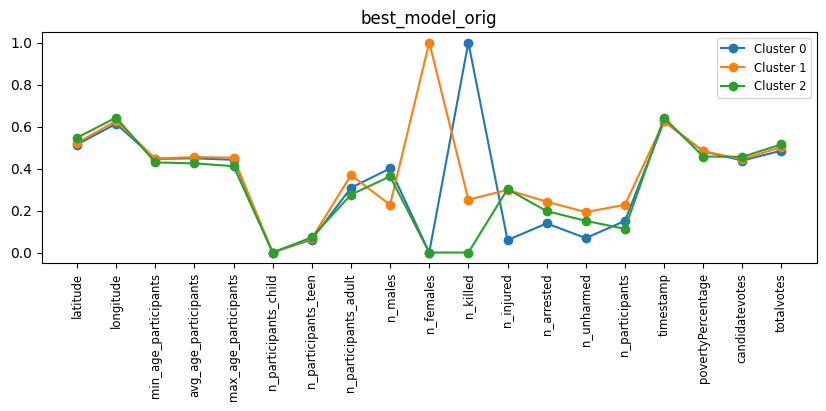

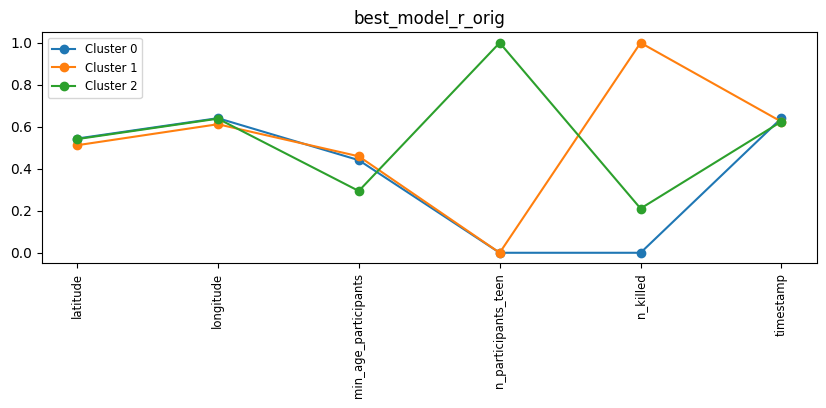

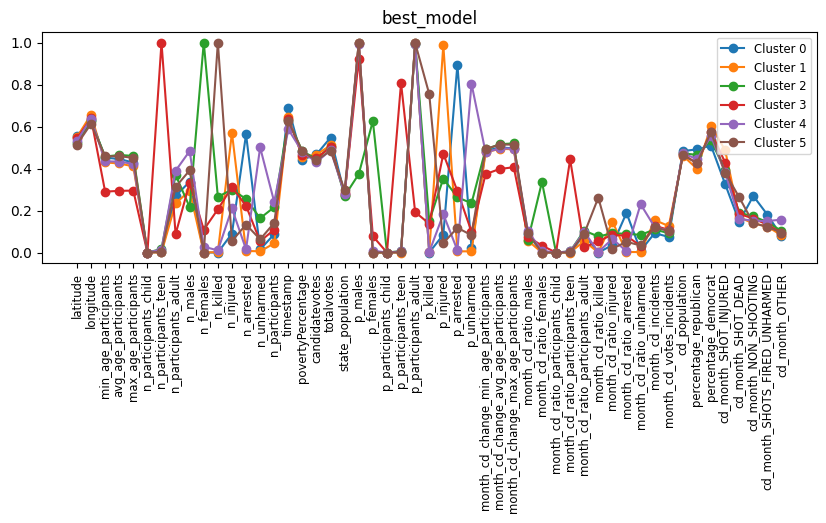

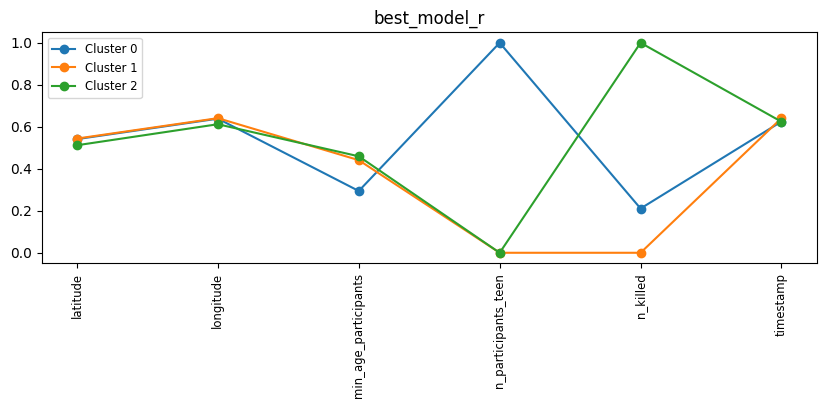

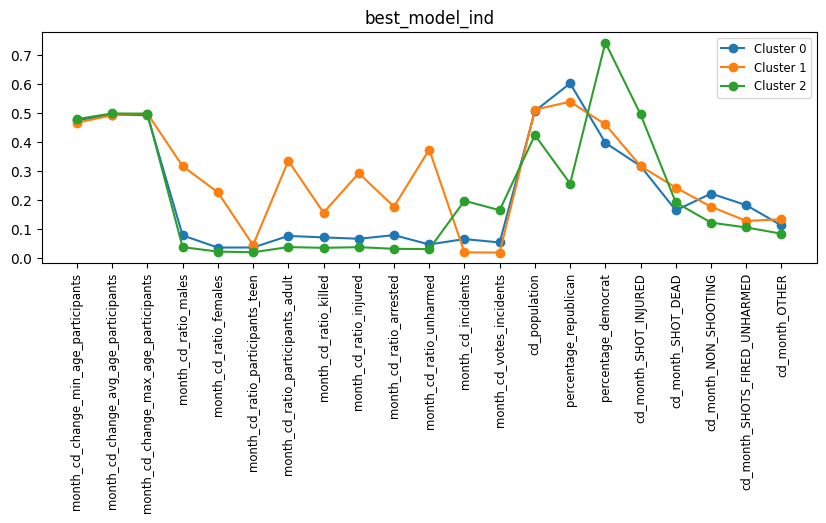

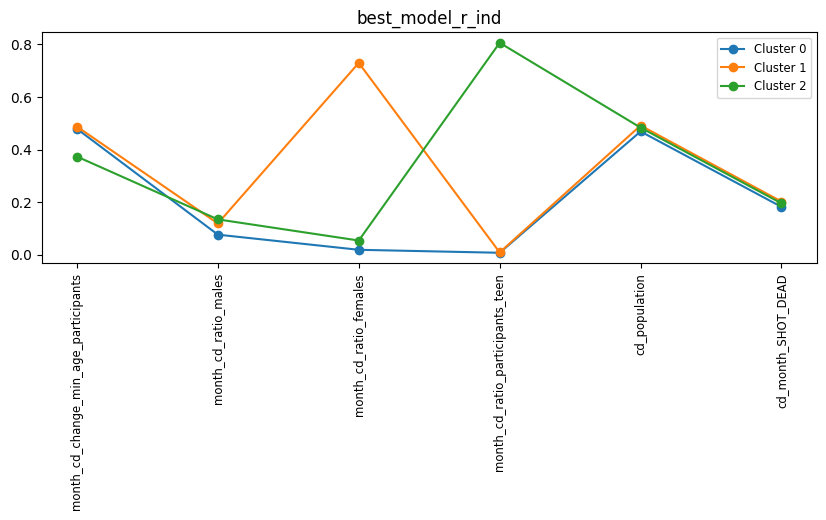

In [214]:
labels =['best_model_orig', 'best_model_r_orig', 'best_model', 'best_model_r', 'best_model_ind', 'best_model_r_ind']
for model, dataframe, label in zip(models, datafames, labels):
    plt.figure(figsize=(10, 3))
    plt.title(label)
    centers = model.cluster_centers_
    cols = dataframe.columns
    for i in range(0, len(centers)):
        plt.plot(centers[i], marker='o', label='Cluster %s' % i)
        plt.xticks(range(len(cols)), cols, rotation=90, fontsize='small')
        plt.legend(fontsize='small', ncol=1)
plt.show()

In [227]:
new_colss = []
for model, dataframe in zip(models, datafames):
    centers = model.cluster_centers_
    cols = dataframe.columns
    survived_cols = []
    for i in range(len(cols)):
        std_dev = np.std([center[i] for center in centers])
        if std_dev > 0.05:
            survived_cols.append(cols[i])
    new_colss.append(survived_cols)
    
for cols in new_colss:
    print(cols)

['n_males', 'n_females', 'n_killed', 'n_injured', 'n_unharmed']
['min_age_participants', 'n_participants_teen', 'n_killed']
['min_age_participants', 'avg_age_participants', 'max_age_participants', 'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants', 'p_males', 'p_females', 'p_participants_teen', 'p_participants_adult', 'p_killed', 'p_injured', 'p_arrested', 'p_unharmed', 'month_cd_ratio_females', 'month_cd_ratio_participants_teen', 'month_cd_ratio_killed', 'month_cd_ratio_arrested', 'month_cd_ratio_unharmed']
['min_age_participants', 'n_participants_teen', 'n_killed']
['month_cd_ratio_males', 'month_cd_ratio_females', 'month_cd_ratio_participants_adult', 'month_cd_ratio_killed', 'month_cd_ratio_injured', 'month_cd_ratio_arrested', 'month_cd_ratio_unharmed', 'month_cd_incidents', 'month_cd_votes_incidents', 'percentage_republican', 'percentage_democrat', 'cd_month_SHOT_INJURED']
['month_cd_change_mi

In [258]:
k_min = 2
k_max = 20

new_modelss = []
for model, dataframe, cols in zip(models, datafames, new_colss):
    k =len(model.cluster_centers_)
    new_modelss.append(k_means(dataframe[cols], k_min=k_min, k_max=k_max, max_iter=1000000)[k])

100%|██████████| 19/19 [00:58<00:00,  3.07s/it]


In [259]:
mean_scoress = []
for new_models, dataframe, cols in zip(new_modelss, dataframes, new_colss):
    scores_dict = scores(models=new_models, df=dataframe[cols], k_min=k_min, k_max=k_max, sample_size=1000, n_samples=3)
    mean_scores = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)
    mean_scoress.append(mean_scores)

NameError: name 'dataframes' is not defined

In [ ]:
mean_scoress2 = []
for new_models, dataframe, cols, mean_scores in zip(new_modelss, dataframes, mean_scoress, new_colss):
    best_k = np.argmax(mean_scores)+k_min

    k_min = np.max([best_k-2, 2])
    k_max = np.min([best_k+2, k_max])

    scores_dict = scores(models=new_models, df=dataframe[cols], k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
    mean_scores2 = show_scores(scores_dict=scores_dict, k_min=k_min, k_max=k_max)
    mean_scoress2.append(mean_scores2)

    for k in range(k_min, k_max+1):
        print(f'\nk = {k}:')

        for key in scores_dict:
            print(f'{key} = {np.mean(scores_dict[key][k])}')

In [ ]:
models2 = []
best_scores2 = []
for new_models, dataframe, cols, mean_scores, label in zip(new_modelss, dataframes, new_colss, mean_scoress2, labels):
    best_k = np.argmax(mean_scores)+k_min
    
    scores_dict = scores(models=new_models, df=dataframe[cols], k_min=best_k, k_max=best_k, sample_size=10000, n_samples=3)
    print(f'\nNew score for {label} (k = {best_k}):')
    for key in scores_dict:
        print(f'{key} = {np.mean(scores_dict[key][best_k])}')

    best_scores2.append({
        'SSE': scores_dict['SSE'][best_k],
        'Separation': scores_dict['Separation'][best_k],
        'Silhouette': np.mean(scores_dict['Silhouette'][best_k])
        })
    models2.append(new_models[best_k])
    joblib.dump(model, f'{label}2.pkl')

k = 3


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:23<00:00,  7.88s/it]



New score for best_model_orig (k = 3):
SSE = 169178.9965570541
Separation = 1.1416913011308198
Silhouette = 0.37171364257815126
k = 3


100%|██████████| 3/3 [00:22<00:00,  7.62s/it]



New score for best_model_r_orig (k = 3):
SSE = 7273.033767900444
Separation = 0.43885614457089756
Silhouette = 0.8136232273760479
k = 6


100%|██████████| 3/3 [00:22<00:00,  7.47s/it]



New score for best_model (k = 6):
SSE = 7241360.281371522
Separation = 0.7496651972459326
Silhouette = 0.42039981608946403
k = 3


100%|██████████| 3/3 [00:23<00:00,  7.75s/it]



New score for best_model_r (k = 3):
SSE = 7273.033767900444
Separation = 0.43885614457089756
Silhouette = 0.8129841979078005
k = 3


100%|██████████| 3/3 [00:07<00:00,  2.39s/it]



New score for best_model_ind (k = 3):
SSE = 29793725.289881878
Separation = 0.5172802087564191
Silhouette = 0.6908740028508359
k = 3


100%|██████████| 3/3 [00:20<00:00,  6.89s/it]


New score for best_model_r_ind (k = 3):
SSE = 5123.125533516392
Separation = 0.557947009939998
Silhouette = 0.7380258834381211


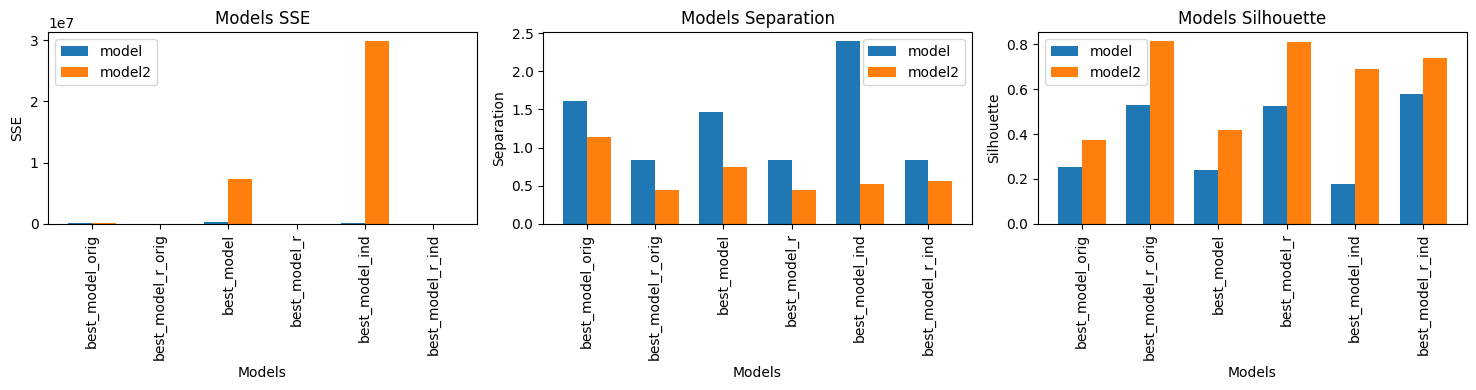

In [ ]:
plt.figure(figsize=(15, 4))
labels =['best_model_orig', 'best_model_r_orig', 'best_model', 'best_model_r', 'best_model_ind', 'best_model_r_ind']

i = 1
for key in best_scores[0].keys():
    plt.subplot(1, 3, i)
    values = [s[key] for m, s in zip(models, best_scores)]
    values2 = [s[key] for m, s in zip(models2, best_scores2)]
    bar_width = 0.35
    bar_positions1 = np.arange(len(labels))
    bar_positions2 = bar_positions1 + bar_width
    plt.bar(bar_positions1, values, width=bar_width, label='model')
    plt.bar(bar_positions2, values2, width=bar_width, label='model2')
    #plt.bar(labels, values)
    #plt.bar([l+str(2) for l in labels], values2)
    plt.xticks(bar_positions1 + bar_width / 2, labels, rotation=90)
    plt.xlabel('Models')
    plt.ylabel(key)
    plt.legend()
    plt.title(f'Models {key}')
    i += 1
plt.tight_layout()
plt.show()